In [4]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

C:\Users\OpSis\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
token = 'Flickr8k/Flickr8k.token.txt'

In [6]:
captions = open(token, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of the images

In [7]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [8]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
images = 'Flickr8k/Flicker8k_Dataset/'

In [10]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [11]:
img[:5]

['Flickr8k/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flickr8k/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flickr8k/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flickr8k/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flickr8k/Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [12]:
train_images_file = 'Flickr8k/Flickr_8k.trainImages.txt'

In [13]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [14]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [15]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [16]:
val_images_file = 'Flickr8k/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [17]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [18]:
test_images_file = 'Flickr8k/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [19]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

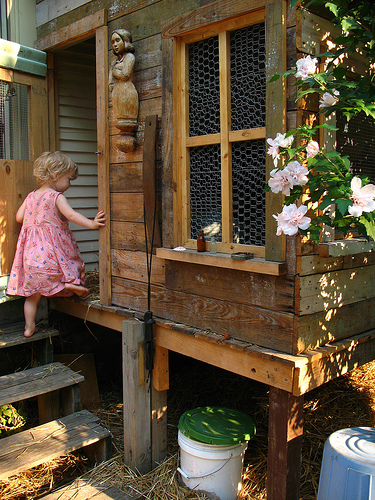

In [20]:
from PIL import Image
Image.open(train_img[0])

We will feed these images to InceptionV3 to get the encoded images. Hence we need to preprocess the images.

In [21]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [22]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

In [23]:
model = InceptionV3(weights='imagenet')

In [24]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [25]:
tryi = model_new.predict(preprocess(train_img[0]))

In [26]:
tryi.shape

(1, 2048)

In [27]:
from tqdm import tqdm

In [28]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [27]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [03:38<00:00, 27.48it/s]


In [28]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [29]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [30]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [31]:
encoding_train['3556792157_d09d42bef7.jpg']

array([0.72887987, 0.5060454 , 0.41434678, ..., 0.03124475, 0.58270437,
       0.60581833], dtype=float32)

In [34]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:13<00:00, 13.63it/s]


In [35]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [36]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [37]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [38]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [39]:
len(train_d)

6000

In [40]:
train_d[images[:-1]+'\\'+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [41]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [42]:
len(val_d)

1000

In [43]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [44]:
len(test_d)

1000

Calculating the unique words in the vocabulary.

In [45]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [46]:
words = [i.split() for i in caps]

In [47]:
unique = []
for i in words:
    unique.extend(i)

In [48]:
unique = list(set(unique))

In [49]:
with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d) 

In [50]:
unique = pickle.load(open('unique.p', 'rb'))

In [51]:
len(unique)

8256

Mapping the unique words to indices and vice-versa

In [52]:
word2idx = {val:index for index, val in enumerate(unique)}

In [53]:
word2idx['<start>']

6831

In [54]:
idx2word = {index:val for index, val in enumerate(unique)}

In [55]:
idx2word[8184]

'braided'

Calculating the maximum length among all the captions

In [56]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [57]:
len(unique), max_len

(8256, 40)

In [58]:
vocab_size = len(unique)

In [59]:
vocab_size

8256

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [60]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [61]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [62]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [63]:
f = open('flickr8k_test_dataset.txt', 'w')
f.write("image_id\tcaptions\n")
for key, val in test_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [64]:
len(df)

30000

In [65]:
c = [i for i in df['captions']]
len(c)

30000

In [66]:
imgs = [i for i in df['image_id']]

In [67]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [68]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 6831
Woman => 422
writing => 5797
on => 761
a => 1230
pad => 7537
in => 4182
room => 2380
with => 4936
gold => 1079
, => 4931
decorated => 6335
walls => 6309
. => 6313
<end> => 6783


In [69]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [70]:
samples_per_epoch

383454

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

In [71]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [72]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [73]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [74]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Merging the models and creating a softmax classifier

In [75]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

C:\Users\OpSis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [76]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [77]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 80, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_3 (Dense)              (None, 8256)              4235328   
_________________________________________________________________
activation_95 (Activation)   (None, 8256)              0         
Total params: 9,115,032
Trainable params: 9,115,032
Non-trainable params: 0
_________________________________________________________________


In [75]:
import tensorflow as tf
from keras import backend as K
num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 1})
session = tf.Session(config=config)
K.set_session(session)

In [76]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=1)

C:\Users\OpSis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\OpSis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=383454, epochs=1)`
  


Epoch 1/1


   185/383454 [..............................] - ETA: 1022:26:44 - loss: 9.0185 - acc: 0.0000e+0 - ETA: 530:19:53 - loss: 8.8901 - acc: 0.0352    - ETA: 365:17:20 - loss: 8.4469 - acc: 0.05 - ETA: 282:54:40 - loss: 8.0311 - acc: 0.05 - ETA: 233:20:02 - loss: 7.6617 - acc: 0.05 - ETA: 200:20:30 - loss: 7.3962 - acc: 0.05 - ETA: 177:09:49 - loss: 7.2159 - acc: 0.06 - ETA: 159:28:25 - loss: 7.0418 - acc: 0.06 - ETA: 146:08:40 - loss: 6.9201 - acc: 0.06 - ETA: 135:21:35 - loss: 6.8245 - acc: 0.06 - ETA: 126:29:13 - loss: 6.7195 - acc: 0.06 - ETA: 118:53:20 - loss: 6.6472 - acc: 0.06 - ETA: 112:29:17 - loss: 6.5816 - acc: 0.06 - ETA: 107:03:02 - loss: 6.5410 - acc: 0.06 - ETA: 102:27:07 - loss: 6.4787 - acc: 0.06 - ETA: 98:17:32 - loss: 6.4512 - acc: 0.0762 - ETA: 94:42:09 - loss: 6.3970 - acc: 0.080 - ETA: 91:27:44 - loss: 6.3830 - acc: 0.079 - ETA: 88:31:20 - loss: 6.3420 - acc: 0.079 - ETA: 85:57:34 - loss: 6.3008 - acc: 0.078 - ETA: 83:39:52 - loss: 6.2512 - acc: 0.082 - ETA: 81:34:13 -

   557/383454 [..............................] - ETA: 39:50:20 - loss: 5.1461 - acc: 0.199 - ETA: 39:50:20 - loss: 5.1454 - acc: 0.199 - ETA: 39:49:34 - loss: 5.1448 - acc: 0.199 - ETA: 39:49:13 - loss: 5.1417 - acc: 0.199 - ETA: 39:49:01 - loss: 5.1412 - acc: 0.200 - ETA: 39:48:41 - loss: 5.1392 - acc: 0.200 - ETA: 39:47:55 - loss: 5.1373 - acc: 0.200 - ETA: 39:47:25 - loss: 5.1350 - acc: 0.200 - ETA: 39:46:41 - loss: 5.1335 - acc: 0.201 - ETA: 39:46:04 - loss: 5.1318 - acc: 0.201 - ETA: 39:45:46 - loss: 5.1303 - acc: 0.201 - ETA: 39:45:14 - loss: 5.1281 - acc: 0.201 - ETA: 39:44:32 - loss: 5.1264 - acc: 0.201 - ETA: 39:43:59 - loss: 5.1244 - acc: 0.201 - ETA: 39:43:10 - loss: 5.1239 - acc: 0.201 - ETA: 39:42:36 - loss: 5.1223 - acc: 0.201 - ETA: 39:42:18 - loss: 5.1225 - acc: 0.201 - ETA: 39:41:38 - loss: 5.1227 - acc: 0.201 - ETA: 39:40:56 - loss: 5.1200 - acc: 0.202 - ETA: 39:40:27 - loss: 5.1179 - acc: 0.202 - ETA: 39:40:11 - loss: 5.1156 - acc: 0.202 - ETA: 39:39:37 - loss: 5.113

   743/383454 [..............................] - ETA: 39:01:20 - loss: 4.9125 - acc: 0.224 - ETA: 39:01:05 - loss: 4.9113 - acc: 0.224 - ETA: 39:00:49 - loss: 4.9106 - acc: 0.224 - ETA: 39:00:44 - loss: 4.9093 - acc: 0.224 - ETA: 39:00:21 - loss: 4.9076 - acc: 0.224 - ETA: 39:00:12 - loss: 4.9064 - acc: 0.224 - ETA: 39:00:04 - loss: 4.9054 - acc: 0.225 - ETA: 38:59:42 - loss: 4.9048 - acc: 0.225 - ETA: 38:59:24 - loss: 4.9048 - acc: 0.225 - ETA: 38:58:56 - loss: 4.9039 - acc: 0.225 - ETA: 38:58:29 - loss: 4.9022 - acc: 0.225 - ETA: 38:58:10 - loss: 4.9017 - acc: 0.225 - ETA: 38:57:54 - loss: 4.9005 - acc: 0.225 - ETA: 38:57:33 - loss: 4.8999 - acc: 0.225 - ETA: 38:57:13 - loss: 4.8997 - acc: 0.225 - ETA: 38:56:54 - loss: 4.8983 - acc: 0.225 - ETA: 38:56:42 - loss: 4.8982 - acc: 0.225 - ETA: 38:56:26 - loss: 4.8972 - acc: 0.225 - ETA: 38:56:10 - loss: 4.8963 - acc: 0.225 - ETA: 38:55:51 - loss: 4.8960 - acc: 0.225 - ETA: 38:55:37 - loss: 4.8947 - acc: 0.226 - ETA: 38:55:32 - loss: 4.893

   929/383454 [..............................] - ETA: 38:24:20 - loss: 4.7527 - acc: 0.241 - ETA: 38:24:34 - loss: 4.7523 - acc: 0.242 - ETA: 38:24:49 - loss: 4.7520 - acc: 0.242 - ETA: 38:25:01 - loss: 4.7518 - acc: 0.242 - ETA: 38:25:07 - loss: 4.7506 - acc: 0.242 - ETA: 38:25:23 - loss: 4.7496 - acc: 0.242 - ETA: 38:25:37 - loss: 4.7486 - acc: 0.242 - ETA: 38:25:37 - loss: 4.7484 - acc: 0.242 - ETA: 38:25:38 - loss: 4.7474 - acc: 0.242 - ETA: 38:25:32 - loss: 4.7472 - acc: 0.242 - ETA: 38:25:34 - loss: 4.7468 - acc: 0.242 - ETA: 38:25:52 - loss: 4.7462 - acc: 0.242 - ETA: 38:25:56 - loss: 4.7452 - acc: 0.242 - ETA: 38:26:14 - loss: 4.7454 - acc: 0.242 - ETA: 38:26:10 - loss: 4.7444 - acc: 0.242 - ETA: 38:26:13 - loss: 4.7438 - acc: 0.242 - ETA: 38:26:13 - loss: 4.7430 - acc: 0.243 - ETA: 38:26:06 - loss: 4.7414 - acc: 0.243 - ETA: 38:26:01 - loss: 4.7408 - acc: 0.243 - ETA: 38:26:01 - loss: 4.7398 - acc: 0.243 - ETA: 38:26:06 - loss: 4.7389 - acc: 0.243 - ETA: 38:26:02 - loss: 4.737

  1115/383454 [..............................] - ETA: 38:25:42 - loss: 4.6370 - acc: 0.255 - ETA: 38:25:40 - loss: 4.6366 - acc: 0.255 - ETA: 38:25:41 - loss: 4.6361 - acc: 0.255 - ETA: 38:25:50 - loss: 4.6354 - acc: 0.255 - ETA: 38:25:56 - loss: 4.6343 - acc: 0.255 - ETA: 38:25:59 - loss: 4.6340 - acc: 0.255 - ETA: 38:26:08 - loss: 4.6338 - acc: 0.256 - ETA: 38:26:14 - loss: 4.6334 - acc: 0.256 - ETA: 38:26:17 - loss: 4.6328 - acc: 0.256 - ETA: 38:26:12 - loss: 4.6320 - acc: 0.256 - ETA: 38:26:05 - loss: 4.6314 - acc: 0.256 - ETA: 38:25:56 - loss: 4.6301 - acc: 0.256 - ETA: 38:26:15 - loss: 4.6296 - acc: 0.256 - ETA: 38:26:19 - loss: 4.6292 - acc: 0.256 - ETA: 38:26:37 - loss: 4.6290 - acc: 0.256 - ETA: 38:26:27 - loss: 4.6289 - acc: 0.256 - ETA: 38:26:21 - loss: 4.6284 - acc: 0.256 - ETA: 38:26:46 - loss: 4.6272 - acc: 0.256 - ETA: 38:26:35 - loss: 4.6274 - acc: 0.256 - ETA: 38:27:06 - loss: 4.6270 - acc: 0.256 - ETA: 38:27:02 - loss: 4.6262 - acc: 0.257 - ETA: 38:26:45 - loss: 4.625

  1301/383454 [..............................] - ETA: 38:24:57 - loss: 4.5450 - acc: 0.266 - ETA: 38:24:54 - loss: 4.5448 - acc: 0.266 - ETA: 38:24:49 - loss: 4.5450 - acc: 0.266 - ETA: 38:24:39 - loss: 4.5450 - acc: 0.266 - ETA: 38:24:29 - loss: 4.5448 - acc: 0.266 - ETA: 38:24:22 - loss: 4.5448 - acc: 0.266 - ETA: 38:24:14 - loss: 4.5445 - acc: 0.267 - ETA: 38:24:08 - loss: 4.5438 - acc: 0.267 - ETA: 38:24:03 - loss: 4.5430 - acc: 0.267 - ETA: 38:23:52 - loss: 4.5421 - acc: 0.267 - ETA: 38:23:42 - loss: 4.5416 - acc: 0.267 - ETA: 38:23:30 - loss: 4.5408 - acc: 0.267 - ETA: 38:23:26 - loss: 4.5399 - acc: 0.267 - ETA: 38:23:19 - loss: 4.5401 - acc: 0.267 - ETA: 38:23:14 - loss: 4.5396 - acc: 0.267 - ETA: 38:23:04 - loss: 4.5391 - acc: 0.267 - ETA: 38:22:59 - loss: 4.5384 - acc: 0.267 - ETA: 38:22:54 - loss: 4.5380 - acc: 0.267 - ETA: 38:22:47 - loss: 4.5375 - acc: 0.267 - ETA: 38:22:43 - loss: 4.5364 - acc: 0.267 - ETA: 38:22:40 - loss: 4.5357 - acc: 0.267 - ETA: 38:22:28 - loss: 4.535

  1487/383454 [..............................] - ETA: 38:16:54 - loss: 4.4560 - acc: 0.276 - ETA: 38:16:50 - loss: 4.4559 - acc: 0.276 - ETA: 38:16:48 - loss: 4.4554 - acc: 0.276 - ETA: 38:16:48 - loss: 4.4551 - acc: 0.276 - ETA: 38:16:41 - loss: 4.4546 - acc: 0.276 - ETA: 38:16:41 - loss: 4.4539 - acc: 0.276 - ETA: 38:16:42 - loss: 4.4535 - acc: 0.276 - ETA: 38:16:37 - loss: 4.4531 - acc: 0.277 - ETA: 38:16:33 - loss: 4.4527 - acc: 0.277 - ETA: 38:16:27 - loss: 4.4524 - acc: 0.277 - ETA: 38:16:25 - loss: 4.4524 - acc: 0.277 - ETA: 38:16:16 - loss: 4.4519 - acc: 0.277 - ETA: 38:16:07 - loss: 4.4517 - acc: 0.277 - ETA: 38:16:04 - loss: 4.4515 - acc: 0.277 - ETA: 38:15:59 - loss: 4.4515 - acc: 0.277 - ETA: 38:15:50 - loss: 4.4516 - acc: 0.277 - ETA: 38:15:41 - loss: 4.4511 - acc: 0.277 - ETA: 38:15:35 - loss: 4.4508 - acc: 0.277 - ETA: 38:15:32 - loss: 4.4506 - acc: 0.277 - ETA: 38:15:28 - loss: 4.4502 - acc: 0.277 - ETA: 38:15:28 - loss: 4.4499 - acc: 0.277 - ETA: 38:15:39 - loss: 4.449

  1673/383454 [..............................] - ETA: 38:04:03 - loss: 4.3953 - acc: 0.284 - ETA: 38:03:57 - loss: 4.3951 - acc: 0.284 - ETA: 38:03:55 - loss: 4.3951 - acc: 0.284 - ETA: 38:03:53 - loss: 4.3948 - acc: 0.284 - ETA: 38:03:54 - loss: 4.3944 - acc: 0.284 - ETA: 38:03:49 - loss: 4.3939 - acc: 0.284 - ETA: 38:03:47 - loss: 4.3940 - acc: 0.284 - ETA: 38:03:46 - loss: 4.3937 - acc: 0.284 - ETA: 38:03:46 - loss: 4.3932 - acc: 0.284 - ETA: 38:03:44 - loss: 4.3930 - acc: 0.284 - ETA: 38:03:38 - loss: 4.3933 - acc: 0.284 - ETA: 38:03:38 - loss: 4.3927 - acc: 0.284 - ETA: 38:03:35 - loss: 4.3923 - acc: 0.284 - ETA: 38:03:35 - loss: 4.3918 - acc: 0.284 - ETA: 38:03:38 - loss: 4.3916 - acc: 0.284 - ETA: 38:03:42 - loss: 4.3913 - acc: 0.284 - ETA: 38:03:47 - loss: 4.3909 - acc: 0.284 - ETA: 38:03:47 - loss: 4.3905 - acc: 0.284 - ETA: 38:03:48 - loss: 4.3903 - acc: 0.284 - ETA: 38:03:48 - loss: 4.3900 - acc: 0.284 - ETA: 38:04:05 - loss: 4.3896 - acc: 0.284 - ETA: 38:04:07 - loss: 4.389

  1859/383454 [..............................] - ETA: 38:02:31 - loss: 4.3358 - acc: 0.291 - ETA: 38:02:29 - loss: 4.3354 - acc: 0.291 - ETA: 38:02:30 - loss: 4.3351 - acc: 0.291 - ETA: 38:02:26 - loss: 4.3351 - acc: 0.291 - ETA: 38:02:20 - loss: 4.3348 - acc: 0.291 - ETA: 38:02:20 - loss: 4.3340 - acc: 0.291 - ETA: 38:02:14 - loss: 4.3341 - acc: 0.291 - ETA: 38:02:14 - loss: 4.3338 - acc: 0.291 - ETA: 38:02:14 - loss: 4.3335 - acc: 0.291 - ETA: 38:02:08 - loss: 4.3332 - acc: 0.291 - ETA: 38:02:07 - loss: 4.3330 - acc: 0.291 - ETA: 38:02:03 - loss: 4.3325 - acc: 0.291 - ETA: 38:02:01 - loss: 4.3320 - acc: 0.291 - ETA: 38:01:57 - loss: 4.3317 - acc: 0.291 - ETA: 38:01:53 - loss: 4.3311 - acc: 0.291 - ETA: 38:01:46 - loss: 4.3310 - acc: 0.291 - ETA: 38:01:46 - loss: 4.3311 - acc: 0.291 - ETA: 38:01:48 - loss: 4.3306 - acc: 0.292 - ETA: 38:01:47 - loss: 4.3301 - acc: 0.292 - ETA: 38:01:49 - loss: 4.3301 - acc: 0.292 - ETA: 38:01:44 - loss: 4.3296 - acc: 0.292 - ETA: 38:01:40 - loss: 4.329

  2045/383454 [..............................] - ETA: 37:54:56 - loss: 4.2789 - acc: 0.297 - ETA: 37:54:54 - loss: 4.2786 - acc: 0.297 - ETA: 37:54:49 - loss: 4.2781 - acc: 0.297 - ETA: 37:54:45 - loss: 4.2779 - acc: 0.297 - ETA: 37:54:40 - loss: 4.2780 - acc: 0.297 - ETA: 37:54:35 - loss: 4.2778 - acc: 0.297 - ETA: 37:54:31 - loss: 4.2777 - acc: 0.297 - ETA: 37:54:25 - loss: 4.2779 - acc: 0.297 - ETA: 37:54:22 - loss: 4.2774 - acc: 0.297 - ETA: 37:54:22 - loss: 4.2772 - acc: 0.297 - ETA: 37:54:22 - loss: 4.2767 - acc: 0.297 - ETA: 37:54:21 - loss: 4.2764 - acc: 0.297 - ETA: 37:54:17 - loss: 4.2764 - acc: 0.297 - ETA: 37:54:12 - loss: 4.2760 - acc: 0.297 - ETA: 37:54:08 - loss: 4.2756 - acc: 0.297 - ETA: 37:54:05 - loss: 4.2752 - acc: 0.297 - ETA: 37:54:03 - loss: 4.2751 - acc: 0.297 - ETA: 37:53:59 - loss: 4.2747 - acc: 0.297 - ETA: 37:53:57 - loss: 4.2739 - acc: 0.297 - ETA: 37:53:53 - loss: 4.2735 - acc: 0.297 - ETA: 37:53:55 - loss: 4.2734 - acc: 0.297 - ETA: 37:53:51 - loss: 4.273

  2231/383454 [..............................] - ETA: 37:50:17 - loss: 4.2291 - acc: 0.302 - ETA: 37:50:16 - loss: 4.2290 - acc: 0.302 - ETA: 37:50:11 - loss: 4.2286 - acc: 0.302 - ETA: 37:50:10 - loss: 4.2282 - acc: 0.302 - ETA: 37:50:10 - loss: 4.2278 - acc: 0.303 - ETA: 37:50:05 - loss: 4.2273 - acc: 0.303 - ETA: 37:50:05 - loss: 4.2267 - acc: 0.303 - ETA: 37:50:03 - loss: 4.2264 - acc: 0.303 - ETA: 37:49:59 - loss: 4.2260 - acc: 0.303 - ETA: 37:49:54 - loss: 4.2256 - acc: 0.303 - ETA: 37:49:54 - loss: 4.2256 - acc: 0.303 - ETA: 37:49:55 - loss: 4.2251 - acc: 0.303 - ETA: 37:49:50 - loss: 4.2248 - acc: 0.303 - ETA: 37:49:51 - loss: 4.2243 - acc: 0.303 - ETA: 37:49:49 - loss: 4.2240 - acc: 0.303 - ETA: 37:49:50 - loss: 4.2242 - acc: 0.303 - ETA: 37:49:49 - loss: 4.2241 - acc: 0.303 - ETA: 37:49:44 - loss: 4.2238 - acc: 0.303 - ETA: 37:49:39 - loss: 4.2234 - acc: 0.303 - ETA: 37:49:38 - loss: 4.2230 - acc: 0.303 - ETA: 37:49:37 - loss: 4.2229 - acc: 0.303 - ETA: 37:49:35 - loss: 4.222

  2417/383454 [..............................] - ETA: 37:39:55 - loss: 4.1883 - acc: 0.307 - ETA: 37:39:48 - loss: 4.1883 - acc: 0.307 - ETA: 37:39:42 - loss: 4.1886 - acc: 0.307 - ETA: 37:39:40 - loss: 4.1885 - acc: 0.307 - ETA: 37:39:36 - loss: 4.1884 - acc: 0.307 - ETA: 37:39:32 - loss: 4.1878 - acc: 0.307 - ETA: 37:39:26 - loss: 4.1873 - acc: 0.307 - ETA: 37:39:23 - loss: 4.1870 - acc: 0.307 - ETA: 37:39:20 - loss: 4.1866 - acc: 0.307 - ETA: 37:39:16 - loss: 4.1863 - acc: 0.307 - ETA: 37:39:09 - loss: 4.1861 - acc: 0.307 - ETA: 37:39:03 - loss: 4.1858 - acc: 0.307 - ETA: 37:39:01 - loss: 4.1860 - acc: 0.307 - ETA: 37:38:56 - loss: 4.1858 - acc: 0.307 - ETA: 37:38:52 - loss: 4.1859 - acc: 0.307 - ETA: 37:38:48 - loss: 4.1856 - acc: 0.308 - ETA: 37:38:43 - loss: 4.1856 - acc: 0.307 - ETA: 37:38:37 - loss: 4.1854 - acc: 0.308 - ETA: 37:38:34 - loss: 4.1853 - acc: 0.308 - ETA: 37:38:29 - loss: 4.1849 - acc: 0.308 - ETA: 37:38:26 - loss: 4.1848 - acc: 0.308 - ETA: 37:38:21 - loss: 4.184

  2603/383454 [..............................] - ETA: 37:27:47 - loss: 4.1550 - acc: 0.311 - ETA: 37:27:48 - loss: 4.1549 - acc: 0.311 - ETA: 37:27:50 - loss: 4.1548 - acc: 0.311 - ETA: 37:27:51 - loss: 4.1547 - acc: 0.311 - ETA: 37:27:51 - loss: 4.1545 - acc: 0.311 - ETA: 37:27:53 - loss: 4.1544 - acc: 0.311 - ETA: 37:27:48 - loss: 4.1543 - acc: 0.311 - ETA: 37:27:49 - loss: 4.1543 - acc: 0.311 - ETA: 37:27:45 - loss: 4.1540 - acc: 0.311 - ETA: 37:27:48 - loss: 4.1537 - acc: 0.311 - ETA: 37:27:50 - loss: 4.1538 - acc: 0.311 - ETA: 37:27:49 - loss: 4.1536 - acc: 0.311 - ETA: 37:27:44 - loss: 4.1535 - acc: 0.311 - ETA: 37:27:38 - loss: 4.1534 - acc: 0.311 - ETA: 37:27:33 - loss: 4.1534 - acc: 0.311 - ETA: 37:27:30 - loss: 4.1531 - acc: 0.311 - ETA: 37:27:28 - loss: 4.1531 - acc: 0.311 - ETA: 37:27:26 - loss: 4.1530 - acc: 0.311 - ETA: 37:27:24 - loss: 4.1526 - acc: 0.311 - ETA: 37:27:25 - loss: 4.1524 - acc: 0.311 - ETA: 37:27:25 - loss: 4.1523 - acc: 0.311 - ETA: 37:27:18 - loss: 4.152

  2789/383454 [..............................] - ETA: 37:19:49 - loss: 4.1245 - acc: 0.315 - ETA: 37:19:43 - loss: 4.1245 - acc: 0.315 - ETA: 37:19:39 - loss: 4.1243 - acc: 0.315 - ETA: 37:19:36 - loss: 4.1241 - acc: 0.315 - ETA: 37:19:37 - loss: 4.1241 - acc: 0.315 - ETA: 37:19:38 - loss: 4.1241 - acc: 0.315 - ETA: 37:19:41 - loss: 4.1240 - acc: 0.315 - ETA: 37:19:40 - loss: 4.1239 - acc: 0.315 - ETA: 37:19:39 - loss: 4.1236 - acc: 0.315 - ETA: 37:19:38 - loss: 4.1234 - acc: 0.315 - ETA: 37:19:35 - loss: 4.1233 - acc: 0.315 - ETA: 37:19:34 - loss: 4.1232 - acc: 0.315 - ETA: 37:19:36 - loss: 4.1229 - acc: 0.315 - ETA: 37:19:38 - loss: 4.1226 - acc: 0.315 - ETA: 37:19:36 - loss: 4.1226 - acc: 0.315 - ETA: 37:19:35 - loss: 4.1223 - acc: 0.315 - ETA: 37:19:35 - loss: 4.1220 - acc: 0.315 - ETA: 37:19:36 - loss: 4.1219 - acc: 0.315 - ETA: 37:19:35 - loss: 4.1218 - acc: 0.315 - ETA: 37:19:37 - loss: 4.1216 - acc: 0.315 - ETA: 37:19:35 - loss: 4.1213 - acc: 0.315 - ETA: 37:19:32 - loss: 4.121

  2975/383454 [..............................] - ETA: 37:15:48 - loss: 4.0989 - acc: 0.319 - ETA: 37:15:47 - loss: 4.0986 - acc: 0.319 - ETA: 37:15:46 - loss: 4.0985 - acc: 0.319 - ETA: 37:15:43 - loss: 4.0986 - acc: 0.319 - ETA: 37:15:42 - loss: 4.0984 - acc: 0.319 - ETA: 37:15:40 - loss: 4.0982 - acc: 0.319 - ETA: 37:15:38 - loss: 4.0981 - acc: 0.319 - ETA: 37:15:38 - loss: 4.0980 - acc: 0.319 - ETA: 37:15:38 - loss: 4.0979 - acc: 0.319 - ETA: 37:15:37 - loss: 4.0978 - acc: 0.319 - ETA: 37:15:37 - loss: 4.0977 - acc: 0.319 - ETA: 37:15:35 - loss: 4.0973 - acc: 0.319 - ETA: 37:15:34 - loss: 4.0972 - acc: 0.319 - ETA: 37:15:34 - loss: 4.0973 - acc: 0.319 - ETA: 37:15:37 - loss: 4.0972 - acc: 0.319 - ETA: 37:15:34 - loss: 4.0970 - acc: 0.319 - ETA: 37:15:33 - loss: 4.0970 - acc: 0.319 - ETA: 37:15:35 - loss: 4.0967 - acc: 0.319 - ETA: 37:15:37 - loss: 4.0964 - acc: 0.319 - ETA: 37:15:35 - loss: 4.0962 - acc: 0.319 - ETA: 37:15:33 - loss: 4.0959 - acc: 0.319 - ETA: 37:15:30 - loss: 4.095

  3161/383454 [..............................] - ETA: 37:09:47 - loss: 4.0761 - acc: 0.322 - ETA: 37:09:46 - loss: 4.0759 - acc: 0.322 - ETA: 37:09:44 - loss: 4.0761 - acc: 0.322 - ETA: 37:09:42 - loss: 4.0759 - acc: 0.322 - ETA: 37:09:39 - loss: 4.0757 - acc: 0.322 - ETA: 37:09:38 - loss: 4.0757 - acc: 0.322 - ETA: 37:09:35 - loss: 4.0757 - acc: 0.322 - ETA: 37:09:33 - loss: 4.0755 - acc: 0.322 - ETA: 37:09:32 - loss: 4.0753 - acc: 0.322 - ETA: 37:09:28 - loss: 4.0752 - acc: 0.322 - ETA: 37:09:25 - loss: 4.0751 - acc: 0.322 - ETA: 37:09:24 - loss: 4.0749 - acc: 0.322 - ETA: 37:09:22 - loss: 4.0749 - acc: 0.322 - ETA: 37:09:22 - loss: 4.0745 - acc: 0.322 - ETA: 37:09:19 - loss: 4.0742 - acc: 0.323 - ETA: 37:09:17 - loss: 4.0740 - acc: 0.323 - ETA: 37:09:14 - loss: 4.0737 - acc: 0.323 - ETA: 37:09:13 - loss: 4.0734 - acc: 0.323 - ETA: 37:09:12 - loss: 4.0731 - acc: 0.323 - ETA: 37:09:12 - loss: 4.0728 - acc: 0.323 - ETA: 37:09:11 - loss: 4.0728 - acc: 0.323 - ETA: 37:09:10 - loss: 4.072

  3347/383454 [..............................] - ETA: 37:04:40 - loss: 4.0540 - acc: 0.325 - ETA: 37:04:41 - loss: 4.0538 - acc: 0.325 - ETA: 37:04:37 - loss: 4.0539 - acc: 0.325 - ETA: 37:04:35 - loss: 4.0537 - acc: 0.325 - ETA: 37:04:33 - loss: 4.0536 - acc: 0.325 - ETA: 37:04:33 - loss: 4.0536 - acc: 0.325 - ETA: 37:04:32 - loss: 4.0535 - acc: 0.325 - ETA: 37:04:31 - loss: 4.0533 - acc: 0.325 - ETA: 37:04:31 - loss: 4.0531 - acc: 0.325 - ETA: 37:04:30 - loss: 4.0531 - acc: 0.325 - ETA: 37:04:26 - loss: 4.0529 - acc: 0.326 - ETA: 37:04:26 - loss: 4.0528 - acc: 0.326 - ETA: 37:04:24 - loss: 4.0525 - acc: 0.326 - ETA: 37:04:23 - loss: 4.0524 - acc: 0.326 - ETA: 37:04:22 - loss: 4.0524 - acc: 0.326 - ETA: 37:04:22 - loss: 4.0524 - acc: 0.326 - ETA: 37:04:22 - loss: 4.0520 - acc: 0.326 - ETA: 37:04:19 - loss: 4.0519 - acc: 0.326 - ETA: 37:04:19 - loss: 4.0519 - acc: 0.326 - ETA: 37:04:17 - loss: 4.0517 - acc: 0.326 - ETA: 37:04:15 - loss: 4.0514 - acc: 0.326 - ETA: 37:04:13 - loss: 4.051

  3533/383454 [..............................] - ETA: 37:00:32 - loss: 4.0338 - acc: 0.328 - ETA: 37:00:31 - loss: 4.0335 - acc: 0.328 - ETA: 37:00:31 - loss: 4.0334 - acc: 0.328 - ETA: 37:00:29 - loss: 4.0332 - acc: 0.328 - ETA: 37:00:29 - loss: 4.0330 - acc: 0.328 - ETA: 37:00:28 - loss: 4.0327 - acc: 0.328 - ETA: 37:00:28 - loss: 4.0324 - acc: 0.328 - ETA: 37:00:25 - loss: 4.0323 - acc: 0.328 - ETA: 37:00:22 - loss: 4.0320 - acc: 0.328 - ETA: 37:00:22 - loss: 4.0319 - acc: 0.328 - ETA: 37:00:22 - loss: 4.0318 - acc: 0.328 - ETA: 37:00:22 - loss: 4.0316 - acc: 0.328 - ETA: 37:00:21 - loss: 4.0315 - acc: 0.328 - ETA: 37:00:19 - loss: 4.0313 - acc: 0.328 - ETA: 37:00:17 - loss: 4.0311 - acc: 0.328 - ETA: 37:00:17 - loss: 4.0309 - acc: 0.328 - ETA: 37:00:15 - loss: 4.0309 - acc: 0.328 - ETA: 37:00:15 - loss: 4.0307 - acc: 0.328 - ETA: 37:00:23 - loss: 4.0307 - acc: 0.328 - ETA: 37:00:23 - loss: 4.0305 - acc: 0.328 - ETA: 37:00:21 - loss: 4.0303 - acc: 0.328 - ETA: 37:00:21 - loss: 4.030

  3719/383454 [..............................] - ETA: 36:56:44 - loss: 4.0068 - acc: 0.331 - ETA: 36:56:47 - loss: 4.0067 - acc: 0.331 - ETA: 36:56:49 - loss: 4.0067 - acc: 0.331 - ETA: 36:56:53 - loss: 4.0067 - acc: 0.331 - ETA: 36:56:56 - loss: 4.0066 - acc: 0.331 - ETA: 36:56:59 - loss: 4.0065 - acc: 0.331 - ETA: 36:57:04 - loss: 4.0063 - acc: 0.331 - ETA: 36:57:02 - loss: 4.0060 - acc: 0.331 - ETA: 36:57:08 - loss: 4.0060 - acc: 0.331 - ETA: 36:57:07 - loss: 4.0058 - acc: 0.331 - ETA: 36:57:06 - loss: 4.0058 - acc: 0.331 - ETA: 36:57:10 - loss: 4.0056 - acc: 0.331 - ETA: 36:57:11 - loss: 4.0055 - acc: 0.331 - ETA: 36:57:13 - loss: 4.0057 - acc: 0.331 - ETA: 36:57:15 - loss: 4.0056 - acc: 0.331 - ETA: 36:57:17 - loss: 4.0056 - acc: 0.331 - ETA: 36:57:21 - loss: 4.0055 - acc: 0.331 - ETA: 36:57:24 - loss: 4.0054 - acc: 0.331 - ETA: 36:57:25 - loss: 4.0053 - acc: 0.331 - ETA: 36:57:29 - loss: 4.0051 - acc: 0.331 - ETA: 36:57:31 - loss: 4.0050 - acc: 0.331 - ETA: 36:57:34 - loss: 4.004

  3905/383454 [..............................] - ETA: 36:57:57 - loss: 3.9871 - acc: 0.333 - ETA: 36:57:58 - loss: 3.9871 - acc: 0.333 - ETA: 36:57:58 - loss: 3.9871 - acc: 0.333 - ETA: 36:57:58 - loss: 3.9870 - acc: 0.333 - ETA: 36:57:57 - loss: 3.9869 - acc: 0.333 - ETA: 36:57:56 - loss: 3.9869 - acc: 0.333 - ETA: 36:57:55 - loss: 3.9868 - acc: 0.333 - ETA: 36:57:54 - loss: 3.9867 - acc: 0.333 - ETA: 36:57:55 - loss: 3.9866 - acc: 0.333 - ETA: 36:57:57 - loss: 3.9864 - acc: 0.333 - ETA: 36:57:56 - loss: 3.9866 - acc: 0.333 - ETA: 36:57:58 - loss: 3.9863 - acc: 0.333 - ETA: 36:57:59 - loss: 3.9861 - acc: 0.333 - ETA: 36:58:00 - loss: 3.9862 - acc: 0.333 - ETA: 36:58:00 - loss: 3.9860 - acc: 0.333 - ETA: 36:58:01 - loss: 3.9859 - acc: 0.333 - ETA: 36:58:00 - loss: 3.9859 - acc: 0.333 - ETA: 36:57:59 - loss: 3.9858 - acc: 0.333 - ETA: 36:57:58 - loss: 3.9856 - acc: 0.334 - ETA: 36:57:56 - loss: 3.9855 - acc: 0.334 - ETA: 36:57:56 - loss: 3.9855 - acc: 0.334 - ETA: 36:57:56 - loss: 3.985

  4091/383454 [..............................] - ETA: 36:57:35 - loss: 3.9655 - acc: 0.336 - ETA: 36:57:36 - loss: 3.9653 - acc: 0.336 - ETA: 36:57:33 - loss: 3.9653 - acc: 0.336 - ETA: 36:57:31 - loss: 3.9651 - acc: 0.336 - ETA: 36:57:31 - loss: 3.9649 - acc: 0.336 - ETA: 36:57:28 - loss: 3.9647 - acc: 0.336 - ETA: 36:57:30 - loss: 3.9647 - acc: 0.336 - ETA: 36:57:30 - loss: 3.9645 - acc: 0.336 - ETA: 36:57:30 - loss: 3.9645 - acc: 0.336 - ETA: 36:57:30 - loss: 3.9645 - acc: 0.336 - ETA: 36:57:31 - loss: 3.9645 - acc: 0.336 - ETA: 36:57:30 - loss: 3.9645 - acc: 0.336 - ETA: 36:57:30 - loss: 3.9645 - acc: 0.336 - ETA: 36:57:30 - loss: 3.9644 - acc: 0.336 - ETA: 36:57:33 - loss: 3.9645 - acc: 0.336 - ETA: 36:57:36 - loss: 3.9645 - acc: 0.336 - ETA: 36:57:36 - loss: 3.9643 - acc: 0.336 - ETA: 36:57:34 - loss: 3.9642 - acc: 0.336 - ETA: 36:57:35 - loss: 3.9642 - acc: 0.336 - ETA: 36:57:35 - loss: 3.9641 - acc: 0.336 - ETA: 36:57:35 - loss: 3.9640 - acc: 0.336 - ETA: 36:57:37 - loss: 3.963

  4277/383454 [..............................] - ETA: 36:56:40 - loss: 3.9462 - acc: 0.338 - ETA: 36:56:39 - loss: 3.9461 - acc: 0.338 - ETA: 36:56:38 - loss: 3.9459 - acc: 0.338 - ETA: 36:56:40 - loss: 3.9458 - acc: 0.338 - ETA: 36:56:41 - loss: 3.9457 - acc: 0.338 - ETA: 36:56:43 - loss: 3.9455 - acc: 0.338 - ETA: 36:56:44 - loss: 3.9454 - acc: 0.338 - ETA: 36:56:45 - loss: 3.9453 - acc: 0.338 - ETA: 36:56:46 - loss: 3.9451 - acc: 0.338 - ETA: 36:56:45 - loss: 3.9450 - acc: 0.338 - ETA: 36:56:45 - loss: 3.9450 - acc: 0.338 - ETA: 36:56:44 - loss: 3.9448 - acc: 0.338 - ETA: 36:56:44 - loss: 3.9449 - acc: 0.338 - ETA: 36:56:46 - loss: 3.9449 - acc: 0.338 - ETA: 36:56:46 - loss: 3.9448 - acc: 0.338 - ETA: 36:56:44 - loss: 3.9446 - acc: 0.338 - ETA: 36:56:43 - loss: 3.9445 - acc: 0.338 - ETA: 36:56:42 - loss: 3.9443 - acc: 0.338 - ETA: 36:56:42 - loss: 3.9444 - acc: 0.338 - ETA: 36:56:42 - loss: 3.9444 - acc: 0.338 - ETA: 36:56:42 - loss: 3.9443 - acc: 0.338 - ETA: 36:56:41 - loss: 3.944

  4463/383454 [..............................] - ETA: 36:58:56 - loss: 3.9253 - acc: 0.340 - ETA: 36:58:56 - loss: 3.9252 - acc: 0.340 - ETA: 36:58:53 - loss: 3.9250 - acc: 0.340 - ETA: 36:58:51 - loss: 3.9247 - acc: 0.340 - ETA: 36:58:50 - loss: 3.9247 - acc: 0.340 - ETA: 36:58:49 - loss: 3.9245 - acc: 0.340 - ETA: 36:58:48 - loss: 3.9244 - acc: 0.340 - ETA: 36:58:48 - loss: 3.9243 - acc: 0.340 - ETA: 36:58:45 - loss: 3.9242 - acc: 0.340 - ETA: 36:58:43 - loss: 3.9240 - acc: 0.340 - ETA: 36:58:40 - loss: 3.9240 - acc: 0.340 - ETA: 36:58:40 - loss: 3.9238 - acc: 0.340 - ETA: 36:58:39 - loss: 3.9238 - acc: 0.340 - ETA: 36:58:39 - loss: 3.9236 - acc: 0.340 - ETA: 36:58:36 - loss: 3.9236 - acc: 0.340 - ETA: 36:58:35 - loss: 3.9236 - acc: 0.340 - ETA: 36:58:35 - loss: 3.9236 - acc: 0.340 - ETA: 36:58:35 - loss: 3.9235 - acc: 0.340 - ETA: 36:58:34 - loss: 3.9234 - acc: 0.340 - ETA: 36:58:33 - loss: 3.9233 - acc: 0.340 - ETA: 36:58:32 - loss: 3.9232 - acc: 0.340 - ETA: 36:58:31 - loss: 3.923

  4649/383454 [..............................] - ETA: 37:06:39 - loss: 3.9093 - acc: 0.342 - ETA: 37:06:37 - loss: 3.9092 - acc: 0.342 - ETA: 37:06:36 - loss: 3.9090 - acc: 0.342 - ETA: 37:06:34 - loss: 3.9090 - acc: 0.342 - ETA: 37:06:33 - loss: 3.9090 - acc: 0.342 - ETA: 37:06:31 - loss: 3.9089 - acc: 0.342 - ETA: 37:06:32 - loss: 3.9089 - acc: 0.342 - ETA: 37:06:32 - loss: 3.9089 - acc: 0.342 - ETA: 37:06:37 - loss: 3.9088 - acc: 0.342 - ETA: 37:06:41 - loss: 3.9086 - acc: 0.342 - ETA: 37:06:42 - loss: 3.9084 - acc: 0.342 - ETA: 37:06:41 - loss: 3.9084 - acc: 0.342 - ETA: 37:06:43 - loss: 3.9083 - acc: 0.342 - ETA: 37:06:42 - loss: 3.9081 - acc: 0.342 - ETA: 37:06:41 - loss: 3.9081 - acc: 0.342 - ETA: 37:06:42 - loss: 3.9080 - acc: 0.342 - ETA: 37:06:41 - loss: 3.9079 - acc: 0.342 - ETA: 37:06:43 - loss: 3.9079 - acc: 0.342 - ETA: 37:06:44 - loss: 3.9078 - acc: 0.342 - ETA: 37:06:44 - loss: 3.9079 - acc: 0.342 - ETA: 37:06:45 - loss: 3.9077 - acc: 0.342 - ETA: 37:06:45 - loss: 3.907

  4835/383454 [..............................] - ETA: 37:06:05 - loss: 3.8932 - acc: 0.343 - ETA: 37:06:03 - loss: 3.8931 - acc: 0.343 - ETA: 37:06:03 - loss: 3.8931 - acc: 0.343 - ETA: 37:06:01 - loss: 3.8929 - acc: 0.343 - ETA: 37:06:00 - loss: 3.8928 - acc: 0.343 - ETA: 37:05:58 - loss: 3.8928 - acc: 0.343 - ETA: 37:05:57 - loss: 3.8928 - acc: 0.343 - ETA: 37:05:57 - loss: 3.8928 - acc: 0.343 - ETA: 37:05:57 - loss: 3.8927 - acc: 0.343 - ETA: 37:05:57 - loss: 3.8925 - acc: 0.343 - ETA: 37:05:58 - loss: 3.8923 - acc: 0.343 - ETA: 37:05:57 - loss: 3.8923 - acc: 0.343 - ETA: 37:05:58 - loss: 3.8922 - acc: 0.343 - ETA: 37:05:57 - loss: 3.8921 - acc: 0.344 - ETA: 37:05:57 - loss: 3.8920 - acc: 0.344 - ETA: 37:05:56 - loss: 3.8920 - acc: 0.344 - ETA: 37:05:55 - loss: 3.8917 - acc: 0.344 - ETA: 37:05:54 - loss: 3.8915 - acc: 0.344 - ETA: 37:05:55 - loss: 3.8913 - acc: 0.344 - ETA: 37:05:54 - loss: 3.8913 - acc: 0.344 - ETA: 37:05:53 - loss: 3.8911 - acc: 0.344 - ETA: 37:05:53 - loss: 3.891

  5021/383454 [..............................] - ETA: 37:06:28 - loss: 3.8760 - acc: 0.345 - ETA: 37:06:32 - loss: 3.8760 - acc: 0.345 - ETA: 37:06:31 - loss: 3.8758 - acc: 0.345 - ETA: 37:06:33 - loss: 3.8757 - acc: 0.345 - ETA: 37:06:36 - loss: 3.8756 - acc: 0.345 - ETA: 37:06:37 - loss: 3.8754 - acc: 0.345 - ETA: 37:06:41 - loss: 3.8753 - acc: 0.345 - ETA: 37:06:45 - loss: 3.8752 - acc: 0.345 - ETA: 37:06:44 - loss: 3.8752 - acc: 0.345 - ETA: 37:06:48 - loss: 3.8751 - acc: 0.345 - ETA: 37:06:51 - loss: 3.8750 - acc: 0.345 - ETA: 37:06:50 - loss: 3.8749 - acc: 0.345 - ETA: 37:06:50 - loss: 3.8749 - acc: 0.345 - ETA: 37:06:48 - loss: 3.8748 - acc: 0.345 - ETA: 37:06:47 - loss: 3.8747 - acc: 0.345 - ETA: 37:06:48 - loss: 3.8746 - acc: 0.345 - ETA: 37:06:46 - loss: 3.8745 - acc: 0.345 - ETA: 37:06:44 - loss: 3.8744 - acc: 0.345 - ETA: 37:06:43 - loss: 3.8743 - acc: 0.345 - ETA: 37:06:40 - loss: 3.8743 - acc: 0.345 - ETA: 37:06:40 - loss: 3.8742 - acc: 0.345 - ETA: 37:06:39 - loss: 3.874

  5207/383454 [..............................] - ETA: 37:07:35 - loss: 3.8608 - acc: 0.347 - ETA: 37:07:34 - loss: 3.8607 - acc: 0.347 - ETA: 37:07:35 - loss: 3.8606 - acc: 0.347 - ETA: 37:07:37 - loss: 3.8605 - acc: 0.347 - ETA: 37:07:38 - loss: 3.8603 - acc: 0.347 - ETA: 37:07:36 - loss: 3.8603 - acc: 0.347 - ETA: 37:07:36 - loss: 3.8602 - acc: 0.347 - ETA: 37:07:35 - loss: 3.8601 - acc: 0.347 - ETA: 37:07:34 - loss: 3.8600 - acc: 0.347 - ETA: 37:07:37 - loss: 3.8600 - acc: 0.347 - ETA: 37:07:37 - loss: 3.8599 - acc: 0.347 - ETA: 37:07:37 - loss: 3.8598 - acc: 0.347 - ETA: 37:07:35 - loss: 3.8597 - acc: 0.347 - ETA: 37:07:35 - loss: 3.8597 - acc: 0.347 - ETA: 37:07:35 - loss: 3.8595 - acc: 0.347 - ETA: 37:07:35 - loss: 3.8596 - acc: 0.347 - ETA: 37:07:37 - loss: 3.8596 - acc: 0.347 - ETA: 37:07:39 - loss: 3.8594 - acc: 0.347 - ETA: 37:07:40 - loss: 3.8593 - acc: 0.347 - ETA: 37:07:41 - loss: 3.8592 - acc: 0.347 - ETA: 37:07:42 - loss: 3.8591 - acc: 0.347 - ETA: 37:07:45 - loss: 3.859

  5393/383454 [..............................] - ETA: 37:06:43 - loss: 3.8461 - acc: 0.348 - ETA: 37:06:41 - loss: 3.8460 - acc: 0.348 - ETA: 37:06:41 - loss: 3.8460 - acc: 0.348 - ETA: 37:06:41 - loss: 3.8459 - acc: 0.348 - ETA: 37:06:40 - loss: 3.8459 - acc: 0.348 - ETA: 37:06:39 - loss: 3.8458 - acc: 0.348 - ETA: 37:06:37 - loss: 3.8458 - acc: 0.348 - ETA: 37:06:36 - loss: 3.8457 - acc: 0.348 - ETA: 37:06:35 - loss: 3.8457 - acc: 0.348 - ETA: 37:06:34 - loss: 3.8456 - acc: 0.348 - ETA: 37:06:34 - loss: 3.8455 - acc: 0.348 - ETA: 37:06:33 - loss: 3.8454 - acc: 0.348 - ETA: 37:06:32 - loss: 3.8452 - acc: 0.348 - ETA: 37:06:32 - loss: 3.8451 - acc: 0.348 - ETA: 37:06:31 - loss: 3.8449 - acc: 0.348 - ETA: 37:06:31 - loss: 3.8448 - acc: 0.348 - ETA: 37:06:28 - loss: 3.8447 - acc: 0.348 - ETA: 37:06:28 - loss: 3.8447 - acc: 0.348 - ETA: 37:06:26 - loss: 3.8447 - acc: 0.348 - ETA: 37:06:24 - loss: 3.8446 - acc: 0.348 - ETA: 37:06:22 - loss: 3.8445 - acc: 0.348 - ETA: 37:06:21 - loss: 3.844

  5579/383454 [..............................] - ETA: 37:05:57 - loss: 3.8325 - acc: 0.350 - ETA: 37:05:56 - loss: 3.8323 - acc: 0.350 - ETA: 37:05:55 - loss: 3.8323 - acc: 0.350 - ETA: 37:05:54 - loss: 3.8322 - acc: 0.350 - ETA: 37:05:54 - loss: 3.8322 - acc: 0.350 - ETA: 37:05:57 - loss: 3.8320 - acc: 0.350 - ETA: 37:05:56 - loss: 3.8319 - acc: 0.350 - ETA: 37:05:54 - loss: 3.8318 - acc: 0.350 - ETA: 37:05:54 - loss: 3.8318 - acc: 0.350 - ETA: 37:05:54 - loss: 3.8318 - acc: 0.350 - ETA: 37:05:52 - loss: 3.8317 - acc: 0.350 - ETA: 37:05:52 - loss: 3.8316 - acc: 0.350 - ETA: 37:05:52 - loss: 3.8317 - acc: 0.350 - ETA: 37:05:51 - loss: 3.8316 - acc: 0.350 - ETA: 37:05:50 - loss: 3.8317 - acc: 0.350 - ETA: 37:05:49 - loss: 3.8316 - acc: 0.350 - ETA: 37:05:48 - loss: 3.8315 - acc: 0.350 - ETA: 37:05:46 - loss: 3.8316 - acc: 0.350 - ETA: 37:05:44 - loss: 3.8315 - acc: 0.350 - ETA: 37:05:43 - loss: 3.8314 - acc: 0.350 - ETA: 37:05:41 - loss: 3.8314 - acc: 0.350 - ETA: 37:05:39 - loss: 3.831

  5765/383454 [..............................] - ETA: 37:05:45 - loss: 3.8198 - acc: 0.351 - ETA: 37:05:43 - loss: 3.8198 - acc: 0.351 - ETA: 37:05:41 - loss: 3.8196 - acc: 0.351 - ETA: 37:05:40 - loss: 3.8195 - acc: 0.351 - ETA: 37:05:39 - loss: 3.8195 - acc: 0.351 - ETA: 37:05:37 - loss: 3.8195 - acc: 0.351 - ETA: 37:05:37 - loss: 3.8194 - acc: 0.351 - ETA: 37:05:36 - loss: 3.8193 - acc: 0.351 - ETA: 37:05:36 - loss: 3.8191 - acc: 0.351 - ETA: 37:05:36 - loss: 3.8192 - acc: 0.351 - ETA: 37:05:36 - loss: 3.8191 - acc: 0.351 - ETA: 37:05:34 - loss: 3.8190 - acc: 0.351 - ETA: 37:05:34 - loss: 3.8189 - acc: 0.351 - ETA: 37:05:33 - loss: 3.8189 - acc: 0.351 - ETA: 37:05:32 - loss: 3.8188 - acc: 0.351 - ETA: 37:05:30 - loss: 3.8189 - acc: 0.351 - ETA: 37:05:29 - loss: 3.8188 - acc: 0.351 - ETA: 37:05:31 - loss: 3.8187 - acc: 0.351 - ETA: 37:05:30 - loss: 3.8187 - acc: 0.351 - ETA: 37:05:28 - loss: 3.8186 - acc: 0.351 - ETA: 37:05:26 - loss: 3.8186 - acc: 0.351 - ETA: 37:05:25 - loss: 3.818

  5951/383454 [..............................] - ETA: 37:04:24 - loss: 3.8079 - acc: 0.353 - ETA: 37:04:24 - loss: 3.8079 - acc: 0.353 - ETA: 37:04:22 - loss: 3.8078 - acc: 0.353 - ETA: 37:04:25 - loss: 3.8077 - acc: 0.353 - ETA: 37:04:25 - loss: 3.8076 - acc: 0.353 - ETA: 37:04:24 - loss: 3.8075 - acc: 0.353 - ETA: 37:04:25 - loss: 3.8073 - acc: 0.353 - ETA: 37:04:25 - loss: 3.8073 - acc: 0.353 - ETA: 37:04:24 - loss: 3.8073 - acc: 0.353 - ETA: 37:04:24 - loss: 3.8073 - acc: 0.353 - ETA: 37:04:22 - loss: 3.8072 - acc: 0.353 - ETA: 37:04:22 - loss: 3.8073 - acc: 0.353 - ETA: 37:04:22 - loss: 3.8073 - acc: 0.353 - ETA: 37:04:20 - loss: 3.8072 - acc: 0.353 - ETA: 37:04:18 - loss: 3.8071 - acc: 0.353 - ETA: 37:04:16 - loss: 3.8071 - acc: 0.353 - ETA: 37:04:14 - loss: 3.8071 - acc: 0.353 - ETA: 37:04:12 - loss: 3.8071 - acc: 0.353 - ETA: 37:04:11 - loss: 3.8070 - acc: 0.353 - ETA: 37:04:09 - loss: 3.8069 - acc: 0.353 - ETA: 37:04:08 - loss: 3.8069 - acc: 0.353 - ETA: 37:04:08 - loss: 3.806

  6137/383454 [..............................] - ETA: 37:03:13 - loss: 3.7970 - acc: 0.354 - ETA: 37:03:12 - loss: 3.7970 - acc: 0.354 - ETA: 37:03:11 - loss: 3.7970 - acc: 0.354 - ETA: 37:03:09 - loss: 3.7968 - acc: 0.354 - ETA: 37:03:08 - loss: 3.7967 - acc: 0.354 - ETA: 37:03:07 - loss: 3.7967 - acc: 0.354 - ETA: 37:03:06 - loss: 3.7966 - acc: 0.354 - ETA: 37:03:06 - loss: 3.7966 - acc: 0.354 - ETA: 37:03:05 - loss: 3.7965 - acc: 0.354 - ETA: 37:03:05 - loss: 3.7964 - acc: 0.354 - ETA: 37:03:03 - loss: 3.7964 - acc: 0.354 - ETA: 37:03:03 - loss: 3.7963 - acc: 0.354 - ETA: 37:03:01 - loss: 3.7964 - acc: 0.354 - ETA: 37:03:00 - loss: 3.7964 - acc: 0.354 - ETA: 37:02:58 - loss: 3.7963 - acc: 0.354 - ETA: 37:02:57 - loss: 3.7962 - acc: 0.354 - ETA: 37:02:58 - loss: 3.7961 - acc: 0.354 - ETA: 37:02:59 - loss: 3.7961 - acc: 0.354 - ETA: 37:02:59 - loss: 3.7962 - acc: 0.354 - ETA: 37:03:02 - loss: 3.7960 - acc: 0.354 - ETA: 37:03:02 - loss: 3.7960 - acc: 0.354 - ETA: 37:03:03 - loss: 3.795

  6323/383454 [..............................] - ETA: 37:01:28 - loss: 3.7857 - acc: 0.355 - ETA: 37:01:27 - loss: 3.7857 - acc: 0.355 - ETA: 37:01:26 - loss: 3.7856 - acc: 0.355 - ETA: 37:01:25 - loss: 3.7857 - acc: 0.355 - ETA: 37:01:23 - loss: 3.7856 - acc: 0.355 - ETA: 37:01:23 - loss: 3.7856 - acc: 0.355 - ETA: 37:01:21 - loss: 3.7855 - acc: 0.355 - ETA: 37:01:21 - loss: 3.7854 - acc: 0.355 - ETA: 37:01:19 - loss: 3.7853 - acc: 0.355 - ETA: 37:01:18 - loss: 3.7852 - acc: 0.355 - ETA: 37:01:17 - loss: 3.7852 - acc: 0.355 - ETA: 37:01:16 - loss: 3.7851 - acc: 0.355 - ETA: 37:01:15 - loss: 3.7851 - acc: 0.355 - ETA: 37:01:15 - loss: 3.7850 - acc: 0.355 - ETA: 37:01:14 - loss: 3.7851 - acc: 0.355 - ETA: 37:01:14 - loss: 3.7851 - acc: 0.355 - ETA: 37:01:14 - loss: 3.7849 - acc: 0.355 - ETA: 37:01:15 - loss: 3.7849 - acc: 0.355 - ETA: 37:01:15 - loss: 3.7849 - acc: 0.355 - ETA: 37:01:15 - loss: 3.7848 - acc: 0.355 - ETA: 37:01:14 - loss: 3.7847 - acc: 0.355 - ETA: 37:01:14 - loss: 3.784

  6509/383454 [..............................] - ETA: 37:01:15 - loss: 3.7760 - acc: 0.356 - ETA: 37:01:14 - loss: 3.7760 - acc: 0.356 - ETA: 37:01:13 - loss: 3.7759 - acc: 0.356 - ETA: 37:01:12 - loss: 3.7759 - acc: 0.356 - ETA: 37:01:11 - loss: 3.7758 - acc: 0.356 - ETA: 37:01:11 - loss: 3.7758 - acc: 0.356 - ETA: 37:01:13 - loss: 3.7759 - acc: 0.356 - ETA: 37:01:12 - loss: 3.7760 - acc: 0.356 - ETA: 37:01:12 - loss: 3.7759 - acc: 0.356 - ETA: 37:01:12 - loss: 3.7759 - acc: 0.356 - ETA: 37:01:13 - loss: 3.7758 - acc: 0.356 - ETA: 37:01:14 - loss: 3.7757 - acc: 0.356 - ETA: 37:01:14 - loss: 3.7756 - acc: 0.356 - ETA: 37:01:13 - loss: 3.7755 - acc: 0.356 - ETA: 37:01:13 - loss: 3.7754 - acc: 0.356 - ETA: 37:01:12 - loss: 3.7753 - acc: 0.356 - ETA: 37:01:12 - loss: 3.7752 - acc: 0.356 - ETA: 37:01:13 - loss: 3.7752 - acc: 0.356 - ETA: 37:01:13 - loss: 3.7751 - acc: 0.356 - ETA: 37:01:12 - loss: 3.7750 - acc: 0.356 - ETA: 37:01:11 - loss: 3.7749 - acc: 0.356 - ETA: 37:01:13 - loss: 3.774

  6695/383454 [..............................] - ETA: 36:59:51 - loss: 3.7618 - acc: 0.358 - ETA: 36:59:52 - loss: 3.7618 - acc: 0.358 - ETA: 36:59:53 - loss: 3.7619 - acc: 0.358 - ETA: 36:59:51 - loss: 3.7618 - acc: 0.358 - ETA: 36:59:52 - loss: 3.7617 - acc: 0.358 - ETA: 36:59:52 - loss: 3.7617 - acc: 0.358 - ETA: 36:59:52 - loss: 3.7617 - acc: 0.358 - ETA: 36:59:53 - loss: 3.7616 - acc: 0.358 - ETA: 36:59:54 - loss: 3.7615 - acc: 0.358 - ETA: 36:59:53 - loss: 3.7614 - acc: 0.358 - ETA: 36:59:53 - loss: 3.7613 - acc: 0.358 - ETA: 36:59:51 - loss: 3.7611 - acc: 0.358 - ETA: 36:59:50 - loss: 3.7610 - acc: 0.358 - ETA: 36:59:48 - loss: 3.7609 - acc: 0.358 - ETA: 36:59:46 - loss: 3.7610 - acc: 0.358 - ETA: 36:59:49 - loss: 3.7609 - acc: 0.358 - ETA: 36:59:50 - loss: 3.7609 - acc: 0.358 - ETA: 36:59:51 - loss: 3.7608 - acc: 0.358 - ETA: 36:59:53 - loss: 3.7607 - acc: 0.358 - ETA: 36:59:53 - loss: 3.7607 - acc: 0.358 - ETA: 36:59:54 - loss: 3.7608 - acc: 0.358 - ETA: 36:59:53 - loss: 3.760

  6881/383454 [..............................] - ETA: 36:58:52 - loss: 3.7510 - acc: 0.359 - ETA: 36:58:52 - loss: 3.7509 - acc: 0.359 - ETA: 36:58:53 - loss: 3.7509 - acc: 0.359 - ETA: 36:58:52 - loss: 3.7508 - acc: 0.359 - ETA: 36:58:53 - loss: 3.7509 - acc: 0.359 - ETA: 36:58:53 - loss: 3.7508 - acc: 0.359 - ETA: 36:58:52 - loss: 3.7506 - acc: 0.359 - ETA: 36:58:51 - loss: 3.7506 - acc: 0.359 - ETA: 36:58:51 - loss: 3.7505 - acc: 0.359 - ETA: 36:58:51 - loss: 3.7504 - acc: 0.359 - ETA: 36:58:52 - loss: 3.7503 - acc: 0.359 - ETA: 36:58:51 - loss: 3.7502 - acc: 0.359 - ETA: 36:58:51 - loss: 3.7501 - acc: 0.359 - ETA: 36:58:51 - loss: 3.7500 - acc: 0.359 - ETA: 36:58:49 - loss: 3.7499 - acc: 0.359 - ETA: 36:58:48 - loss: 3.7499 - acc: 0.359 - ETA: 36:58:47 - loss: 3.7498 - acc: 0.359 - ETA: 36:58:46 - loss: 3.7497 - acc: 0.359 - ETA: 36:58:46 - loss: 3.7497 - acc: 0.359 - ETA: 36:58:45 - loss: 3.7497 - acc: 0.359 - ETA: 36:58:47 - loss: 3.7496 - acc: 0.359 - ETA: 36:58:47 - loss: 3.749

  7067/383454 [..............................] - ETA: 36:57:54 - loss: 3.7402 - acc: 0.360 - ETA: 36:57:54 - loss: 3.7402 - acc: 0.360 - ETA: 36:57:53 - loss: 3.7401 - acc: 0.360 - ETA: 36:57:53 - loss: 3.7401 - acc: 0.360 - ETA: 36:57:52 - loss: 3.7401 - acc: 0.360 - ETA: 36:57:51 - loss: 3.7400 - acc: 0.360 - ETA: 36:57:50 - loss: 3.7399 - acc: 0.360 - ETA: 36:57:49 - loss: 3.7399 - acc: 0.360 - ETA: 36:57:48 - loss: 3.7399 - acc: 0.360 - ETA: 36:57:47 - loss: 3.7397 - acc: 0.360 - ETA: 36:57:46 - loss: 3.7396 - acc: 0.360 - ETA: 36:57:46 - loss: 3.7396 - acc: 0.360 - ETA: 36:57:45 - loss: 3.7395 - acc: 0.360 - ETA: 36:57:44 - loss: 3.7394 - acc: 0.360 - ETA: 36:57:43 - loss: 3.7394 - acc: 0.360 - ETA: 36:57:42 - loss: 3.7393 - acc: 0.360 - ETA: 36:57:42 - loss: 3.7392 - acc: 0.360 - ETA: 36:57:42 - loss: 3.7392 - acc: 0.360 - ETA: 36:57:41 - loss: 3.7392 - acc: 0.360 - ETA: 36:57:40 - loss: 3.7391 - acc: 0.360 - ETA: 36:57:39 - loss: 3.7389 - acc: 0.360 - ETA: 36:57:37 - loss: 3.738

  7253/383454 [..............................] - ETA: 36:56:28 - loss: 3.7304 - acc: 0.361 - ETA: 36:56:27 - loss: 3.7303 - acc: 0.361 - ETA: 36:56:26 - loss: 3.7302 - acc: 0.361 - ETA: 36:56:24 - loss: 3.7302 - acc: 0.361 - ETA: 36:56:23 - loss: 3.7302 - acc: 0.361 - ETA: 36:56:22 - loss: 3.7302 - acc: 0.361 - ETA: 36:56:22 - loss: 3.7301 - acc: 0.361 - ETA: 36:56:21 - loss: 3.7301 - acc: 0.361 - ETA: 36:56:20 - loss: 3.7300 - acc: 0.361 - ETA: 36:56:19 - loss: 3.7299 - acc: 0.361 - ETA: 36:56:18 - loss: 3.7298 - acc: 0.361 - ETA: 36:56:17 - loss: 3.7297 - acc: 0.361 - ETA: 36:56:17 - loss: 3.7297 - acc: 0.361 - ETA: 36:56:16 - loss: 3.7297 - acc: 0.361 - ETA: 36:56:16 - loss: 3.7295 - acc: 0.361 - ETA: 36:56:16 - loss: 3.7295 - acc: 0.361 - ETA: 36:56:14 - loss: 3.7294 - acc: 0.361 - ETA: 36:56:13 - loss: 3.7294 - acc: 0.361 - ETA: 36:56:12 - loss: 3.7293 - acc: 0.361 - ETA: 36:56:11 - loss: 3.7292 - acc: 0.361 - ETA: 36:56:09 - loss: 3.7292 - acc: 0.361 - ETA: 36:56:09 - loss: 3.729

  7439/383454 [..............................] - ETA: 36:54:52 - loss: 3.7200 - acc: 0.362 - ETA: 36:54:51 - loss: 3.7199 - acc: 0.362 - ETA: 36:54:51 - loss: 3.7200 - acc: 0.362 - ETA: 36:54:52 - loss: 3.7199 - acc: 0.362 - ETA: 36:54:51 - loss: 3.7198 - acc: 0.362 - ETA: 36:54:51 - loss: 3.7197 - acc: 0.362 - ETA: 36:54:52 - loss: 3.7196 - acc: 0.362 - ETA: 36:54:54 - loss: 3.7195 - acc: 0.362 - ETA: 36:54:55 - loss: 3.7194 - acc: 0.362 - ETA: 36:54:55 - loss: 3.7194 - acc: 0.362 - ETA: 36:54:56 - loss: 3.7194 - acc: 0.362 - ETA: 36:54:57 - loss: 3.7193 - acc: 0.362 - ETA: 36:55:07 - loss: 3.7192 - acc: 0.362 - ETA: 36:55:08 - loss: 3.7192 - acc: 0.362 - ETA: 36:55:08 - loss: 3.7192 - acc: 0.362 - ETA: 36:55:09 - loss: 3.7190 - acc: 0.362 - ETA: 36:55:09 - loss: 3.7190 - acc: 0.362 - ETA: 36:55:10 - loss: 3.7188 - acc: 0.362 - ETA: 36:55:11 - loss: 3.7188 - acc: 0.362 - ETA: 36:55:13 - loss: 3.7187 - acc: 0.362 - ETA: 36:55:13 - loss: 3.7188 - acc: 0.362 - ETA: 36:55:15 - loss: 3.718

  7625/383454 [..............................] - ETA: 36:52:44 - loss: 3.7116 - acc: 0.363 - ETA: 36:52:43 - loss: 3.7115 - acc: 0.363 - ETA: 36:52:42 - loss: 3.7115 - acc: 0.363 - ETA: 36:52:42 - loss: 3.7114 - acc: 0.363 - ETA: 36:52:41 - loss: 3.7114 - acc: 0.363 - ETA: 36:52:41 - loss: 3.7113 - acc: 0.363 - ETA: 36:52:40 - loss: 3.7112 - acc: 0.363 - ETA: 36:52:40 - loss: 3.7112 - acc: 0.363 - ETA: 36:52:40 - loss: 3.7112 - acc: 0.363 - ETA: 36:52:39 - loss: 3.7111 - acc: 0.363 - ETA: 36:52:38 - loss: 3.7111 - acc: 0.363 - ETA: 36:52:37 - loss: 3.7110 - acc: 0.363 - ETA: 36:52:35 - loss: 3.7110 - acc: 0.363 - ETA: 36:52:33 - loss: 3.7110 - acc: 0.363 - ETA: 36:52:32 - loss: 3.7109 - acc: 0.363 - ETA: 36:52:31 - loss: 3.7109 - acc: 0.363 - ETA: 36:52:30 - loss: 3.7109 - acc: 0.363 - ETA: 36:52:29 - loss: 3.7108 - acc: 0.363 - ETA: 36:52:28 - loss: 3.7107 - acc: 0.363 - ETA: 36:52:28 - loss: 3.7107 - acc: 0.363 - ETA: 36:52:26 - loss: 3.7106 - acc: 0.363 - ETA: 36:52:25 - loss: 3.710

  7811/383454 [..............................] - ETA: 36:49:25 - loss: 3.7027 - acc: 0.364 - ETA: 36:49:22 - loss: 3.7026 - acc: 0.364 - ETA: 36:49:21 - loss: 3.7026 - acc: 0.364 - ETA: 36:49:19 - loss: 3.7025 - acc: 0.364 - ETA: 36:49:17 - loss: 3.7025 - acc: 0.364 - ETA: 36:49:15 - loss: 3.7025 - acc: 0.364 - ETA: 36:49:13 - loss: 3.7025 - acc: 0.364 - ETA: 36:49:12 - loss: 3.7025 - acc: 0.364 - ETA: 36:49:11 - loss: 3.7024 - acc: 0.364 - ETA: 36:49:09 - loss: 3.7024 - acc: 0.364 - ETA: 36:49:07 - loss: 3.7023 - acc: 0.364 - ETA: 36:49:06 - loss: 3.7023 - acc: 0.364 - ETA: 36:49:05 - loss: 3.7022 - acc: 0.364 - ETA: 36:49:03 - loss: 3.7022 - acc: 0.364 - ETA: 36:49:01 - loss: 3.7021 - acc: 0.364 - ETA: 36:49:00 - loss: 3.7020 - acc: 0.364 - ETA: 36:48:58 - loss: 3.7020 - acc: 0.364 - ETA: 36:48:56 - loss: 3.7020 - acc: 0.364 - ETA: 36:48:54 - loss: 3.7020 - acc: 0.364 - ETA: 36:48:53 - loss: 3.7020 - acc: 0.364 - ETA: 36:48:51 - loss: 3.7019 - acc: 0.364 - ETA: 36:48:49 - loss: 3.701

  7997/383454 [..............................] - ETA: 36:46:54 - loss: 3.6941 - acc: 0.365 - ETA: 36:46:53 - loss: 3.6940 - acc: 0.365 - ETA: 36:46:52 - loss: 3.6941 - acc: 0.365 - ETA: 36:46:53 - loss: 3.6940 - acc: 0.365 - ETA: 36:46:54 - loss: 3.6939 - acc: 0.365 - ETA: 36:46:54 - loss: 3.6938 - acc: 0.365 - ETA: 36:46:54 - loss: 3.6937 - acc: 0.365 - ETA: 36:46:52 - loss: 3.6936 - acc: 0.365 - ETA: 36:46:51 - loss: 3.6935 - acc: 0.365 - ETA: 36:46:50 - loss: 3.6935 - acc: 0.365 - ETA: 36:46:49 - loss: 3.6934 - acc: 0.365 - ETA: 36:46:49 - loss: 3.6934 - acc: 0.365 - ETA: 36:46:49 - loss: 3.6932 - acc: 0.365 - ETA: 36:46:49 - loss: 3.6932 - acc: 0.365 - ETA: 36:46:47 - loss: 3.6931 - acc: 0.365 - ETA: 36:46:46 - loss: 3.6930 - acc: 0.365 - ETA: 36:46:45 - loss: 3.6929 - acc: 0.365 - ETA: 36:46:45 - loss: 3.6929 - acc: 0.365 - ETA: 36:46:44 - loss: 3.6928 - acc: 0.365 - ETA: 36:46:44 - loss: 3.6928 - acc: 0.365 - ETA: 36:46:43 - loss: 3.6928 - acc: 0.365 - ETA: 36:46:42 - loss: 3.692

  8183/383454 [..............................] - ETA: 36:44:15 - loss: 3.6854 - acc: 0.366 - ETA: 36:44:14 - loss: 3.6854 - acc: 0.366 - ETA: 36:44:14 - loss: 3.6853 - acc: 0.366 - ETA: 36:44:14 - loss: 3.6852 - acc: 0.366 - ETA: 36:44:13 - loss: 3.6851 - acc: 0.366 - ETA: 36:44:13 - loss: 3.6850 - acc: 0.366 - ETA: 36:44:12 - loss: 3.6849 - acc: 0.366 - ETA: 36:44:10 - loss: 3.6849 - acc: 0.366 - ETA: 36:44:10 - loss: 3.6850 - acc: 0.366 - ETA: 36:44:09 - loss: 3.6849 - acc: 0.366 - ETA: 36:44:08 - loss: 3.6848 - acc: 0.366 - ETA: 36:44:07 - loss: 3.6847 - acc: 0.366 - ETA: 36:44:08 - loss: 3.6847 - acc: 0.366 - ETA: 36:44:07 - loss: 3.6847 - acc: 0.366 - ETA: 36:44:05 - loss: 3.6847 - acc: 0.366 - ETA: 36:44:03 - loss: 3.6846 - acc: 0.366 - ETA: 36:44:03 - loss: 3.6846 - acc: 0.366 - ETA: 36:44:02 - loss: 3.6845 - acc: 0.366 - ETA: 36:44:01 - loss: 3.6845 - acc: 0.366 - ETA: 36:44:00 - loss: 3.6844 - acc: 0.366 - ETA: 36:44:00 - loss: 3.6844 - acc: 0.366 - ETA: 36:43:59 - loss: 3.684

  8369/383454 [..............................] - ETA: 36:43:48 - loss: 3.6770 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6769 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6769 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:46 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:45 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:44 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:44 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:44 - loss: 3.6769 - acc: 0.366 - ETA: 36:43:44 - loss: 3.6769 - acc: 0.366 - ETA: 36:43:46 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:47 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6768 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6767 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6766 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6765 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6765 - acc: 0.366 - ETA: 36:43:48 - loss: 3.6764 - acc: 0.366 - ETA: 36:43:47 - loss: 3.6764 - acc: 0.366 - ETA: 36:43:46 - loss: 3.6763 - acc: 0.366 - ETA: 36:43:46 - loss: 3.676

  8555/383454 [..............................] - ETA: 36:43:13 - loss: 3.6685 - acc: 0.367 - ETA: 36:43:12 - loss: 3.6684 - acc: 0.367 - ETA: 36:43:11 - loss: 3.6683 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6682 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6681 - acc: 0.367 - ETA: 36:43:09 - loss: 3.6681 - acc: 0.367 - ETA: 36:43:09 - loss: 3.6681 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6680 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6679 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6679 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6678 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6678 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6677 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6677 - acc: 0.367 - ETA: 36:43:09 - loss: 3.6677 - acc: 0.367 - ETA: 36:43:09 - loss: 3.6677 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6676 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6676 - acc: 0.367 - ETA: 36:43:10 - loss: 3.6676 - acc: 0.367 - ETA: 36:43:11 - loss: 3.6675 - acc: 0.367 - ETA: 36:43:12 - loss: 3.6674 - acc: 0.367 - ETA: 36:43:12 - loss: 3.667

  8741/383454 [..............................] - ETA: 36:43:31 - loss: 3.6606 - acc: 0.368 - ETA: 36:43:30 - loss: 3.6606 - acc: 0.368 - ETA: 36:43:31 - loss: 3.6605 - acc: 0.368 - ETA: 36:43:29 - loss: 3.6605 - acc: 0.368 - ETA: 36:43:29 - loss: 3.6604 - acc: 0.368 - ETA: 36:43:28 - loss: 3.6603 - acc: 0.368 - ETA: 36:43:27 - loss: 3.6603 - acc: 0.368 - ETA: 36:43:26 - loss: 3.6603 - acc: 0.368 - ETA: 36:43:25 - loss: 3.6602 - acc: 0.368 - ETA: 36:43:24 - loss: 3.6602 - acc: 0.368 - ETA: 36:43:23 - loss: 3.6602 - acc: 0.368 - ETA: 36:43:23 - loss: 3.6602 - acc: 0.368 - ETA: 36:43:22 - loss: 3.6602 - acc: 0.368 - ETA: 36:43:22 - loss: 3.6602 - acc: 0.368 - ETA: 36:43:21 - loss: 3.6602 - acc: 0.368 - ETA: 36:43:19 - loss: 3.6601 - acc: 0.368 - ETA: 36:43:19 - loss: 3.6600 - acc: 0.368 - ETA: 36:43:18 - loss: 3.6600 - acc: 0.368 - ETA: 36:43:18 - loss: 3.6599 - acc: 0.368 - ETA: 36:43:17 - loss: 3.6597 - acc: 0.368 - ETA: 36:43:17 - loss: 3.6597 - acc: 0.368 - ETA: 36:43:17 - loss: 3.659

  8927/383454 [..............................] - ETA: 36:42:30 - loss: 3.6530 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6530 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6529 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6529 - acc: 0.369 - ETA: 36:42:30 - loss: 3.6528 - acc: 0.369 - ETA: 36:42:29 - loss: 3.6527 - acc: 0.369 - ETA: 36:42:29 - loss: 3.6527 - acc: 0.369 - ETA: 36:42:30 - loss: 3.6526 - acc: 0.369 - ETA: 36:42:32 - loss: 3.6526 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6526 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6526 - acc: 0.369 - ETA: 36:42:32 - loss: 3.6524 - acc: 0.369 - ETA: 36:42:32 - loss: 3.6525 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6524 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6523 - acc: 0.369 - ETA: 36:42:30 - loss: 3.6523 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6523 - acc: 0.369 - ETA: 36:42:31 - loss: 3.6522 - acc: 0.369 - ETA: 36:42:30 - loss: 3.6521 - acc: 0.369 - ETA: 36:42:30 - loss: 3.6521 - acc: 0.369 - ETA: 36:42:30 - loss: 3.6521 - acc: 0.369 - ETA: 36:42:32 - loss: 3.652

  9113/383454 [..............................] - ETA: 36:42:39 - loss: 3.6459 - acc: 0.370 - ETA: 36:42:38 - loss: 3.6459 - acc: 0.370 - ETA: 36:42:40 - loss: 3.6459 - acc: 0.370 - ETA: 36:42:39 - loss: 3.6458 - acc: 0.370 - ETA: 36:42:39 - loss: 3.6457 - acc: 0.370 - ETA: 36:42:39 - loss: 3.6457 - acc: 0.370 - ETA: 36:42:40 - loss: 3.6456 - acc: 0.370 - ETA: 36:42:40 - loss: 3.6456 - acc: 0.370 - ETA: 36:42:41 - loss: 3.6456 - acc: 0.370 - ETA: 36:42:42 - loss: 3.6456 - acc: 0.370 - ETA: 36:42:44 - loss: 3.6456 - acc: 0.370 - ETA: 36:42:46 - loss: 3.6455 - acc: 0.370 - ETA: 36:42:48 - loss: 3.6455 - acc: 0.370 - ETA: 36:42:50 - loss: 3.6455 - acc: 0.370 - ETA: 36:42:50 - loss: 3.6455 - acc: 0.370 - ETA: 36:42:49 - loss: 3.6454 - acc: 0.370 - ETA: 36:42:49 - loss: 3.6453 - acc: 0.370 - ETA: 36:42:47 - loss: 3.6454 - acc: 0.370 - ETA: 36:42:47 - loss: 3.6453 - acc: 0.370 - ETA: 36:42:45 - loss: 3.6453 - acc: 0.370 - ETA: 36:42:44 - loss: 3.6453 - acc: 0.370 - ETA: 36:42:43 - loss: 3.645

  9299/383454 [..............................] - ETA: 36:42:18 - loss: 3.6396 - acc: 0.371 - ETA: 36:42:16 - loss: 3.6395 - acc: 0.371 - ETA: 36:42:15 - loss: 3.6396 - acc: 0.371 - ETA: 36:42:15 - loss: 3.6395 - acc: 0.371 - ETA: 36:42:14 - loss: 3.6395 - acc: 0.371 - ETA: 36:42:12 - loss: 3.6395 - acc: 0.371 - ETA: 36:42:12 - loss: 3.6395 - acc: 0.371 - ETA: 36:42:12 - loss: 3.6394 - acc: 0.371 - ETA: 36:42:10 - loss: 3.6394 - acc: 0.371 - ETA: 36:42:09 - loss: 3.6393 - acc: 0.371 - ETA: 36:42:08 - loss: 3.6393 - acc: 0.371 - ETA: 36:42:09 - loss: 3.6393 - acc: 0.371 - ETA: 36:42:10 - loss: 3.6393 - acc: 0.371 - ETA: 36:42:09 - loss: 3.6393 - acc: 0.371 - ETA: 36:42:09 - loss: 3.6392 - acc: 0.371 - ETA: 36:42:09 - loss: 3.6392 - acc: 0.371 - ETA: 36:42:08 - loss: 3.6392 - acc: 0.371 - ETA: 36:42:07 - loss: 3.6392 - acc: 0.371 - ETA: 36:42:07 - loss: 3.6391 - acc: 0.371 - ETA: 36:42:06 - loss: 3.6391 - acc: 0.371 - ETA: 36:42:06 - loss: 3.6391 - acc: 0.371 - ETA: 36:42:05 - loss: 3.639

  9485/383454 [..............................] - ETA: 36:41:23 - loss: 3.6335 - acc: 0.371 - ETA: 36:41:22 - loss: 3.6336 - acc: 0.371 - ETA: 36:41:22 - loss: 3.6335 - acc: 0.371 - ETA: 36:41:21 - loss: 3.6335 - acc: 0.371 - ETA: 36:41:21 - loss: 3.6334 - acc: 0.371 - ETA: 36:41:20 - loss: 3.6334 - acc: 0.371 - ETA: 36:41:19 - loss: 3.6334 - acc: 0.371 - ETA: 36:41:19 - loss: 3.6333 - acc: 0.371 - ETA: 36:41:19 - loss: 3.6334 - acc: 0.371 - ETA: 36:41:18 - loss: 3.6334 - acc: 0.371 - ETA: 36:41:18 - loss: 3.6333 - acc: 0.371 - ETA: 36:41:16 - loss: 3.6333 - acc: 0.371 - ETA: 36:41:16 - loss: 3.6332 - acc: 0.371 - ETA: 36:41:15 - loss: 3.6332 - acc: 0.371 - ETA: 36:41:15 - loss: 3.6332 - acc: 0.371 - ETA: 36:41:14 - loss: 3.6332 - acc: 0.371 - ETA: 36:41:13 - loss: 3.6331 - acc: 0.371 - ETA: 36:41:12 - loss: 3.6331 - acc: 0.371 - ETA: 36:41:12 - loss: 3.6331 - acc: 0.371 - ETA: 36:41:11 - loss: 3.6330 - acc: 0.371 - ETA: 36:41:10 - loss: 3.6330 - acc: 0.371 - ETA: 36:41:10 - loss: 3.633

  9671/383454 [..............................] - ETA: 36:39:12 - loss: 3.6258 - acc: 0.372 - ETA: 36:39:12 - loss: 3.6257 - acc: 0.372 - ETA: 36:39:10 - loss: 3.6256 - acc: 0.372 - ETA: 36:39:09 - loss: 3.6256 - acc: 0.372 - ETA: 36:39:09 - loss: 3.6256 - acc: 0.372 - ETA: 36:39:08 - loss: 3.6256 - acc: 0.372 - ETA: 36:39:06 - loss: 3.6256 - acc: 0.372 - ETA: 36:39:07 - loss: 3.6255 - acc: 0.372 - ETA: 36:39:06 - loss: 3.6254 - acc: 0.372 - ETA: 36:39:04 - loss: 3.6253 - acc: 0.372 - ETA: 36:39:03 - loss: 3.6254 - acc: 0.372 - ETA: 36:39:03 - loss: 3.6253 - acc: 0.372 - ETA: 36:39:02 - loss: 3.6252 - acc: 0.372 - ETA: 36:39:02 - loss: 3.6252 - acc: 0.372 - ETA: 36:39:02 - loss: 3.6252 - acc: 0.372 - ETA: 36:39:02 - loss: 3.6251 - acc: 0.372 - ETA: 36:39:01 - loss: 3.6251 - acc: 0.372 - ETA: 36:39:01 - loss: 3.6250 - acc: 0.372 - ETA: 36:39:00 - loss: 3.6250 - acc: 0.372 - ETA: 36:38:59 - loss: 3.6250 - acc: 0.372 - ETA: 36:38:59 - loss: 3.6250 - acc: 0.372 - ETA: 36:38:58 - loss: 3.625

  9857/383454 [..............................] - ETA: 36:38:23 - loss: 3.6196 - acc: 0.373 - ETA: 36:38:22 - loss: 3.6196 - acc: 0.373 - ETA: 36:38:22 - loss: 3.6196 - acc: 0.373 - ETA: 36:38:21 - loss: 3.6195 - acc: 0.373 - ETA: 36:38:21 - loss: 3.6195 - acc: 0.373 - ETA: 36:38:22 - loss: 3.6194 - acc: 0.373 - ETA: 36:38:22 - loss: 3.6193 - acc: 0.373 - ETA: 36:38:22 - loss: 3.6193 - acc: 0.373 - ETA: 36:38:22 - loss: 3.6194 - acc: 0.373 - ETA: 36:38:21 - loss: 3.6194 - acc: 0.373 - ETA: 36:38:21 - loss: 3.6194 - acc: 0.373 - ETA: 36:38:20 - loss: 3.6193 - acc: 0.373 - ETA: 36:38:20 - loss: 3.6193 - acc: 0.373 - ETA: 36:38:20 - loss: 3.6193 - acc: 0.373 - ETA: 36:38:19 - loss: 3.6193 - acc: 0.373 - ETA: 36:38:18 - loss: 3.6193 - acc: 0.373 - ETA: 36:38:17 - loss: 3.6193 - acc: 0.373 - ETA: 36:38:16 - loss: 3.6192 - acc: 0.373 - ETA: 36:38:15 - loss: 3.6192 - acc: 0.373 - ETA: 36:38:15 - loss: 3.6191 - acc: 0.373 - ETA: 36:38:14 - loss: 3.6191 - acc: 0.373 - ETA: 36:38:14 - loss: 3.619

 10043/383454 [..............................] - ETA: 36:38:09 - loss: 3.6131 - acc: 0.373 - ETA: 36:38:09 - loss: 3.6131 - acc: 0.373 - ETA: 36:38:08 - loss: 3.6130 - acc: 0.373 - ETA: 36:38:09 - loss: 3.6130 - acc: 0.373 - ETA: 36:38:10 - loss: 3.6130 - acc: 0.373 - ETA: 36:38:11 - loss: 3.6130 - acc: 0.373 - ETA: 36:38:13 - loss: 3.6130 - acc: 0.373 - ETA: 36:38:12 - loss: 3.6129 - acc: 0.373 - ETA: 36:38:11 - loss: 3.6128 - acc: 0.373 - ETA: 36:38:10 - loss: 3.6128 - acc: 0.373 - ETA: 36:38:10 - loss: 3.6128 - acc: 0.373 - ETA: 36:38:11 - loss: 3.6128 - acc: 0.373 - ETA: 36:38:11 - loss: 3.6127 - acc: 0.373 - ETA: 36:38:12 - loss: 3.6127 - acc: 0.373 - ETA: 36:38:12 - loss: 3.6127 - acc: 0.373 - ETA: 36:38:12 - loss: 3.6126 - acc: 0.373 - ETA: 36:38:12 - loss: 3.6127 - acc: 0.373 - ETA: 36:38:12 - loss: 3.6126 - acc: 0.373 - ETA: 36:38:10 - loss: 3.6127 - acc: 0.373 - ETA: 36:38:10 - loss: 3.6126 - acc: 0.373 - ETA: 36:38:10 - loss: 3.6125 - acc: 0.373 - ETA: 36:38:08 - loss: 3.612

 10229/383454 [..............................] - ETA: 36:36:57 - loss: 3.6075 - acc: 0.374 - ETA: 36:36:57 - loss: 3.6074 - acc: 0.374 - ETA: 36:36:56 - loss: 3.6074 - acc: 0.374 - ETA: 36:36:56 - loss: 3.6074 - acc: 0.374 - ETA: 36:36:55 - loss: 3.6074 - acc: 0.374 - ETA: 36:36:53 - loss: 3.6073 - acc: 0.374 - ETA: 36:36:53 - loss: 3.6073 - acc: 0.374 - ETA: 36:36:53 - loss: 3.6073 - acc: 0.374 - ETA: 36:36:52 - loss: 3.6073 - acc: 0.374 - ETA: 36:36:51 - loss: 3.6073 - acc: 0.374 - ETA: 36:36:50 - loss: 3.6072 - acc: 0.374 - ETA: 36:36:49 - loss: 3.6072 - acc: 0.374 - ETA: 36:36:48 - loss: 3.6071 - acc: 0.374 - ETA: 36:36:47 - loss: 3.6070 - acc: 0.374 - ETA: 36:36:47 - loss: 3.6070 - acc: 0.374 - ETA: 36:36:46 - loss: 3.6070 - acc: 0.374 - ETA: 36:36:45 - loss: 3.6069 - acc: 0.374 - ETA: 36:36:44 - loss: 3.6069 - acc: 0.374 - ETA: 36:36:44 - loss: 3.6068 - acc: 0.374 - ETA: 36:36:43 - loss: 3.6067 - acc: 0.374 - ETA: 36:36:42 - loss: 3.6067 - acc: 0.374 - ETA: 36:36:41 - loss: 3.606

 10415/383454 [..............................] - ETA: 36:34:26 - loss: 3.6013 - acc: 0.375 - ETA: 36:34:25 - loss: 3.6013 - acc: 0.375 - ETA: 36:34:24 - loss: 3.6013 - acc: 0.375 - ETA: 36:34:23 - loss: 3.6012 - acc: 0.375 - ETA: 36:34:22 - loss: 3.6013 - acc: 0.375 - ETA: 36:34:21 - loss: 3.6012 - acc: 0.375 - ETA: 36:34:21 - loss: 3.6011 - acc: 0.375 - ETA: 36:34:20 - loss: 3.6011 - acc: 0.375 - ETA: 36:34:20 - loss: 3.6010 - acc: 0.375 - ETA: 36:34:19 - loss: 3.6009 - acc: 0.375 - ETA: 36:34:18 - loss: 3.6009 - acc: 0.375 - ETA: 36:34:17 - loss: 3.6009 - acc: 0.375 - ETA: 36:34:16 - loss: 3.6008 - acc: 0.375 - ETA: 36:34:15 - loss: 3.6007 - acc: 0.375 - ETA: 36:34:16 - loss: 3.6007 - acc: 0.375 - ETA: 36:34:15 - loss: 3.6007 - acc: 0.375 - ETA: 36:34:14 - loss: 3.6007 - acc: 0.375 - ETA: 36:34:15 - loss: 3.6006 - acc: 0.375 - ETA: 36:34:15 - loss: 3.6005 - acc: 0.375 - ETA: 36:34:15 - loss: 3.6005 - acc: 0.375 - ETA: 36:34:14 - loss: 3.6004 - acc: 0.375 - ETA: 36:34:13 - loss: 3.600

 10601/383454 [..............................] - ETA: 36:34:00 - loss: 3.5959 - acc: 0.375 - ETA: 36:34:01 - loss: 3.5958 - acc: 0.375 - ETA: 36:34:02 - loss: 3.5958 - acc: 0.375 - ETA: 36:34:01 - loss: 3.5958 - acc: 0.375 - ETA: 36:34:01 - loss: 3.5958 - acc: 0.375 - ETA: 36:34:01 - loss: 3.5958 - acc: 0.375 - ETA: 36:34:01 - loss: 3.5958 - acc: 0.375 - ETA: 36:34:00 - loss: 3.5958 - acc: 0.375 - ETA: 36:34:01 - loss: 3.5957 - acc: 0.375 - ETA: 36:34:01 - loss: 3.5957 - acc: 0.375 - ETA: 36:34:00 - loss: 3.5957 - acc: 0.375 - ETA: 36:34:00 - loss: 3.5957 - acc: 0.375 - ETA: 36:33:59 - loss: 3.5957 - acc: 0.375 - ETA: 36:33:58 - loss: 3.5957 - acc: 0.375 - ETA: 36:33:56 - loss: 3.5956 - acc: 0.375 - ETA: 36:33:56 - loss: 3.5956 - acc: 0.375 - ETA: 36:33:55 - loss: 3.5956 - acc: 0.375 - ETA: 36:33:55 - loss: 3.5956 - acc: 0.375 - ETA: 36:33:54 - loss: 3.5956 - acc: 0.375 - ETA: 36:33:54 - loss: 3.5955 - acc: 0.375 - ETA: 36:33:55 - loss: 3.5955 - acc: 0.375 - ETA: 36:33:54 - loss: 3.595

 10787/383454 [..............................] - ETA: 36:33:04 - loss: 3.5909 - acc: 0.376 - ETA: 36:33:03 - loss: 3.5908 - acc: 0.376 - ETA: 36:33:02 - loss: 3.5907 - acc: 0.376 - ETA: 36:33:03 - loss: 3.5907 - acc: 0.376 - ETA: 36:33:02 - loss: 3.5907 - acc: 0.376 - ETA: 36:33:02 - loss: 3.5906 - acc: 0.376 - ETA: 36:33:02 - loss: 3.5907 - acc: 0.376 - ETA: 36:33:02 - loss: 3.5906 - acc: 0.376 - ETA: 36:33:01 - loss: 3.5906 - acc: 0.376 - ETA: 36:33:00 - loss: 3.5906 - acc: 0.376 - ETA: 36:33:01 - loss: 3.5906 - acc: 0.376 - ETA: 36:33:01 - loss: 3.5905 - acc: 0.376 - ETA: 36:33:01 - loss: 3.5905 - acc: 0.376 - ETA: 36:33:00 - loss: 3.5905 - acc: 0.376 - ETA: 36:33:00 - loss: 3.5904 - acc: 0.376 - ETA: 36:33:00 - loss: 3.5904 - acc: 0.376 - ETA: 36:33:00 - loss: 3.5904 - acc: 0.376 - ETA: 36:32:59 - loss: 3.5904 - acc: 0.376 - ETA: 36:33:00 - loss: 3.5903 - acc: 0.376 - ETA: 36:33:01 - loss: 3.5903 - acc: 0.376 - ETA: 36:33:01 - loss: 3.5903 - acc: 0.376 - ETA: 36:33:05 - loss: 3.590

 10973/383454 [..............................] - ETA: 36:32:56 - loss: 3.5858 - acc: 0.377 - ETA: 36:32:57 - loss: 3.5857 - acc: 0.377 - ETA: 36:32:57 - loss: 3.5857 - acc: 0.377 - ETA: 36:32:57 - loss: 3.5856 - acc: 0.377 - ETA: 36:32:58 - loss: 3.5856 - acc: 0.377 - ETA: 36:32:59 - loss: 3.5856 - acc: 0.377 - ETA: 36:33:00 - loss: 3.5856 - acc: 0.377 - ETA: 36:33:01 - loss: 3.5855 - acc: 0.377 - ETA: 36:33:02 - loss: 3.5856 - acc: 0.377 - ETA: 36:33:03 - loss: 3.5855 - acc: 0.377 - ETA: 36:33:04 - loss: 3.5855 - acc: 0.377 - ETA: 36:33:04 - loss: 3.5855 - acc: 0.377 - ETA: 36:33:04 - loss: 3.5854 - acc: 0.377 - ETA: 36:33:04 - loss: 3.5853 - acc: 0.377 - ETA: 36:33:05 - loss: 3.5853 - acc: 0.377 - ETA: 36:33:05 - loss: 3.5852 - acc: 0.377 - ETA: 36:33:07 - loss: 3.5852 - acc: 0.377 - ETA: 36:33:08 - loss: 3.5851 - acc: 0.377 - ETA: 36:33:10 - loss: 3.5851 - acc: 0.377 - ETA: 36:33:11 - loss: 3.5851 - acc: 0.377 - ETA: 36:33:10 - loss: 3.5850 - acc: 0.377 - ETA: 36:33:10 - loss: 3.585

 11159/383454 [..............................] - ETA: 36:32:17 - loss: 3.5806 - acc: 0.377 - ETA: 36:32:17 - loss: 3.5806 - acc: 0.377 - ETA: 36:32:16 - loss: 3.5805 - acc: 0.377 - ETA: 36:32:16 - loss: 3.5805 - acc: 0.377 - ETA: 36:32:15 - loss: 3.5805 - acc: 0.377 - ETA: 36:32:16 - loss: 3.5805 - acc: 0.377 - ETA: 36:32:16 - loss: 3.5805 - acc: 0.377 - ETA: 36:32:15 - loss: 3.5804 - acc: 0.377 - ETA: 36:32:17 - loss: 3.5804 - acc: 0.377 - ETA: 36:32:17 - loss: 3.5803 - acc: 0.377 - ETA: 36:32:16 - loss: 3.5803 - acc: 0.377 - ETA: 36:32:16 - loss: 3.5803 - acc: 0.377 - ETA: 36:32:15 - loss: 3.5803 - acc: 0.377 - ETA: 36:32:14 - loss: 3.5802 - acc: 0.377 - ETA: 36:32:13 - loss: 3.5802 - acc: 0.377 - ETA: 36:32:13 - loss: 3.5802 - acc: 0.377 - ETA: 36:32:13 - loss: 3.5802 - acc: 0.377 - ETA: 36:32:11 - loss: 3.5802 - acc: 0.377 - ETA: 36:32:10 - loss: 3.5801 - acc: 0.377 - ETA: 36:32:09 - loss: 3.5801 - acc: 0.377 - ETA: 36:32:10 - loss: 3.5801 - acc: 0.377 - ETA: 36:32:10 - loss: 3.580

 11345/383454 [..............................] - ETA: 36:32:19 - loss: 3.5759 - acc: 0.378 - ETA: 36:32:19 - loss: 3.5759 - acc: 0.378 - ETA: 36:32:19 - loss: 3.5758 - acc: 0.378 - ETA: 36:32:19 - loss: 3.5758 - acc: 0.378 - ETA: 36:32:19 - loss: 3.5758 - acc: 0.378 - ETA: 36:32:19 - loss: 3.5758 - acc: 0.378 - ETA: 36:32:18 - loss: 3.5758 - acc: 0.378 - ETA: 36:32:18 - loss: 3.5757 - acc: 0.378 - ETA: 36:32:18 - loss: 3.5757 - acc: 0.378 - ETA: 36:32:18 - loss: 3.5757 - acc: 0.378 - ETA: 36:32:18 - loss: 3.5756 - acc: 0.378 - ETA: 36:32:18 - loss: 3.5756 - acc: 0.378 - ETA: 36:32:17 - loss: 3.5755 - acc: 0.378 - ETA: 36:32:17 - loss: 3.5754 - acc: 0.378 - ETA: 36:32:17 - loss: 3.5754 - acc: 0.378 - ETA: 36:32:16 - loss: 3.5754 - acc: 0.378 - ETA: 36:32:16 - loss: 3.5754 - acc: 0.378 - ETA: 36:32:16 - loss: 3.5753 - acc: 0.378 - ETA: 36:32:17 - loss: 3.5753 - acc: 0.378 - ETA: 36:32:17 - loss: 3.5752 - acc: 0.378 - ETA: 36:32:16 - loss: 3.5752 - acc: 0.378 - ETA: 36:32:15 - loss: 3.575

 11531/383454 [..............................] - ETA: 36:31:56 - loss: 3.5714 - acc: 0.378 - ETA: 36:31:55 - loss: 3.5714 - acc: 0.378 - ETA: 36:31:54 - loss: 3.5715 - acc: 0.378 - ETA: 36:31:53 - loss: 3.5714 - acc: 0.378 - ETA: 36:31:52 - loss: 3.5714 - acc: 0.378 - ETA: 36:31:52 - loss: 3.5713 - acc: 0.378 - ETA: 36:31:51 - loss: 3.5713 - acc: 0.378 - ETA: 36:31:51 - loss: 3.5713 - acc: 0.378 - ETA: 36:31:50 - loss: 3.5712 - acc: 0.378 - ETA: 36:31:49 - loss: 3.5711 - acc: 0.378 - ETA: 36:31:48 - loss: 3.5711 - acc: 0.378 - ETA: 36:31:48 - loss: 3.5711 - acc: 0.378 - ETA: 36:31:47 - loss: 3.5710 - acc: 0.378 - ETA: 36:31:47 - loss: 3.5710 - acc: 0.378 - ETA: 36:31:46 - loss: 3.5710 - acc: 0.378 - ETA: 36:31:46 - loss: 3.5710 - acc: 0.378 - ETA: 36:31:45 - loss: 3.5710 - acc: 0.378 - ETA: 36:31:44 - loss: 3.5710 - acc: 0.378 - ETA: 36:31:45 - loss: 3.5710 - acc: 0.378 - ETA: 36:31:43 - loss: 3.5710 - acc: 0.378 - ETA: 36:31:43 - loss: 3.5709 - acc: 0.378 - ETA: 36:31:42 - loss: 3.570

 11717/383454 [..............................] - ETA: 36:30:12 - loss: 3.5667 - acc: 0.379 - ETA: 36:30:12 - loss: 3.5667 - acc: 0.379 - ETA: 36:30:12 - loss: 3.5666 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5665 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5665 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5665 - acc: 0.379 - ETA: 36:30:10 - loss: 3.5665 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5664 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5663 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5663 - acc: 0.379 - ETA: 36:30:10 - loss: 3.5663 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5663 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5662 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5662 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5662 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5662 - acc: 0.379 - ETA: 36:30:10 - loss: 3.5662 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5662 - acc: 0.379 - ETA: 36:30:11 - loss: 3.5662 - acc: 0.379 - ETA: 36:30:13 - loss: 3.5661 - acc: 0.379 - ETA: 36:30:13 - loss: 3.5661 - acc: 0.379 - ETA: 36:30:15 - loss: 3.566

 11903/383454 [..............................] - ETA: 36:29:40 - loss: 3.5617 - acc: 0.380 - ETA: 36:29:39 - loss: 3.5617 - acc: 0.380 - ETA: 36:29:39 - loss: 3.5617 - acc: 0.380 - ETA: 36:29:38 - loss: 3.5617 - acc: 0.380 - ETA: 36:29:39 - loss: 3.5617 - acc: 0.380 - ETA: 36:29:38 - loss: 3.5617 - acc: 0.380 - ETA: 36:29:37 - loss: 3.5616 - acc: 0.380 - ETA: 36:29:37 - loss: 3.5616 - acc: 0.380 - ETA: 36:29:37 - loss: 3.5616 - acc: 0.380 - ETA: 36:29:37 - loss: 3.5616 - acc: 0.380 - ETA: 36:29:36 - loss: 3.5616 - acc: 0.380 - ETA: 36:29:36 - loss: 3.5615 - acc: 0.380 - ETA: 36:29:35 - loss: 3.5615 - acc: 0.380 - ETA: 36:29:34 - loss: 3.5615 - acc: 0.380 - ETA: 36:29:34 - loss: 3.5614 - acc: 0.380 - ETA: 36:29:33 - loss: 3.5613 - acc: 0.380 - ETA: 36:29:32 - loss: 3.5614 - acc: 0.380 - ETA: 36:29:31 - loss: 3.5613 - acc: 0.380 - ETA: 36:29:30 - loss: 3.5612 - acc: 0.380 - ETA: 36:29:29 - loss: 3.5612 - acc: 0.380 - ETA: 36:29:29 - loss: 3.5613 - acc: 0.380 - ETA: 36:29:28 - loss: 3.561

 12089/383454 [..............................] - ETA: 36:28:31 - loss: 3.5570 - acc: 0.380 - ETA: 36:28:30 - loss: 3.5570 - acc: 0.380 - ETA: 36:28:30 - loss: 3.5570 - acc: 0.380 - ETA: 36:28:29 - loss: 3.5570 - acc: 0.380 - ETA: 36:28:29 - loss: 3.5570 - acc: 0.380 - ETA: 36:28:28 - loss: 3.5570 - acc: 0.380 - ETA: 36:28:27 - loss: 3.5569 - acc: 0.380 - ETA: 36:28:26 - loss: 3.5569 - acc: 0.380 - ETA: 36:28:26 - loss: 3.5569 - acc: 0.380 - ETA: 36:28:25 - loss: 3.5569 - acc: 0.380 - ETA: 36:28:25 - loss: 3.5569 - acc: 0.380 - ETA: 36:28:25 - loss: 3.5568 - acc: 0.380 - ETA: 36:28:24 - loss: 3.5568 - acc: 0.380 - ETA: 36:28:24 - loss: 3.5567 - acc: 0.380 - ETA: 36:28:24 - loss: 3.5567 - acc: 0.380 - ETA: 36:28:25 - loss: 3.5566 - acc: 0.380 - ETA: 36:28:24 - loss: 3.5566 - acc: 0.380 - ETA: 36:28:23 - loss: 3.5566 - acc: 0.380 - ETA: 36:28:23 - loss: 3.5566 - acc: 0.380 - ETA: 36:28:22 - loss: 3.5565 - acc: 0.380 - ETA: 36:28:22 - loss: 3.5565 - acc: 0.380 - ETA: 36:28:23 - loss: 3.556

 12275/383454 [..............................] - ETA: 36:27:40 - loss: 3.5527 - acc: 0.381 - ETA: 36:27:41 - loss: 3.5527 - acc: 0.381 - ETA: 36:27:40 - loss: 3.5527 - acc: 0.381 - ETA: 36:27:40 - loss: 3.5527 - acc: 0.381 - ETA: 36:27:40 - loss: 3.5526 - acc: 0.381 - ETA: 36:27:41 - loss: 3.5526 - acc: 0.381 - ETA: 36:27:40 - loss: 3.5526 - acc: 0.381 - ETA: 36:27:40 - loss: 3.5525 - acc: 0.381 - ETA: 36:27:40 - loss: 3.5525 - acc: 0.381 - ETA: 36:27:39 - loss: 3.5524 - acc: 0.381 - ETA: 36:27:39 - loss: 3.5524 - acc: 0.381 - ETA: 36:27:38 - loss: 3.5524 - acc: 0.381 - ETA: 36:27:39 - loss: 3.5523 - acc: 0.381 - ETA: 36:27:38 - loss: 3.5523 - acc: 0.381 - ETA: 36:27:39 - loss: 3.5522 - acc: 0.381 - ETA: 36:27:38 - loss: 3.5522 - acc: 0.381 - ETA: 36:27:37 - loss: 3.5521 - acc: 0.381 - ETA: 36:27:37 - loss: 3.5521 - acc: 0.381 - ETA: 36:27:36 - loss: 3.5521 - acc: 0.381 - ETA: 36:27:35 - loss: 3.5521 - acc: 0.381 - ETA: 36:27:34 - loss: 3.5521 - acc: 0.381 - ETA: 36:27:33 - loss: 3.552

 12461/383454 [..............................] - ETA: 36:26:23 - loss: 3.5487 - acc: 0.381 - ETA: 36:26:23 - loss: 3.5487 - acc: 0.381 - ETA: 36:26:23 - loss: 3.5487 - acc: 0.381 - ETA: 36:26:22 - loss: 3.5486 - acc: 0.381 - ETA: 36:26:21 - loss: 3.5486 - acc: 0.381 - ETA: 36:26:21 - loss: 3.5486 - acc: 0.381 - ETA: 36:26:20 - loss: 3.5485 - acc: 0.381 - ETA: 36:26:19 - loss: 3.5485 - acc: 0.381 - ETA: 36:26:19 - loss: 3.5485 - acc: 0.381 - ETA: 36:26:19 - loss: 3.5485 - acc: 0.381 - ETA: 36:26:19 - loss: 3.5484 - acc: 0.381 - ETA: 36:26:18 - loss: 3.5484 - acc: 0.381 - ETA: 36:26:17 - loss: 3.5484 - acc: 0.381 - ETA: 36:26:17 - loss: 3.5484 - acc: 0.381 - ETA: 36:26:16 - loss: 3.5483 - acc: 0.381 - ETA: 36:26:16 - loss: 3.5484 - acc: 0.381 - ETA: 36:26:15 - loss: 3.5484 - acc: 0.381 - ETA: 36:26:15 - loss: 3.5483 - acc: 0.381 - ETA: 36:26:14 - loss: 3.5483 - acc: 0.381 - ETA: 36:26:13 - loss: 3.5483 - acc: 0.381 - ETA: 36:26:13 - loss: 3.5484 - acc: 0.381 - ETA: 36:26:12 - loss: 3.548

 12647/383454 [..............................] - ETA: 36:24:16 - loss: 3.5441 - acc: 0.382 - ETA: 36:24:15 - loss: 3.5441 - acc: 0.382 - ETA: 36:24:13 - loss: 3.5440 - acc: 0.382 - ETA: 36:24:12 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:11 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:16 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:16 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:14 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:13 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:12 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:11 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:11 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:10 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:10 - loss: 3.5439 - acc: 0.382 - ETA: 36:24:09 - loss: 3.5438 - acc: 0.382 - ETA: 36:24:08 - loss: 3.5438 - acc: 0.382 - ETA: 36:24:07 - loss: 3.5438 - acc: 0.382 - ETA: 36:24:07 - loss: 3.5437 - acc: 0.382 - ETA: 36:24:05 - loss: 3.5437 - acc: 0.382 - ETA: 36:24:04 - loss: 3.5437 - acc: 0.382 - ETA: 36:24:04 - loss: 3.5437 - acc: 0.382 - ETA: 36:24:03 - loss: 3.543

 12833/383454 [>.............................] - ETA: 36:22:16 - loss: 3.5406 - acc: 0.382 - ETA: 36:22:15 - loss: 3.5406 - acc: 0.382 - ETA: 36:22:14 - loss: 3.5405 - acc: 0.382 - ETA: 36:22:14 - loss: 3.5405 - acc: 0.382 - ETA: 36:22:13 - loss: 3.5405 - acc: 0.382 - ETA: 36:22:12 - loss: 3.5405 - acc: 0.382 - ETA: 36:22:11 - loss: 3.5404 - acc: 0.382 - ETA: 36:22:10 - loss: 3.5404 - acc: 0.382 - ETA: 36:22:09 - loss: 3.5404 - acc: 0.382 - ETA: 36:22:09 - loss: 3.5404 - acc: 0.382 - ETA: 36:22:09 - loss: 3.5403 - acc: 0.382 - ETA: 36:22:08 - loss: 3.5403 - acc: 0.382 - ETA: 36:22:08 - loss: 3.5403 - acc: 0.382 - ETA: 36:22:07 - loss: 3.5403 - acc: 0.382 - ETA: 36:22:07 - loss: 3.5403 - acc: 0.382 - ETA: 36:22:07 - loss: 3.5403 - acc: 0.382 - ETA: 36:22:05 - loss: 3.5402 - acc: 0.382 - ETA: 36:22:04 - loss: 3.5402 - acc: 0.382 - ETA: 36:22:03 - loss: 3.5402 - acc: 0.382 - ETA: 36:22:02 - loss: 3.5402 - acc: 0.382 - ETA: 36:22:01 - loss: 3.5402 - acc: 0.382 - ETA: 36:22:01 - loss: 3.540

 13019/383454 [>.............................] - ETA: 36:20:23 - loss: 3.5365 - acc: 0.383 - ETA: 36:20:22 - loss: 3.5365 - acc: 0.383 - ETA: 36:20:21 - loss: 3.5365 - acc: 0.383 - ETA: 36:20:21 - loss: 3.5364 - acc: 0.383 - ETA: 36:20:22 - loss: 3.5364 - acc: 0.383 - ETA: 36:20:21 - loss: 3.5364 - acc: 0.383 - ETA: 36:20:20 - loss: 3.5364 - acc: 0.383 - ETA: 36:20:20 - loss: 3.5364 - acc: 0.383 - ETA: 36:20:19 - loss: 3.5364 - acc: 0.383 - ETA: 36:20:19 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:18 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:17 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:16 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:15 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:15 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:14 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:13 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:14 - loss: 3.5363 - acc: 0.383 - ETA: 36:20:13 - loss: 3.5362 - acc: 0.383 - ETA: 36:20:12 - loss: 3.5362 - acc: 0.383 - ETA: 36:20:12 - loss: 3.5361 - acc: 0.383 - ETA: 36:20:11 - loss: 3.536

 13205/383454 [>.............................] - ETA: 36:18:48 - loss: 3.5328 - acc: 0.383 - ETA: 36:18:48 - loss: 3.5328 - acc: 0.383 - ETA: 36:18:47 - loss: 3.5328 - acc: 0.383 - ETA: 36:18:47 - loss: 3.5328 - acc: 0.383 - ETA: 36:18:47 - loss: 3.5328 - acc: 0.383 - ETA: 36:18:46 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:46 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:45 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:44 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:43 - loss: 3.5326 - acc: 0.383 - ETA: 36:18:43 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:42 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:42 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:41 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:40 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:39 - loss: 3.5327 - acc: 0.384 - ETA: 36:18:39 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:38 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:37 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:37 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:36 - loss: 3.5327 - acc: 0.383 - ETA: 36:18:35 - loss: 3.532

 13391/383454 [>.............................] - ETA: 36:17:12 - loss: 3.5292 - acc: 0.384 - ETA: 36:17:12 - loss: 3.5292 - acc: 0.384 - ETA: 36:17:11 - loss: 3.5292 - acc: 0.384 - ETA: 36:17:10 - loss: 3.5292 - acc: 0.384 - ETA: 36:17:09 - loss: 3.5291 - acc: 0.384 - ETA: 36:17:08 - loss: 3.5291 - acc: 0.384 - ETA: 36:17:07 - loss: 3.5291 - acc: 0.384 - ETA: 36:17:07 - loss: 3.5291 - acc: 0.384 - ETA: 36:17:06 - loss: 3.5290 - acc: 0.384 - ETA: 36:17:05 - loss: 3.5289 - acc: 0.384 - ETA: 36:17:05 - loss: 3.5289 - acc: 0.384 - ETA: 36:17:04 - loss: 3.5288 - acc: 0.384 - ETA: 36:17:04 - loss: 3.5289 - acc: 0.384 - ETA: 36:17:03 - loss: 3.5288 - acc: 0.384 - ETA: 36:17:03 - loss: 3.5288 - acc: 0.384 - ETA: 36:17:02 - loss: 3.5288 - acc: 0.384 - ETA: 36:17:02 - loss: 3.5287 - acc: 0.384 - ETA: 36:17:01 - loss: 3.5286 - acc: 0.384 - ETA: 36:17:00 - loss: 3.5286 - acc: 0.384 - ETA: 36:16:59 - loss: 3.5286 - acc: 0.384 - ETA: 36:16:58 - loss: 3.5286 - acc: 0.384 - ETA: 36:16:58 - loss: 3.528

 13577/383454 [>.............................] - ETA: 36:16:10 - loss: 3.5254 - acc: 0.384 - ETA: 36:16:09 - loss: 3.5255 - acc: 0.384 - ETA: 36:16:09 - loss: 3.5255 - acc: 0.384 - ETA: 36:16:09 - loss: 3.5254 - acc: 0.384 - ETA: 36:16:09 - loss: 3.5255 - acc: 0.384 - ETA: 36:16:09 - loss: 3.5255 - acc: 0.384 - ETA: 36:16:09 - loss: 3.5254 - acc: 0.384 - ETA: 36:16:10 - loss: 3.5254 - acc: 0.384 - ETA: 36:16:10 - loss: 3.5254 - acc: 0.384 - ETA: 36:16:10 - loss: 3.5254 - acc: 0.384 - ETA: 36:16:09 - loss: 3.5254 - acc: 0.384 - ETA: 36:16:07 - loss: 3.5254 - acc: 0.384 - ETA: 36:16:07 - loss: 3.5253 - acc: 0.384 - ETA: 36:16:06 - loss: 3.5253 - acc: 0.384 - ETA: 36:16:06 - loss: 3.5253 - acc: 0.384 - ETA: 36:16:05 - loss: 3.5253 - acc: 0.384 - ETA: 36:16:05 - loss: 3.5253 - acc: 0.384 - ETA: 36:16:04 - loss: 3.5253 - acc: 0.384 - ETA: 36:16:04 - loss: 3.5253 - acc: 0.384 - ETA: 36:16:03 - loss: 3.5253 - acc: 0.384 - ETA: 36:16:03 - loss: 3.5252 - acc: 0.384 - ETA: 36:16:02 - loss: 3.525

 13763/383454 [>.............................] - ETA: 36:15:02 - loss: 3.5225 - acc: 0.385 - ETA: 36:15:03 - loss: 3.5225 - acc: 0.385 - ETA: 36:15:03 - loss: 3.5225 - acc: 0.385 - ETA: 36:15:03 - loss: 3.5225 - acc: 0.385 - ETA: 36:15:02 - loss: 3.5225 - acc: 0.385 - ETA: 36:15:02 - loss: 3.5225 - acc: 0.385 - ETA: 36:15:01 - loss: 3.5224 - acc: 0.385 - ETA: 36:15:00 - loss: 3.5224 - acc: 0.385 - ETA: 36:15:00 - loss: 3.5224 - acc: 0.385 - ETA: 36:15:00 - loss: 3.5224 - acc: 0.385 - ETA: 36:14:59 - loss: 3.5224 - acc: 0.385 - ETA: 36:14:59 - loss: 3.5223 - acc: 0.385 - ETA: 36:14:58 - loss: 3.5223 - acc: 0.385 - ETA: 36:14:57 - loss: 3.5223 - acc: 0.385 - ETA: 36:14:56 - loss: 3.5222 - acc: 0.385 - ETA: 36:14:56 - loss: 3.5222 - acc: 0.385 - ETA: 36:14:55 - loss: 3.5222 - acc: 0.385 - ETA: 36:14:54 - loss: 3.5222 - acc: 0.385 - ETA: 36:14:54 - loss: 3.5222 - acc: 0.385 - ETA: 36:14:53 - loss: 3.5222 - acc: 0.385 - ETA: 36:14:53 - loss: 3.5221 - acc: 0.385 - ETA: 36:14:52 - loss: 3.522

 13949/383454 [>.............................] - ETA: 36:13:11 - loss: 3.5195 - acc: 0.385 - ETA: 36:13:11 - loss: 3.5194 - acc: 0.385 - ETA: 36:13:10 - loss: 3.5194 - acc: 0.385 - ETA: 36:13:09 - loss: 3.5194 - acc: 0.385 - ETA: 36:13:08 - loss: 3.5194 - acc: 0.385 - ETA: 36:13:08 - loss: 3.5194 - acc: 0.385 - ETA: 36:13:07 - loss: 3.5193 - acc: 0.385 - ETA: 36:13:07 - loss: 3.5193 - acc: 0.385 - ETA: 36:13:06 - loss: 3.5193 - acc: 0.385 - ETA: 36:13:05 - loss: 3.5193 - acc: 0.385 - ETA: 36:13:06 - loss: 3.5192 - acc: 0.385 - ETA: 36:13:05 - loss: 3.5192 - acc: 0.385 - ETA: 36:13:08 - loss: 3.5191 - acc: 0.385 - ETA: 36:13:08 - loss: 3.5191 - acc: 0.385 - ETA: 36:13:07 - loss: 3.5191 - acc: 0.385 - ETA: 36:13:07 - loss: 3.5191 - acc: 0.385 - ETA: 36:13:07 - loss: 3.5191 - acc: 0.385 - ETA: 36:13:07 - loss: 3.5190 - acc: 0.385 - ETA: 36:13:06 - loss: 3.5190 - acc: 0.385 - ETA: 36:13:05 - loss: 3.5190 - acc: 0.385 - ETA: 36:13:05 - loss: 3.5189 - acc: 0.385 - ETA: 36:13:05 - loss: 3.518

 14135/383454 [>.............................] - ETA: 36:11:39 - loss: 3.5159 - acc: 0.386 - ETA: 36:11:39 - loss: 3.5159 - acc: 0.386 - ETA: 36:11:40 - loss: 3.5159 - acc: 0.386 - ETA: 36:11:40 - loss: 3.5159 - acc: 0.386 - ETA: 36:11:39 - loss: 3.5158 - acc: 0.386 - ETA: 36:11:40 - loss: 3.5158 - acc: 0.386 - ETA: 36:11:39 - loss: 3.5158 - acc: 0.386 - ETA: 36:11:39 - loss: 3.5158 - acc: 0.386 - ETA: 36:11:39 - loss: 3.5158 - acc: 0.386 - ETA: 36:11:39 - loss: 3.5157 - acc: 0.386 - ETA: 36:11:38 - loss: 3.5157 - acc: 0.386 - ETA: 36:11:38 - loss: 3.5156 - acc: 0.386 - ETA: 36:11:36 - loss: 3.5156 - acc: 0.386 - ETA: 36:11:35 - loss: 3.5156 - acc: 0.386 - ETA: 36:11:35 - loss: 3.5156 - acc: 0.386 - ETA: 36:11:35 - loss: 3.5157 - acc: 0.386 - ETA: 36:11:34 - loss: 3.5156 - acc: 0.386 - ETA: 36:11:34 - loss: 3.5156 - acc: 0.386 - ETA: 36:11:35 - loss: 3.5157 - acc: 0.386 - ETA: 36:11:35 - loss: 3.5157 - acc: 0.386 - ETA: 36:11:33 - loss: 3.5156 - acc: 0.386 - ETA: 36:11:33 - loss: 3.515

 14321/383454 [>.............................] - ETA: 36:10:15 - loss: 3.5128 - acc: 0.386 - ETA: 36:10:15 - loss: 3.5128 - acc: 0.386 - ETA: 36:10:14 - loss: 3.5128 - acc: 0.386 - ETA: 36:10:14 - loss: 3.5128 - acc: 0.386 - ETA: 36:10:13 - loss: 3.5127 - acc: 0.386 - ETA: 36:10:13 - loss: 3.5127 - acc: 0.386 - ETA: 36:10:12 - loss: 3.5127 - acc: 0.386 - ETA: 36:10:12 - loss: 3.5127 - acc: 0.386 - ETA: 36:10:12 - loss: 3.5127 - acc: 0.386 - ETA: 36:10:12 - loss: 3.5126 - acc: 0.386 - ETA: 36:10:11 - loss: 3.5127 - acc: 0.386 - ETA: 36:10:10 - loss: 3.5127 - acc: 0.386 - ETA: 36:10:09 - loss: 3.5126 - acc: 0.386 - ETA: 36:10:09 - loss: 3.5126 - acc: 0.386 - ETA: 36:10:08 - loss: 3.5126 - acc: 0.386 - ETA: 36:10:07 - loss: 3.5126 - acc: 0.386 - ETA: 36:10:06 - loss: 3.5126 - acc: 0.386 - ETA: 36:10:06 - loss: 3.5126 - acc: 0.386 - ETA: 36:10:06 - loss: 3.5126 - acc: 0.386 - ETA: 36:10:05 - loss: 3.5125 - acc: 0.386 - ETA: 36:10:04 - loss: 3.5125 - acc: 0.386 - ETA: 36:10:04 - loss: 3.512

 14507/383454 [>.............................] - ETA: 36:09:20 - loss: 3.5097 - acc: 0.387 - ETA: 36:09:20 - loss: 3.5098 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5097 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5097 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5097 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5096 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5096 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:20 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:20 - loss: 3.5094 - acc: 0.387 - ETA: 36:09:21 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:21 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:21 - loss: 3.5094 - acc: 0.387 - ETA: 36:09:20 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:20 - loss: 3.5095 - acc: 0.387 - ETA: 36:09:19 - loss: 3.5094 - acc: 0.387 - ETA: 36:09:20 - loss: 3.5094 - acc: 0.387 - ETA: 36:09:20 - loss: 3.5094 - acc: 0.387 - ETA: 36:09:20 - loss: 3.509

 14693/383454 [>.............................] - ETA: 36:08:23 - loss: 3.5065 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5065 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5065 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5065 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5064 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5064 - acc: 0.387 - ETA: 36:08:24 - loss: 3.5064 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5064 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5064 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5063 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5063 - acc: 0.387 - ETA: 36:08:22 - loss: 3.5063 - acc: 0.387 - ETA: 36:08:21 - loss: 3.5062 - acc: 0.387 - ETA: 36:08:23 - loss: 3.5062 - acc: 0.387 - ETA: 36:08:22 - loss: 3.5062 - acc: 0.387 - ETA: 36:08:22 - loss: 3.5062 - acc: 0.387 - ETA: 36:08:21 - loss: 3.5062 - acc: 0.387 - ETA: 36:08:21 - loss: 3.5062 - acc: 0.387 - ETA: 36:08:20 - loss: 3.5061 - acc: 0.387 - ETA: 36:08:20 - loss: 3.5061 - acc: 0.387 - ETA: 36:08:19 - loss: 3.5061 - acc: 0.387 - ETA: 36:08:18 - loss: 3.506

 14879/383454 [>.............................] - ETA: 36:07:26 - loss: 3.5028 - acc: 0.388 - ETA: 36:07:26 - loss: 3.5028 - acc: 0.388 - ETA: 36:07:25 - loss: 3.5028 - acc: 0.388 - ETA: 36:07:25 - loss: 3.5028 - acc: 0.388 - ETA: 36:07:24 - loss: 3.5028 - acc: 0.388 - ETA: 36:07:24 - loss: 3.5028 - acc: 0.388 - ETA: 36:07:23 - loss: 3.5027 - acc: 0.388 - ETA: 36:07:23 - loss: 3.5027 - acc: 0.388 - ETA: 36:07:22 - loss: 3.5026 - acc: 0.388 - ETA: 36:07:22 - loss: 3.5026 - acc: 0.388 - ETA: 36:07:21 - loss: 3.5026 - acc: 0.388 - ETA: 36:07:21 - loss: 3.5026 - acc: 0.388 - ETA: 36:07:20 - loss: 3.5026 - acc: 0.388 - ETA: 36:07:19 - loss: 3.5025 - acc: 0.388 - ETA: 36:07:19 - loss: 3.5025 - acc: 0.388 - ETA: 36:07:18 - loss: 3.5025 - acc: 0.388 - ETA: 36:07:18 - loss: 3.5025 - acc: 0.388 - ETA: 36:07:18 - loss: 3.5025 - acc: 0.388 - ETA: 36:07:17 - loss: 3.5025 - acc: 0.388 - ETA: 36:07:17 - loss: 3.5025 - acc: 0.388 - ETA: 36:07:16 - loss: 3.5024 - acc: 0.388 - ETA: 36:07:16 - loss: 3.502

 15065/383454 [>.............................] - ETA: 36:06:02 - loss: 3.4995 - acc: 0.388 - ETA: 36:06:02 - loss: 3.4995 - acc: 0.388 - ETA: 36:06:03 - loss: 3.4995 - acc: 0.388 - ETA: 36:06:03 - loss: 3.4995 - acc: 0.388 - ETA: 36:06:04 - loss: 3.4995 - acc: 0.388 - ETA: 36:06:04 - loss: 3.4995 - acc: 0.388 - ETA: 36:06:04 - loss: 3.4994 - acc: 0.388 - ETA: 36:06:04 - loss: 3.4994 - acc: 0.388 - ETA: 36:06:05 - loss: 3.4994 - acc: 0.388 - ETA: 36:06:05 - loss: 3.4994 - acc: 0.388 - ETA: 36:06:05 - loss: 3.4994 - acc: 0.388 - ETA: 36:06:04 - loss: 3.4994 - acc: 0.388 - ETA: 36:06:04 - loss: 3.4994 - acc: 0.388 - ETA: 36:06:04 - loss: 3.4993 - acc: 0.388 - ETA: 36:06:03 - loss: 3.4993 - acc: 0.388 - ETA: 36:06:03 - loss: 3.4993 - acc: 0.388 - ETA: 36:06:03 - loss: 3.4992 - acc: 0.388 - ETA: 36:06:03 - loss: 3.4992 - acc: 0.388 - ETA: 36:06:02 - loss: 3.4992 - acc: 0.388 - ETA: 36:06:02 - loss: 3.4992 - acc: 0.388 - ETA: 36:06:02 - loss: 3.4992 - acc: 0.388 - ETA: 36:06:01 - loss: 3.499

 15251/383454 [>.............................] - ETA: 36:05:18 - loss: 3.4964 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4963 - acc: 0.389 - ETA: 36:05:20 - loss: 3.4963 - acc: 0.389 - ETA: 36:05:19 - loss: 3.4963 - acc: 0.389 - ETA: 36:05:19 - loss: 3.4963 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4962 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4962 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4962 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4962 - acc: 0.389 - ETA: 36:05:19 - loss: 3.4962 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4962 - acc: 0.389 - ETA: 36:05:19 - loss: 3.4962 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4961 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4961 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4961 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4961 - acc: 0.389 - ETA: 36:05:18 - loss: 3.4961 - acc: 0.389 - ETA: 36:05:20 - loss: 3.4961 - acc: 0.389 - ETA: 36:05:20 - loss: 3.4961 - acc: 0.389 - ETA: 36:05:20 - loss: 3.4961 - acc: 0.389 - ETA: 36:05:20 - loss: 3.4960 - acc: 0.389 - ETA: 36:05:20 - loss: 3.496

 15437/383454 [>.............................] - ETA: 36:04:07 - loss: 3.4931 - acc: 0.389 - ETA: 36:04:07 - loss: 3.4931 - acc: 0.389 - ETA: 36:04:09 - loss: 3.4930 - acc: 0.389 - ETA: 36:04:08 - loss: 3.4930 - acc: 0.389 - ETA: 36:04:07 - loss: 3.4931 - acc: 0.389 - ETA: 36:04:07 - loss: 3.4931 - acc: 0.389 - ETA: 36:04:06 - loss: 3.4931 - acc: 0.389 - ETA: 36:04:05 - loss: 3.4931 - acc: 0.389 - ETA: 36:04:05 - loss: 3.4931 - acc: 0.389 - ETA: 36:04:05 - loss: 3.4931 - acc: 0.389 - ETA: 36:04:05 - loss: 3.4930 - acc: 0.389 - ETA: 36:04:04 - loss: 3.4930 - acc: 0.389 - ETA: 36:04:04 - loss: 3.4929 - acc: 0.389 - ETA: 36:04:03 - loss: 3.4929 - acc: 0.389 - ETA: 36:04:03 - loss: 3.4929 - acc: 0.389 - ETA: 36:04:02 - loss: 3.4929 - acc: 0.389 - ETA: 36:04:02 - loss: 3.4929 - acc: 0.389 - ETA: 36:04:04 - loss: 3.4929 - acc: 0.389 - ETA: 36:04:05 - loss: 3.4928 - acc: 0.389 - ETA: 36:04:04 - loss: 3.4928 - acc: 0.389 - ETA: 36:04:04 - loss: 3.4928 - acc: 0.389 - ETA: 36:04:04 - loss: 3.492

 15623/383454 [>.............................] - ETA: 36:03:00 - loss: 3.4889 - acc: 0.390 - ETA: 36:03:00 - loss: 3.4889 - acc: 0.390 - ETA: 36:03:00 - loss: 3.4889 - acc: 0.390 - ETA: 36:03:00 - loss: 3.4888 - acc: 0.390 - ETA: 36:03:00 - loss: 3.4888 - acc: 0.390 - ETA: 36:02:59 - loss: 3.4888 - acc: 0.390 - ETA: 36:02:59 - loss: 3.4888 - acc: 0.390 - ETA: 36:02:58 - loss: 3.4888 - acc: 0.390 - ETA: 36:02:57 - loss: 3.4887 - acc: 0.390 - ETA: 36:02:57 - loss: 3.4887 - acc: 0.390 - ETA: 36:02:57 - loss: 3.4887 - acc: 0.390 - ETA: 36:02:57 - loss: 3.4887 - acc: 0.390 - ETA: 36:02:56 - loss: 3.4887 - acc: 0.390 - ETA: 36:02:56 - loss: 3.4887 - acc: 0.390 - ETA: 36:02:56 - loss: 3.4887 - acc: 0.390 - ETA: 36:02:55 - loss: 3.4887 - acc: 0.390 - ETA: 36:02:55 - loss: 3.4886 - acc: 0.390 - ETA: 36:02:55 - loss: 3.4886 - acc: 0.390 - ETA: 36:02:57 - loss: 3.4885 - acc: 0.390 - ETA: 36:02:57 - loss: 3.4885 - acc: 0.390 - ETA: 36:02:57 - loss: 3.4885 - acc: 0.390 - ETA: 36:02:57 - loss: 3.488

 15809/383454 [>.............................] - ETA: 36:02:28 - loss: 3.4854 - acc: 0.390 - ETA: 36:02:28 - loss: 3.4854 - acc: 0.390 - ETA: 36:02:27 - loss: 3.4853 - acc: 0.390 - ETA: 36:02:27 - loss: 3.4853 - acc: 0.390 - ETA: 36:02:26 - loss: 3.4853 - acc: 0.390 - ETA: 36:02:26 - loss: 3.4852 - acc: 0.390 - ETA: 36:02:25 - loss: 3.4852 - acc: 0.390 - ETA: 36:02:25 - loss: 3.4852 - acc: 0.390 - ETA: 36:02:24 - loss: 3.4852 - acc: 0.390 - ETA: 36:02:24 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:24 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:24 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:23 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:23 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:22 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:22 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:22 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:22 - loss: 3.4851 - acc: 0.390 - ETA: 36:02:21 - loss: 3.4850 - acc: 0.390 - ETA: 36:02:21 - loss: 3.4850 - acc: 0.390 - ETA: 36:02:21 - loss: 3.4850 - acc: 0.390 - ETA: 36:02:20 - loss: 3.485

 15995/383454 [>.............................] - ETA: 36:01:41 - loss: 3.4820 - acc: 0.390 - ETA: 36:01:41 - loss: 3.4819 - acc: 0.390 - ETA: 36:01:40 - loss: 3.4819 - acc: 0.390 - ETA: 36:01:40 - loss: 3.4819 - acc: 0.390 - ETA: 36:01:39 - loss: 3.4819 - acc: 0.390 - ETA: 36:01:38 - loss: 3.4819 - acc: 0.390 - ETA: 36:01:37 - loss: 3.4818 - acc: 0.390 - ETA: 36:01:36 - loss: 3.4818 - acc: 0.390 - ETA: 36:01:35 - loss: 3.4818 - acc: 0.390 - ETA: 36:01:35 - loss: 3.4818 - acc: 0.390 - ETA: 36:01:34 - loss: 3.4818 - acc: 0.390 - ETA: 36:01:34 - loss: 3.4817 - acc: 0.390 - ETA: 36:01:33 - loss: 3.4817 - acc: 0.390 - ETA: 36:01:33 - loss: 3.4817 - acc: 0.390 - ETA: 36:01:32 - loss: 3.4817 - acc: 0.390 - ETA: 36:01:31 - loss: 3.4816 - acc: 0.390 - ETA: 36:01:30 - loss: 3.4816 - acc: 0.390 - ETA: 36:01:29 - loss: 3.4816 - acc: 0.390 - ETA: 36:01:29 - loss: 3.4816 - acc: 0.390 - ETA: 36:01:28 - loss: 3.4816 - acc: 0.390 - ETA: 36:01:27 - loss: 3.4815 - acc: 0.390 - ETA: 36:01:27 - loss: 3.481

 16181/383454 [>.............................] - ETA: 36:00:40 - loss: 3.4787 - acc: 0.391 - ETA: 36:00:40 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:41 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:41 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:42 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:43 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:43 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:43 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:44 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:44 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:44 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:45 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:45 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:45 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:45 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:46 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:45 - loss: 3.4786 - acc: 0.391 - ETA: 36:00:45 - loss: 3.4785 - acc: 0.391 - ETA: 36:00:46 - loss: 3.4785 - acc: 0.391 - ETA: 36:00:46 - loss: 3.4785 - acc: 0.391 - ETA: 36:00:46 - loss: 3.4785 - acc: 0.391 - ETA: 36:00:47 - loss: 3.478

 16367/383454 [>.............................] - ETA: 36:00:02 - loss: 3.4757 - acc: 0.391 - ETA: 36:00:01 - loss: 3.4757 - acc: 0.391 - ETA: 36:00:01 - loss: 3.4757 - acc: 0.391 - ETA: 36:00:00 - loss: 3.4757 - acc: 0.391 - ETA: 36:00:00 - loss: 3.4756 - acc: 0.391 - ETA: 35:59:59 - loss: 3.4756 - acc: 0.391 - ETA: 35:59:59 - loss: 3.4756 - acc: 0.391 - ETA: 35:59:58 - loss: 3.4756 - acc: 0.391 - ETA: 35:59:58 - loss: 3.4756 - acc: 0.391 - ETA: 35:59:57 - loss: 3.4755 - acc: 0.391 - ETA: 35:59:57 - loss: 3.4755 - acc: 0.391 - ETA: 35:59:57 - loss: 3.4755 - acc: 0.391 - ETA: 35:59:57 - loss: 3.4755 - acc: 0.391 - ETA: 35:59:57 - loss: 3.4754 - acc: 0.391 - ETA: 35:59:57 - loss: 3.4754 - acc: 0.391 - ETA: 35:59:56 - loss: 3.4754 - acc: 0.391 - ETA: 35:59:57 - loss: 3.4753 - acc: 0.391 - ETA: 35:59:57 - loss: 3.4753 - acc: 0.391 - ETA: 35:59:56 - loss: 3.4753 - acc: 0.391 - ETA: 35:59:56 - loss: 3.4753 - acc: 0.391 - ETA: 35:59:55 - loss: 3.4753 - acc: 0.391 - ETA: 35:59:55 - loss: 3.475

 16553/383454 [>.............................] - ETA: 35:58:49 - loss: 3.4720 - acc: 0.392 - ETA: 35:58:48 - loss: 3.4720 - acc: 0.392 - ETA: 35:58:48 - loss: 3.4720 - acc: 0.392 - ETA: 35:58:47 - loss: 3.4719 - acc: 0.392 - ETA: 35:58:46 - loss: 3.4719 - acc: 0.392 - ETA: 35:58:46 - loss: 3.4719 - acc: 0.392 - ETA: 35:58:45 - loss: 3.4719 - acc: 0.392 - ETA: 35:58:45 - loss: 3.4719 - acc: 0.392 - ETA: 35:58:44 - loss: 3.4719 - acc: 0.392 - ETA: 35:58:44 - loss: 3.4719 - acc: 0.392 - ETA: 35:58:43 - loss: 3.4718 - acc: 0.392 - ETA: 35:58:43 - loss: 3.4718 - acc: 0.392 - ETA: 35:58:42 - loss: 3.4718 - acc: 0.392 - ETA: 35:58:41 - loss: 3.4717 - acc: 0.392 - ETA: 35:58:41 - loss: 3.4717 - acc: 0.392 - ETA: 35:58:40 - loss: 3.4717 - acc: 0.392 - ETA: 35:58:40 - loss: 3.4717 - acc: 0.392 - ETA: 35:58:39 - loss: 3.4717 - acc: 0.392 - ETA: 35:58:38 - loss: 3.4717 - acc: 0.392 - ETA: 35:58:38 - loss: 3.4717 - acc: 0.392 - ETA: 35:58:37 - loss: 3.4717 - acc: 0.392 - ETA: 35:58:36 - loss: 3.471

 16739/383454 [>.............................] - ETA: 35:57:12 - loss: 3.4693 - acc: 0.392 - ETA: 35:57:12 - loss: 3.4693 - acc: 0.392 - ETA: 35:57:12 - loss: 3.4692 - acc: 0.392 - ETA: 35:57:14 - loss: 3.4692 - acc: 0.392 - ETA: 35:57:15 - loss: 3.4692 - acc: 0.392 - ETA: 35:57:16 - loss: 3.4692 - acc: 0.392 - ETA: 35:57:17 - loss: 3.4692 - acc: 0.392 - ETA: 35:57:17 - loss: 3.4692 - acc: 0.392 - ETA: 35:57:17 - loss: 3.4692 - acc: 0.392 - ETA: 35:57:17 - loss: 3.4691 - acc: 0.392 - ETA: 35:57:17 - loss: 3.4691 - acc: 0.392 - ETA: 35:57:17 - loss: 3.4690 - acc: 0.392 - ETA: 35:57:17 - loss: 3.4690 - acc: 0.392 - ETA: 35:57:16 - loss: 3.4690 - acc: 0.392 - ETA: 35:57:16 - loss: 3.4690 - acc: 0.392 - ETA: 35:57:16 - loss: 3.4690 - acc: 0.392 - ETA: 35:57:15 - loss: 3.4690 - acc: 0.392 - ETA: 35:57:16 - loss: 3.4689 - acc: 0.392 - ETA: 35:57:15 - loss: 3.4689 - acc: 0.392 - ETA: 35:57:16 - loss: 3.4689 - acc: 0.392 - ETA: 35:57:16 - loss: 3.4689 - acc: 0.392 - ETA: 35:57:16 - loss: 3.468

 16925/383454 [>.............................] - ETA: 35:56:22 - loss: 3.4662 - acc: 0.392 - ETA: 35:56:22 - loss: 3.4662 - acc: 0.392 - ETA: 35:56:21 - loss: 3.4662 - acc: 0.392 - ETA: 35:56:21 - loss: 3.4662 - acc: 0.392 - ETA: 35:56:22 - loss: 3.4661 - acc: 0.392 - ETA: 35:56:21 - loss: 3.4661 - acc: 0.392 - ETA: 35:56:20 - loss: 3.4661 - acc: 0.392 - ETA: 35:56:20 - loss: 3.4661 - acc: 0.392 - ETA: 35:56:19 - loss: 3.4661 - acc: 0.392 - ETA: 35:56:19 - loss: 3.4660 - acc: 0.392 - ETA: 35:56:19 - loss: 3.4660 - acc: 0.392 - ETA: 35:56:19 - loss: 3.4660 - acc: 0.392 - ETA: 35:56:19 - loss: 3.4660 - acc: 0.392 - ETA: 35:56:20 - loss: 3.4660 - acc: 0.392 - ETA: 35:56:19 - loss: 3.4659 - acc: 0.392 - ETA: 35:56:19 - loss: 3.4659 - acc: 0.392 - ETA: 35:56:19 - loss: 3.4659 - acc: 0.392 - ETA: 35:56:18 - loss: 3.4658 - acc: 0.392 - ETA: 35:56:18 - loss: 3.4658 - acc: 0.392 - ETA: 35:56:17 - loss: 3.4658 - acc: 0.392 - ETA: 35:56:17 - loss: 3.4658 - acc: 0.392 - ETA: 35:56:17 - loss: 3.465

 17111/383454 [>.............................] - ETA: 35:55:15 - loss: 3.4626 - acc: 0.393 - ETA: 35:55:14 - loss: 3.4626 - acc: 0.393 - ETA: 35:55:14 - loss: 3.4626 - acc: 0.393 - ETA: 35:55:13 - loss: 3.4625 - acc: 0.393 - ETA: 35:55:13 - loss: 3.4625 - acc: 0.393 - ETA: 35:55:12 - loss: 3.4625 - acc: 0.393 - ETA: 35:55:14 - loss: 3.4625 - acc: 0.393 - ETA: 35:55:14 - loss: 3.4625 - acc: 0.393 - ETA: 35:55:14 - loss: 3.4625 - acc: 0.393 - ETA: 35:55:13 - loss: 3.4625 - acc: 0.393 - ETA: 35:55:13 - loss: 3.4624 - acc: 0.393 - ETA: 35:55:13 - loss: 3.4625 - acc: 0.393 - ETA: 35:55:12 - loss: 3.4624 - acc: 0.393 - ETA: 35:55:12 - loss: 3.4624 - acc: 0.393 - ETA: 35:55:12 - loss: 3.4624 - acc: 0.393 - ETA: 35:55:12 - loss: 3.4623 - acc: 0.393 - ETA: 35:55:11 - loss: 3.4623 - acc: 0.393 - ETA: 35:55:11 - loss: 3.4623 - acc: 0.393 - ETA: 35:55:12 - loss: 3.4623 - acc: 0.393 - ETA: 35:55:14 - loss: 3.4623 - acc: 0.393 - ETA: 35:55:14 - loss: 3.4622 - acc: 0.393 - ETA: 35:55:15 - loss: 3.462

 17297/383454 [>.............................] - ETA: 35:54:50 - loss: 3.4594 - acc: 0.393 - ETA: 35:54:50 - loss: 3.4594 - acc: 0.393 - ETA: 35:54:49 - loss: 3.4593 - acc: 0.393 - ETA: 35:54:48 - loss: 3.4594 - acc: 0.393 - ETA: 35:54:48 - loss: 3.4593 - acc: 0.393 - ETA: 35:54:47 - loss: 3.4593 - acc: 0.393 - ETA: 35:54:47 - loss: 3.4593 - acc: 0.393 - ETA: 35:54:46 - loss: 3.4593 - acc: 0.393 - ETA: 35:54:45 - loss: 3.4592 - acc: 0.393 - ETA: 35:54:45 - loss: 3.4592 - acc: 0.393 - ETA: 35:54:44 - loss: 3.4592 - acc: 0.393 - ETA: 35:54:44 - loss: 3.4591 - acc: 0.393 - ETA: 35:54:43 - loss: 3.4591 - acc: 0.393 - ETA: 35:54:43 - loss: 3.4591 - acc: 0.393 - ETA: 35:54:43 - loss: 3.4591 - acc: 0.393 - ETA: 35:54:42 - loss: 3.4591 - acc: 0.393 - ETA: 35:54:42 - loss: 3.4590 - acc: 0.393 - ETA: 35:54:41 - loss: 3.4590 - acc: 0.393 - ETA: 35:54:41 - loss: 3.4590 - acc: 0.393 - ETA: 35:54:40 - loss: 3.4590 - acc: 0.393 - ETA: 35:54:40 - loss: 3.4590 - acc: 0.393 - ETA: 35:54:40 - loss: 3.458

 17483/383454 [>.............................] - ETA: 35:53:52 - loss: 3.4557 - acc: 0.394 - ETA: 35:53:51 - loss: 3.4557 - acc: 0.394 - ETA: 35:53:51 - loss: 3.4557 - acc: 0.394 - ETA: 35:53:50 - loss: 3.4556 - acc: 0.394 - ETA: 35:53:50 - loss: 3.4556 - acc: 0.394 - ETA: 35:53:49 - loss: 3.4556 - acc: 0.394 - ETA: 35:53:49 - loss: 3.4556 - acc: 0.394 - ETA: 35:53:48 - loss: 3.4555 - acc: 0.394 - ETA: 35:53:48 - loss: 3.4555 - acc: 0.394 - ETA: 35:53:47 - loss: 3.4555 - acc: 0.394 - ETA: 35:53:46 - loss: 3.4554 - acc: 0.394 - ETA: 35:53:46 - loss: 3.4554 - acc: 0.394 - ETA: 35:53:45 - loss: 3.4554 - acc: 0.394 - ETA: 35:53:45 - loss: 3.4554 - acc: 0.394 - ETA: 35:53:44 - loss: 3.4554 - acc: 0.394 - ETA: 35:53:44 - loss: 3.4554 - acc: 0.394 - ETA: 35:53:44 - loss: 3.4553 - acc: 0.394 - ETA: 35:53:43 - loss: 3.4553 - acc: 0.394 - ETA: 35:53:42 - loss: 3.4552 - acc: 0.394 - ETA: 35:53:42 - loss: 3.4552 - acc: 0.394 - ETA: 35:53:41 - loss: 3.4552 - acc: 0.394 - ETA: 35:53:41 - loss: 3.455

 17669/383454 [>.............................] - ETA: 35:52:37 - loss: 3.4522 - acc: 0.394 - ETA: 35:52:36 - loss: 3.4522 - acc: 0.394 - ETA: 35:52:36 - loss: 3.4521 - acc: 0.394 - ETA: 35:52:35 - loss: 3.4522 - acc: 0.394 - ETA: 35:52:35 - loss: 3.4521 - acc: 0.394 - ETA: 35:52:34 - loss: 3.4521 - acc: 0.394 - ETA: 35:52:33 - loss: 3.4521 - acc: 0.394 - ETA: 35:52:32 - loss: 3.4521 - acc: 0.394 - ETA: 35:52:32 - loss: 3.4521 - acc: 0.394 - ETA: 35:52:31 - loss: 3.4520 - acc: 0.394 - ETA: 35:52:30 - loss: 3.4520 - acc: 0.394 - ETA: 35:52:29 - loss: 3.4520 - acc: 0.394 - ETA: 35:52:28 - loss: 3.4520 - acc: 0.394 - ETA: 35:52:27 - loss: 3.4520 - acc: 0.394 - ETA: 35:52:27 - loss: 3.4520 - acc: 0.394 - ETA: 35:52:26 - loss: 3.4520 - acc: 0.394 - ETA: 35:52:25 - loss: 3.4519 - acc: 0.394 - ETA: 35:52:24 - loss: 3.4519 - acc: 0.394 - ETA: 35:52:23 - loss: 3.4519 - acc: 0.394 - ETA: 35:52:22 - loss: 3.4519 - acc: 0.394 - ETA: 35:52:21 - loss: 3.4519 - acc: 0.394 - ETA: 35:52:20 - loss: 3.451

 17855/383454 [>.............................] - ETA: 35:50:52 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:52 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:52 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:51 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:51 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:50 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:50 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:50 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:49 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:48 - loss: 3.4488 - acc: 0.394 - ETA: 35:50:47 - loss: 3.4487 - acc: 0.394 - ETA: 35:50:48 - loss: 3.4487 - acc: 0.395 - ETA: 35:50:47 - loss: 3.4487 - acc: 0.395 - ETA: 35:50:46 - loss: 3.4486 - acc: 0.395 - ETA: 35:50:46 - loss: 3.4486 - acc: 0.395 - ETA: 35:50:45 - loss: 3.4485 - acc: 0.395 - ETA: 35:50:44 - loss: 3.4485 - acc: 0.395 - ETA: 35:50:46 - loss: 3.4485 - acc: 0.395 - ETA: 35:50:45 - loss: 3.4485 - acc: 0.395 - ETA: 35:50:46 - loss: 3.4485 - acc: 0.395 - ETA: 35:50:45 - loss: 3.4484 - acc: 0.395 - ETA: 35:50:44 - loss: 3.448

 18041/383454 [>.............................] - ETA: 35:49:25 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:24 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:23 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:23 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:23 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:22 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:22 - loss: 3.4456 - acc: 0.395 - ETA: 35:49:21 - loss: 3.4456 - acc: 0.395 - ETA: 35:49:20 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:19 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:18 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:18 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:17 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:17 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:16 - loss: 3.4455 - acc: 0.395 - ETA: 35:49:15 - loss: 3.4454 - acc: 0.395 - ETA: 35:49:14 - loss: 3.4454 - acc: 0.395 - ETA: 35:49:14 - loss: 3.4454 - acc: 0.395 - ETA: 35:49:13 - loss: 3.4454 - acc: 0.395 - ETA: 35:49:12 - loss: 3.4454 - acc: 0.395 - ETA: 35:49:11 - loss: 3.4453 - acc: 0.395 - ETA: 35:49:10 - loss: 3.445

 18227/383454 [>.............................] - ETA: 35:48:18 - loss: 3.4426 - acc: 0.395 - ETA: 35:48:18 - loss: 3.4426 - acc: 0.395 - ETA: 35:48:17 - loss: 3.4425 - acc: 0.395 - ETA: 35:48:17 - loss: 3.4425 - acc: 0.395 - ETA: 35:48:16 - loss: 3.4425 - acc: 0.395 - ETA: 35:48:16 - loss: 3.4425 - acc: 0.395 - ETA: 35:48:16 - loss: 3.4425 - acc: 0.395 - ETA: 35:48:15 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:15 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:16 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:15 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:15 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:15 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:14 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:14 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:13 - loss: 3.4424 - acc: 0.395 - ETA: 35:48:13 - loss: 3.4423 - acc: 0.395 - ETA: 35:48:12 - loss: 3.4423 - acc: 0.395 - ETA: 35:48:11 - loss: 3.4423 - acc: 0.395 - ETA: 35:48:11 - loss: 3.4423 - acc: 0.395 - ETA: 35:48:10 - loss: 3.4423 - acc: 0.395 - ETA: 35:48:09 - loss: 3.442

 18413/383454 [>.............................] - ETA: 35:46:51 - loss: 3.4394 - acc: 0.396 - ETA: 35:46:50 - loss: 3.4394 - acc: 0.396 - ETA: 35:46:50 - loss: 3.4393 - acc: 0.396 - ETA: 35:46:50 - loss: 3.4393 - acc: 0.396 - ETA: 35:46:51 - loss: 3.4393 - acc: 0.396 - ETA: 35:46:50 - loss: 3.4393 - acc: 0.396 - ETA: 35:46:50 - loss: 3.4393 - acc: 0.396 - ETA: 35:46:50 - loss: 3.4393 - acc: 0.396 - ETA: 35:46:50 - loss: 3.4392 - acc: 0.396 - ETA: 35:46:49 - loss: 3.4392 - acc: 0.396 - ETA: 35:46:48 - loss: 3.4392 - acc: 0.396 - ETA: 35:46:48 - loss: 3.4392 - acc: 0.396 - ETA: 35:46:48 - loss: 3.4392 - acc: 0.396 - ETA: 35:46:48 - loss: 3.4392 - acc: 0.396 - ETA: 35:46:47 - loss: 3.4392 - acc: 0.396 - ETA: 35:46:47 - loss: 3.4391 - acc: 0.396 - ETA: 35:46:46 - loss: 3.4391 - acc: 0.396 - ETA: 35:46:45 - loss: 3.4391 - acc: 0.396 - ETA: 35:46:44 - loss: 3.4391 - acc: 0.396 - ETA: 35:46:44 - loss: 3.4391 - acc: 0.396 - ETA: 35:46:44 - loss: 3.4391 - acc: 0.396 - ETA: 35:46:43 - loss: 3.439

 18599/383454 [>.............................] - ETA: 35:47:03 - loss: 3.4359 - acc: 0.396 - ETA: 35:47:03 - loss: 3.4359 - acc: 0.396 - ETA: 35:47:04 - loss: 3.4359 - acc: 0.396 - ETA: 35:47:06 - loss: 3.4359 - acc: 0.396 - ETA: 35:47:07 - loss: 3.4359 - acc: 0.396 - ETA: 35:47:07 - loss: 3.4358 - acc: 0.396 - ETA: 35:47:08 - loss: 3.4358 - acc: 0.396 - ETA: 35:47:09 - loss: 3.4358 - acc: 0.396 - ETA: 35:47:10 - loss: 3.4357 - acc: 0.396 - ETA: 35:47:10 - loss: 3.4357 - acc: 0.396 - ETA: 35:47:11 - loss: 3.4357 - acc: 0.396 - ETA: 35:47:11 - loss: 3.4357 - acc: 0.396 - ETA: 35:47:11 - loss: 3.4357 - acc: 0.396 - ETA: 35:47:11 - loss: 3.4356 - acc: 0.396 - ETA: 35:47:10 - loss: 3.4356 - acc: 0.396 - ETA: 35:47:10 - loss: 3.4355 - acc: 0.396 - ETA: 35:47:10 - loss: 3.4355 - acc: 0.396 - ETA: 35:47:11 - loss: 3.4355 - acc: 0.396 - ETA: 35:47:11 - loss: 3.4355 - acc: 0.396 - ETA: 35:47:13 - loss: 3.4355 - acc: 0.396 - ETA: 35:47:14 - loss: 3.4355 - acc: 0.396 - ETA: 35:47:14 - loss: 3.435

 18785/383454 [>.............................] - ETA: 35:47:18 - loss: 3.4329 - acc: 0.396 - ETA: 35:47:19 - loss: 3.4329 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4329 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4329 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4329 - acc: 0.396 - ETA: 35:47:19 - loss: 3.4328 - acc: 0.396 - ETA: 35:47:19 - loss: 3.4328 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4328 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4328 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4328 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4328 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4327 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4327 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4327 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4326 - acc: 0.396 - ETA: 35:47:18 - loss: 3.4326 - acc: 0.396 - ETA: 35:47:17 - loss: 3.4326 - acc: 0.396 - ETA: 35:47:17 - loss: 3.4326 - acc: 0.396 - ETA: 35:47:17 - loss: 3.4326 - acc: 0.396 - ETA: 35:47:17 - loss: 3.4325 - acc: 0.396 - ETA: 35:47:17 - loss: 3.4325 - acc: 0.396 - ETA: 35:47:17 - loss: 3.432

 18971/383454 [>.............................] - ETA: 35:47:04 - loss: 3.4295 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4295 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4295 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4295 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4295 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4295 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4295 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4294 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4294 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4294 - acc: 0.397 - ETA: 35:47:03 - loss: 3.4294 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4294 - acc: 0.397 - ETA: 35:47:04 - loss: 3.4293 - acc: 0.397 - ETA: 35:47:03 - loss: 3.4293 - acc: 0.397 - ETA: 35:47:03 - loss: 3.4293 - acc: 0.397 - ETA: 35:47:03 - loss: 3.4293 - acc: 0.397 - ETA: 35:47:03 - loss: 3.4293 - acc: 0.397 - ETA: 35:47:02 - loss: 3.4293 - acc: 0.397 - ETA: 35:47:02 - loss: 3.4293 - acc: 0.397 - ETA: 35:47:02 - loss: 3.4293 - acc: 0.397 - ETA: 35:47:03 - loss: 3.4292 - acc: 0.397 - ETA: 35:47:03 - loss: 3.429

 19157/383454 [>.............................] - ETA: 35:45:59 - loss: 3.4264 - acc: 0.397 - ETA: 35:45:58 - loss: 3.4263 - acc: 0.397 - ETA: 35:45:57 - loss: 3.4264 - acc: 0.397 - ETA: 35:45:57 - loss: 3.4264 - acc: 0.397 - ETA: 35:45:56 - loss: 3.4263 - acc: 0.397 - ETA: 35:45:55 - loss: 3.4263 - acc: 0.397 - ETA: 35:45:55 - loss: 3.4263 - acc: 0.397 - ETA: 35:45:54 - loss: 3.4263 - acc: 0.397 - ETA: 35:45:54 - loss: 3.4263 - acc: 0.397 - ETA: 35:45:53 - loss: 3.4263 - acc: 0.397 - ETA: 35:45:53 - loss: 3.4262 - acc: 0.397 - ETA: 35:45:52 - loss: 3.4262 - acc: 0.397 - ETA: 35:45:51 - loss: 3.4262 - acc: 0.397 - ETA: 35:45:51 - loss: 3.4261 - acc: 0.397 - ETA: 35:45:51 - loss: 3.4261 - acc: 0.397 - ETA: 35:45:50 - loss: 3.4261 - acc: 0.397 - ETA: 35:45:50 - loss: 3.4261 - acc: 0.397 - ETA: 35:45:49 - loss: 3.4261 - acc: 0.397 - ETA: 35:45:48 - loss: 3.4261 - acc: 0.397 - ETA: 35:45:48 - loss: 3.4261 - acc: 0.397 - ETA: 35:45:47 - loss: 3.4261 - acc: 0.397 - ETA: 35:45:46 - loss: 3.426

 19343/383454 [>.............................] - ETA: 35:44:36 - loss: 3.4238 - acc: 0.397 - ETA: 35:44:35 - loss: 3.4238 - acc: 0.397 - ETA: 35:44:35 - loss: 3.4237 - acc: 0.397 - ETA: 35:44:35 - loss: 3.4237 - acc: 0.397 - ETA: 35:44:34 - loss: 3.4237 - acc: 0.397 - ETA: 35:44:34 - loss: 3.4237 - acc: 0.397 - ETA: 35:44:34 - loss: 3.4237 - acc: 0.397 - ETA: 35:44:33 - loss: 3.4236 - acc: 0.397 - ETA: 35:44:33 - loss: 3.4236 - acc: 0.397 - ETA: 35:44:32 - loss: 3.4236 - acc: 0.397 - ETA: 35:44:31 - loss: 3.4236 - acc: 0.397 - ETA: 35:44:33 - loss: 3.4236 - acc: 0.397 - ETA: 35:44:32 - loss: 3.4236 - acc: 0.397 - ETA: 35:44:31 - loss: 3.4236 - acc: 0.397 - ETA: 35:44:31 - loss: 3.4235 - acc: 0.397 - ETA: 35:44:31 - loss: 3.4235 - acc: 0.397 - ETA: 35:44:30 - loss: 3.4235 - acc: 0.397 - ETA: 35:44:30 - loss: 3.4235 - acc: 0.397 - ETA: 35:44:29 - loss: 3.4234 - acc: 0.397 - ETA: 35:44:29 - loss: 3.4234 - acc: 0.397 - ETA: 35:44:28 - loss: 3.4234 - acc: 0.397 - ETA: 35:44:27 - loss: 3.423

 19529/383454 [>.............................] - ETA: 35:44:26 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:27 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:28 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:28 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:29 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:30 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:31 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:33 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:34 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:35 - loss: 3.4200 - acc: 0.398 - ETA: 35:44:36 - loss: 3.4199 - acc: 0.398 - ETA: 35:44:37 - loss: 3.4199 - acc: 0.398 - ETA: 35:44:38 - loss: 3.4199 - acc: 0.398 - ETA: 35:44:39 - loss: 3.4198 - acc: 0.398 - ETA: 35:44:40 - loss: 3.4198 - acc: 0.398 - ETA: 35:44:41 - loss: 3.4198 - acc: 0.398 - ETA: 35:44:41 - loss: 3.4198 - acc: 0.398 - ETA: 35:44:42 - loss: 3.4198 - acc: 0.398 - ETA: 35:44:43 - loss: 3.4198 - acc: 0.398 - ETA: 35:44:43 - loss: 3.4198 - acc: 0.398 - ETA: 35:44:45 - loss: 3.4197 - acc: 0.398 - ETA: 35:44:45 - loss: 3.419

 19715/383454 [>.............................] - ETA: 35:49:51 - loss: 3.4172 - acc: 0.398 - ETA: 35:49:52 - loss: 3.4172 - acc: 0.398 - ETA: 35:49:53 - loss: 3.4171 - acc: 0.398 - ETA: 35:49:54 - loss: 3.4171 - acc: 0.398 - ETA: 35:49:55 - loss: 3.4171 - acc: 0.398 - ETA: 35:49:56 - loss: 3.4171 - acc: 0.398 - ETA: 35:49:57 - loss: 3.4171 - acc: 0.398 - ETA: 35:49:58 - loss: 3.4170 - acc: 0.398 - ETA: 35:49:58 - loss: 3.4170 - acc: 0.398 - ETA: 35:50:00 - loss: 3.4170 - acc: 0.398 - ETA: 35:50:01 - loss: 3.4170 - acc: 0.398 - ETA: 35:50:01 - loss: 3.4170 - acc: 0.398 - ETA: 35:50:02 - loss: 3.4170 - acc: 0.398 - ETA: 35:50:03 - loss: 3.4169 - acc: 0.398 - ETA: 35:50:04 - loss: 3.4169 - acc: 0.398 - ETA: 35:50:05 - loss: 3.4169 - acc: 0.398 - ETA: 35:50:06 - loss: 3.4169 - acc: 0.398 - ETA: 35:50:07 - loss: 3.4168 - acc: 0.398 - ETA: 35:50:08 - loss: 3.4168 - acc: 0.398 - ETA: 35:50:08 - loss: 3.4168 - acc: 0.398 - ETA: 35:50:08 - loss: 3.4167 - acc: 0.398 - ETA: 35:50:07 - loss: 3.416

 19901/383454 [>.............................] - ETA: 35:49:02 - loss: 3.4139 - acc: 0.398 - ETA: 35:49:01 - loss: 3.4138 - acc: 0.398 - ETA: 35:49:01 - loss: 3.4139 - acc: 0.398 - ETA: 35:49:03 - loss: 3.4138 - acc: 0.398 - ETA: 35:49:04 - loss: 3.4138 - acc: 0.398 - ETA: 35:49:05 - loss: 3.4138 - acc: 0.398 - ETA: 35:49:06 - loss: 3.4138 - acc: 0.398 - ETA: 35:49:07 - loss: 3.4137 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4137 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4137 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4137 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4137 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4137 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4136 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4136 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4136 - acc: 0.398 - ETA: 35:49:09 - loss: 3.4136 - acc: 0.398 - ETA: 35:49:09 - loss: 3.4136 - acc: 0.398 - ETA: 35:49:09 - loss: 3.4136 - acc: 0.398 - ETA: 35:49:09 - loss: 3.4136 - acc: 0.398 - ETA: 35:49:08 - loss: 3.4135 - acc: 0.398 - ETA: 35:49:08 - loss: 3.413

 20087/383454 [>.............................] - ETA: 35:48:44 - loss: 3.4102 - acc: 0.399 - ETA: 35:48:44 - loss: 3.4102 - acc: 0.399 - ETA: 35:48:44 - loss: 3.4102 - acc: 0.399 - ETA: 35:48:44 - loss: 3.4102 - acc: 0.399 - ETA: 35:48:44 - loss: 3.4101 - acc: 0.399 - ETA: 35:48:44 - loss: 3.4101 - acc: 0.399 - ETA: 35:48:44 - loss: 3.4101 - acc: 0.399 - ETA: 35:48:44 - loss: 3.4101 - acc: 0.399 - ETA: 35:48:43 - loss: 3.4101 - acc: 0.399 - ETA: 35:48:42 - loss: 3.4101 - acc: 0.399 - ETA: 35:48:42 - loss: 3.4101 - acc: 0.399 - ETA: 35:48:42 - loss: 3.4100 - acc: 0.399 - ETA: 35:48:42 - loss: 3.4100 - acc: 0.399 - ETA: 35:48:42 - loss: 3.4100 - acc: 0.399 - ETA: 35:48:41 - loss: 3.4100 - acc: 0.399 - ETA: 35:48:41 - loss: 3.4099 - acc: 0.399 - ETA: 35:48:41 - loss: 3.4099 - acc: 0.399 - ETA: 35:48:41 - loss: 3.4099 - acc: 0.399 - ETA: 35:48:41 - loss: 3.4098 - acc: 0.399 - ETA: 35:48:41 - loss: 3.4098 - acc: 0.399 - ETA: 35:48:41 - loss: 3.4098 - acc: 0.399 - ETA: 35:48:40 - loss: 3.409

 20273/383454 [>.............................] - ETA: 35:47:34 - loss: 3.4069 - acc: 0.399 - ETA: 35:47:33 - loss: 3.4069 - acc: 0.399 - ETA: 35:47:33 - loss: 3.4069 - acc: 0.399 - ETA: 35:47:33 - loss: 3.4069 - acc: 0.399 - ETA: 35:47:32 - loss: 3.4069 - acc: 0.399 - ETA: 35:47:31 - loss: 3.4068 - acc: 0.399 - ETA: 35:47:31 - loss: 3.4068 - acc: 0.399 - ETA: 35:47:31 - loss: 3.4068 - acc: 0.399 - ETA: 35:47:30 - loss: 3.4068 - acc: 0.399 - ETA: 35:47:30 - loss: 3.4068 - acc: 0.399 - ETA: 35:47:30 - loss: 3.4068 - acc: 0.399 - ETA: 35:47:30 - loss: 3.4068 - acc: 0.399 - ETA: 35:47:29 - loss: 3.4068 - acc: 0.399 - ETA: 35:47:28 - loss: 3.4067 - acc: 0.399 - ETA: 35:47:28 - loss: 3.4067 - acc: 0.399 - ETA: 35:47:27 - loss: 3.4067 - acc: 0.399 - ETA: 35:47:26 - loss: 3.4067 - acc: 0.399 - ETA: 35:47:26 - loss: 3.4067 - acc: 0.399 - ETA: 35:47:25 - loss: 3.4067 - acc: 0.399 - ETA: 35:47:25 - loss: 3.4067 - acc: 0.399 - ETA: 35:47:24 - loss: 3.4066 - acc: 0.399 - ETA: 35:47:24 - loss: 3.406

 20459/383454 [>.............................] - ETA: 35:46:08 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:09 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:09 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:09 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:09 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:09 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:09 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:08 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:10 - loss: 3.4040 - acc: 0.400 - ETA: 35:46:12 - loss: 3.4039 - acc: 0.400 - ETA: 35:46:12 - loss: 3.4039 - acc: 0.400 - ETA: 35:46:12 - loss: 3.4039 - acc: 0.400 - ETA: 35:46:12 - loss: 3.4039 - acc: 0.400 - ETA: 35:46:11 - loss: 3.4038 - acc: 0.400 - ETA: 35:46:11 - loss: 3.4038 - acc: 0.400 - ETA: 35:46:11 - loss: 3.4038 - acc: 0.400 - ETA: 35:46:11 - loss: 3.4038 - acc: 0.400 - ETA: 35:46:10 - loss: 3.4038 - acc: 0.400 - ETA: 35:46:10 - loss: 3.4038 - acc: 0.400 - ETA: 35:46:09 - loss: 3.4037 - acc: 0.400 - ETA: 35:46:09 - loss: 3.4037 - acc: 0.400 - ETA: 35:46:09 - loss: 3.403

 20645/383454 [>.............................] - ETA: 35:45:10 - loss: 3.4011 - acc: 0.400 - ETA: 35:45:10 - loss: 3.4011 - acc: 0.400 - ETA: 35:45:10 - loss: 3.4011 - acc: 0.400 - ETA: 35:45:09 - loss: 3.4011 - acc: 0.400 - ETA: 35:45:09 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:09 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:08 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:08 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:08 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:08 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:07 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:07 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:07 - loss: 3.4010 - acc: 0.400 - ETA: 35:45:07 - loss: 3.4009 - acc: 0.400 - ETA: 35:45:07 - loss: 3.4009 - acc: 0.400 - ETA: 35:45:07 - loss: 3.4009 - acc: 0.400 - ETA: 35:45:06 - loss: 3.4009 - acc: 0.400 - ETA: 35:45:06 - loss: 3.4009 - acc: 0.400 - ETA: 35:45:07 - loss: 3.4008 - acc: 0.400 - ETA: 35:45:06 - loss: 3.4008 - acc: 0.400 - ETA: 35:45:05 - loss: 3.4008 - acc: 0.400 - ETA: 35:45:05 - loss: 3.400

 20831/383454 [>.............................] - ETA: 35:43:43 - loss: 3.3982 - acc: 0.400 - ETA: 35:43:43 - loss: 3.3982 - acc: 0.400 - ETA: 35:43:42 - loss: 3.3982 - acc: 0.400 - ETA: 35:43:41 - loss: 3.3982 - acc: 0.400 - ETA: 35:43:41 - loss: 3.3982 - acc: 0.400 - ETA: 35:43:40 - loss: 3.3981 - acc: 0.400 - ETA: 35:43:40 - loss: 3.3981 - acc: 0.400 - ETA: 35:43:39 - loss: 3.3981 - acc: 0.400 - ETA: 35:43:39 - loss: 3.3981 - acc: 0.400 - ETA: 35:43:38 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:37 - loss: 3.3981 - acc: 0.400 - ETA: 35:43:37 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:37 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:36 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:36 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:35 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:35 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:34 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:34 - loss: 3.3980 - acc: 0.400 - ETA: 35:43:33 - loss: 3.3979 - acc: 0.400 - ETA: 35:43:33 - loss: 3.3979 - acc: 0.400 - ETA: 35:43:33 - loss: 3.397

 21017/383454 [>.............................] - ETA: 35:42:02 - loss: 3.3952 - acc: 0.401 - ETA: 35:42:02 - loss: 3.3951 - acc: 0.401 - ETA: 35:42:01 - loss: 3.3951 - acc: 0.401 - ETA: 35:42:01 - loss: 3.3951 - acc: 0.401 - ETA: 35:42:00 - loss: 3.3951 - acc: 0.401 - ETA: 35:42:00 - loss: 3.3950 - acc: 0.401 - ETA: 35:41:59 - loss: 3.3950 - acc: 0.401 - ETA: 35:41:59 - loss: 3.3950 - acc: 0.401 - ETA: 35:41:58 - loss: 3.3950 - acc: 0.401 - ETA: 35:41:58 - loss: 3.3950 - acc: 0.401 - ETA: 35:41:57 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:57 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:57 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:56 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:56 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:55 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:55 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:54 - loss: 3.3948 - acc: 0.401 - ETA: 35:41:54 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:53 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:52 - loss: 3.3949 - acc: 0.401 - ETA: 35:41:52 - loss: 3.394

 21203/383454 [>.............................] - ETA: 35:40:36 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:37 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:38 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:39 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:39 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:40 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:40 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:40 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:39 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:39 - loss: 3.3924 - acc: 0.401 - ETA: 35:40:38 - loss: 3.3923 - acc: 0.401 - ETA: 35:40:38 - loss: 3.3923 - acc: 0.401 - ETA: 35:40:37 - loss: 3.3923 - acc: 0.401 - ETA: 35:40:37 - loss: 3.3923 - acc: 0.401 - ETA: 35:40:36 - loss: 3.3923 - acc: 0.401 - ETA: 35:40:36 - loss: 3.3923 - acc: 0.401 - ETA: 35:40:35 - loss: 3.3923 - acc: 0.401 - ETA: 35:40:35 - loss: 3.3922 - acc: 0.401 - ETA: 35:40:34 - loss: 3.3922 - acc: 0.401 - ETA: 35:40:33 - loss: 3.3922 - acc: 0.401 - ETA: 35:40:33 - loss: 3.3922 - acc: 0.401 - ETA: 35:40:32 - loss: 3.392

 21389/383454 [>.............................] - ETA: 35:39:29 - loss: 3.3900 - acc: 0.401 - ETA: 35:39:30 - loss: 3.3900 - acc: 0.401 - ETA: 35:39:32 - loss: 3.3900 - acc: 0.401 - ETA: 35:39:32 - loss: 3.3900 - acc: 0.401 - ETA: 35:39:31 - loss: 3.3900 - acc: 0.401 - ETA: 35:39:31 - loss: 3.3899 - acc: 0.401 - ETA: 35:39:30 - loss: 3.3899 - acc: 0.401 - ETA: 35:39:30 - loss: 3.3898 - acc: 0.401 - ETA: 35:39:29 - loss: 3.3898 - acc: 0.401 - ETA: 35:39:28 - loss: 3.3898 - acc: 0.401 - ETA: 35:39:28 - loss: 3.3898 - acc: 0.401 - ETA: 35:39:27 - loss: 3.3898 - acc: 0.401 - ETA: 35:39:27 - loss: 3.3898 - acc: 0.401 - ETA: 35:39:26 - loss: 3.3898 - acc: 0.401 - ETA: 35:39:26 - loss: 3.3898 - acc: 0.401 - ETA: 35:39:26 - loss: 3.3897 - acc: 0.401 - ETA: 35:39:26 - loss: 3.3897 - acc: 0.401 - ETA: 35:39:26 - loss: 3.3897 - acc: 0.401 - ETA: 35:39:25 - loss: 3.3897 - acc: 0.401 - ETA: 35:39:25 - loss: 3.3897 - acc: 0.401 - ETA: 35:39:25 - loss: 3.3896 - acc: 0.401 - ETA: 35:39:24 - loss: 3.389

 21575/383454 [>.............................] - ETA: 35:38:20 - loss: 3.3871 - acc: 0.402 - ETA: 35:38:20 - loss: 3.3871 - acc: 0.402 - ETA: 35:38:19 - loss: 3.3871 - acc: 0.402 - ETA: 35:38:18 - loss: 3.3871 - acc: 0.402 - ETA: 35:38:17 - loss: 3.3871 - acc: 0.402 - ETA: 35:38:17 - loss: 3.3870 - acc: 0.402 - ETA: 35:38:16 - loss: 3.3870 - acc: 0.402 - ETA: 35:38:15 - loss: 3.3870 - acc: 0.402 - ETA: 35:38:15 - loss: 3.3870 - acc: 0.402 - ETA: 35:38:14 - loss: 3.3870 - acc: 0.402 - ETA: 35:38:14 - loss: 3.3870 - acc: 0.402 - ETA: 35:38:14 - loss: 3.3869 - acc: 0.402 - ETA: 35:38:13 - loss: 3.3869 - acc: 0.402 - ETA: 35:38:13 - loss: 3.3869 - acc: 0.402 - ETA: 35:38:12 - loss: 3.3868 - acc: 0.402 - ETA: 35:38:12 - loss: 3.3868 - acc: 0.402 - ETA: 35:38:11 - loss: 3.3868 - acc: 0.402 - ETA: 35:38:10 - loss: 3.3868 - acc: 0.402 - ETA: 35:38:10 - loss: 3.3868 - acc: 0.402 - ETA: 35:38:10 - loss: 3.3868 - acc: 0.402 - ETA: 35:38:09 - loss: 3.3867 - acc: 0.402 - ETA: 35:38:08 - loss: 3.386

 21761/383454 [>.............................] - ETA: 35:36:35 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:35 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:35 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:34 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:34 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:33 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3846 - acc: 0.402 - ETA: 35:36:31 - loss: 3.3845 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3845 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3845 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3845 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3845 - acc: 0.402 - ETA: 35:36:31 - loss: 3.3845 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3845 - acc: 0.402 - ETA: 35:36:33 - loss: 3.3844 - acc: 0.402 - ETA: 35:36:33 - loss: 3.3844 - acc: 0.402 - ETA: 35:36:33 - loss: 3.3844 - acc: 0.402 - ETA: 35:36:32 - loss: 3.3844 - acc: 0.402 - ETA: 35:36:33 - loss: 3.3844 - acc: 0.402 - ETA: 35:36:34 - loss: 3.384

 21947/383454 [>.............................] - ETA: 35:35:42 - loss: 3.3823 - acc: 0.402 - ETA: 35:35:41 - loss: 3.3822 - acc: 0.402 - ETA: 35:35:41 - loss: 3.3822 - acc: 0.402 - ETA: 35:35:41 - loss: 3.3822 - acc: 0.402 - ETA: 35:35:42 - loss: 3.3821 - acc: 0.402 - ETA: 35:35:41 - loss: 3.3821 - acc: 0.402 - ETA: 35:35:41 - loss: 3.3821 - acc: 0.402 - ETA: 35:35:41 - loss: 3.3821 - acc: 0.402 - ETA: 35:35:40 - loss: 3.3821 - acc: 0.402 - ETA: 35:35:40 - loss: 3.3821 - acc: 0.402 - ETA: 35:35:39 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:39 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:39 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:38 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:37 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:37 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:36 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:36 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:35 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:34 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:34 - loss: 3.3820 - acc: 0.402 - ETA: 35:35:33 - loss: 3.382

 22133/383454 [>.............................] - ETA: 35:34:19 - loss: 3.3799 - acc: 0.403 - ETA: 35:34:18 - loss: 3.3799 - acc: 0.403 - ETA: 35:34:18 - loss: 3.3798 - acc: 0.403 - ETA: 35:34:17 - loss: 3.3798 - acc: 0.403 - ETA: 35:34:18 - loss: 3.3798 - acc: 0.403 - ETA: 35:34:18 - loss: 3.3798 - acc: 0.403 - ETA: 35:34:19 - loss: 3.3798 - acc: 0.403 - ETA: 35:34:18 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:18 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:18 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:19 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:20 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:20 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:19 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:19 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:18 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:17 - loss: 3.3797 - acc: 0.403 - ETA: 35:34:17 - loss: 3.3796 - acc: 0.403 - ETA: 35:34:16 - loss: 3.3796 - acc: 0.403 - ETA: 35:34:16 - loss: 3.3796 - acc: 0.403 - ETA: 35:34:16 - loss: 3.3796 - acc: 0.403 - ETA: 35:34:15 - loss: 3.379

 22319/383454 [>.............................] - ETA: 35:32:48 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:48 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:47 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:46 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:46 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:45 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:45 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:44 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:43 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:43 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:43 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:42 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:42 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:41 - loss: 3.3777 - acc: 0.403 - ETA: 35:32:41 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:40 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:40 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:39 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:38 - loss: 3.3775 - acc: 0.403 - ETA: 35:32:38 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:37 - loss: 3.3776 - acc: 0.403 - ETA: 35:32:37 - loss: 3.377

 22505/383454 [>.............................] - ETA: 35:31:10 - loss: 3.3751 - acc: 0.403 - ETA: 35:31:10 - loss: 3.3751 - acc: 0.403 - ETA: 35:31:09 - loss: 3.3751 - acc: 0.403 - ETA: 35:31:09 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:08 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:08 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:07 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:07 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:07 - loss: 3.3751 - acc: 0.403 - ETA: 35:31:06 - loss: 3.3751 - acc: 0.403 - ETA: 35:31:06 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:05 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:05 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:05 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:04 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:04 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:03 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:03 - loss: 3.3750 - acc: 0.403 - ETA: 35:31:02 - loss: 3.3749 - acc: 0.403 - ETA: 35:31:02 - loss: 3.3749 - acc: 0.403 - ETA: 35:31:01 - loss: 3.3749 - acc: 0.403 - ETA: 35:31:01 - loss: 3.374

 22691/383454 [>.............................] - ETA: 35:29:30 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:30 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:30 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:30 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:30 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:33 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:34 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:33 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:32 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:32 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:32 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:32 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:31 - loss: 3.3731 - acc: 0.403 - ETA: 35:29:30 - loss: 3.3730 - acc: 0.403 - ETA: 35:29:29 - loss: 3.3730 - acc: 0.403 - ETA: 35:29:29 - loss: 3.3730 - acc: 0.403 - ETA: 35:29:28 - loss: 3.3729 - acc: 0.403 - ETA: 35:29:27 - loss: 3.3729 - acc: 0.403 - ETA: 35:29:27 - loss: 3.3729 - acc: 0.403 - ETA: 35:29:26 - loss: 3.3729 - acc: 0.403 - ETA: 35:29:25 - loss: 3.3729 - acc: 0.403 - ETA: 35:29:25 - loss: 3.372

 22877/383454 [>.............................] - ETA: 35:28:59 - loss: 3.3707 - acc: 0.404 - ETA: 35:28:59 - loss: 3.3707 - acc: 0.404 - ETA: 35:28:58 - loss: 3.3707 - acc: 0.404 - ETA: 35:28:57 - loss: 3.3707 - acc: 0.404 - ETA: 35:28:57 - loss: 3.3707 - acc: 0.404 - ETA: 35:28:56 - loss: 3.3706 - acc: 0.404 - ETA: 35:28:55 - loss: 3.3706 - acc: 0.404 - ETA: 35:28:55 - loss: 3.3706 - acc: 0.404 - ETA: 35:28:54 - loss: 3.3706 - acc: 0.404 - ETA: 35:28:54 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:53 - loss: 3.3706 - acc: 0.404 - ETA: 35:28:53 - loss: 3.3706 - acc: 0.404 - ETA: 35:28:53 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:53 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:52 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:52 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:51 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:50 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:50 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:50 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:50 - loss: 3.3705 - acc: 0.404 - ETA: 35:28:51 - loss: 3.370

 23063/383454 [>.............................] - ETA: 35:27:11 - loss: 3.3679 - acc: 0.404 - ETA: 35:27:10 - loss: 3.3679 - acc: 0.404 - ETA: 35:27:10 - loss: 3.3679 - acc: 0.404 - ETA: 35:27:10 - loss: 3.3678 - acc: 0.404 - ETA: 35:27:11 - loss: 3.3678 - acc: 0.404 - ETA: 35:27:10 - loss: 3.3678 - acc: 0.404 - ETA: 35:27:10 - loss: 3.3678 - acc: 0.404 - ETA: 35:27:09 - loss: 3.3678 - acc: 0.404 - ETA: 35:27:08 - loss: 3.3678 - acc: 0.404 - ETA: 35:27:07 - loss: 3.3678 - acc: 0.404 - ETA: 35:27:06 - loss: 3.3678 - acc: 0.404 - ETA: 35:27:05 - loss: 3.3677 - acc: 0.404 - ETA: 35:27:04 - loss: 3.3677 - acc: 0.404 - ETA: 35:27:03 - loss: 3.3677 - acc: 0.404 - ETA: 35:27:02 - loss: 3.3677 - acc: 0.404 - ETA: 35:27:03 - loss: 3.3677 - acc: 0.404 - ETA: 35:27:02 - loss: 3.3676 - acc: 0.404 - ETA: 35:27:01 - loss: 3.3676 - acc: 0.404 - ETA: 35:27:01 - loss: 3.3676 - acc: 0.404 - ETA: 35:27:00 - loss: 3.3676 - acc: 0.404 - ETA: 35:27:00 - loss: 3.3676 - acc: 0.404 - ETA: 35:27:00 - loss: 3.367

 23249/383454 [>.............................] - ETA: 35:25:47 - loss: 3.3653 - acc: 0.404 - ETA: 35:25:47 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:46 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:46 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:46 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:46 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:45 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:45 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:44 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:44 - loss: 3.3652 - acc: 0.404 - ETA: 35:25:44 - loss: 3.3651 - acc: 0.404 - ETA: 35:25:44 - loss: 3.3651 - acc: 0.404 - ETA: 35:25:43 - loss: 3.3651 - acc: 0.404 - ETA: 35:25:43 - loss: 3.3651 - acc: 0.404 - ETA: 35:25:43 - loss: 3.3651 - acc: 0.404 - ETA: 35:25:43 - loss: 3.3650 - acc: 0.404 - ETA: 35:25:42 - loss: 3.3651 - acc: 0.404 - ETA: 35:25:42 - loss: 3.3651 - acc: 0.404 - ETA: 35:25:41 - loss: 3.3651 - acc: 0.404 - ETA: 35:25:41 - loss: 3.3650 - acc: 0.404 - ETA: 35:25:40 - loss: 3.3650 - acc: 0.404 - ETA: 35:25:40 - loss: 3.365

 23435/383454 [>.............................] - ETA: 35:24:36 - loss: 3.3629 - acc: 0.405 - ETA: 35:24:36 - loss: 3.3629 - acc: 0.405 - ETA: 35:24:36 - loss: 3.3629 - acc: 0.405 - ETA: 35:24:35 - loss: 3.3629 - acc: 0.405 - ETA: 35:24:35 - loss: 3.3629 - acc: 0.405 - ETA: 35:24:34 - loss: 3.3629 - acc: 0.405 - ETA: 35:24:34 - loss: 3.3629 - acc: 0.405 - ETA: 35:24:34 - loss: 3.3628 - acc: 0.405 - ETA: 35:24:34 - loss: 3.3628 - acc: 0.405 - ETA: 35:24:33 - loss: 3.3628 - acc: 0.405 - ETA: 35:24:33 - loss: 3.3628 - acc: 0.405 - ETA: 35:24:33 - loss: 3.3628 - acc: 0.405 - ETA: 35:24:33 - loss: 3.3628 - acc: 0.405 - ETA: 35:24:32 - loss: 3.3627 - acc: 0.405 - ETA: 35:24:32 - loss: 3.3627 - acc: 0.405 - ETA: 35:24:32 - loss: 3.3627 - acc: 0.405 - ETA: 35:24:31 - loss: 3.3627 - acc: 0.405 - ETA: 35:24:31 - loss: 3.3627 - acc: 0.405 - ETA: 35:24:30 - loss: 3.3626 - acc: 0.405 - ETA: 35:24:29 - loss: 3.3626 - acc: 0.405 - ETA: 35:24:29 - loss: 3.3626 - acc: 0.405 - ETA: 35:24:29 - loss: 3.362

 23621/383454 [>.............................] - ETA: 35:23:35 - loss: 3.3602 - acc: 0.405 - ETA: 35:23:35 - loss: 3.3602 - acc: 0.405 - ETA: 35:23:35 - loss: 3.3602 - acc: 0.405 - ETA: 35:23:34 - loss: 3.3602 - acc: 0.405 - ETA: 35:23:34 - loss: 3.3601 - acc: 0.405 - ETA: 35:23:33 - loss: 3.3601 - acc: 0.405 - ETA: 35:23:33 - loss: 3.3601 - acc: 0.405 - ETA: 35:23:32 - loss: 3.3600 - acc: 0.405 - ETA: 35:23:32 - loss: 3.3600 - acc: 0.405 - ETA: 35:23:31 - loss: 3.3600 - acc: 0.405 - ETA: 35:23:31 - loss: 3.3600 - acc: 0.405 - ETA: 35:23:30 - loss: 3.3600 - acc: 0.405 - ETA: 35:23:30 - loss: 3.3599 - acc: 0.405 - ETA: 35:23:29 - loss: 3.3599 - acc: 0.405 - ETA: 35:23:29 - loss: 3.3599 - acc: 0.405 - ETA: 35:23:28 - loss: 3.3599 - acc: 0.405 - ETA: 35:23:28 - loss: 3.3599 - acc: 0.405 - ETA: 35:23:27 - loss: 3.3598 - acc: 0.405 - ETA: 35:23:27 - loss: 3.3598 - acc: 0.405 - ETA: 35:23:26 - loss: 3.3598 - acc: 0.405 - ETA: 35:23:26 - loss: 3.3598 - acc: 0.405 - ETA: 35:23:25 - loss: 3.359

 23807/383454 [>.............................] - ETA: 35:23:32 - loss: 3.3575 - acc: 0.405 - ETA: 35:23:32 - loss: 3.3574 - acc: 0.405 - ETA: 35:23:31 - loss: 3.3574 - acc: 0.405 - ETA: 35:23:31 - loss: 3.3574 - acc: 0.405 - ETA: 35:23:31 - loss: 3.3574 - acc: 0.405 - ETA: 35:23:30 - loss: 3.3574 - acc: 0.405 - ETA: 35:23:30 - loss: 3.3574 - acc: 0.405 - ETA: 35:23:29 - loss: 3.3574 - acc: 0.405 - ETA: 35:23:29 - loss: 3.3574 - acc: 0.405 - ETA: 35:23:29 - loss: 3.3573 - acc: 0.405 - ETA: 35:23:28 - loss: 3.3573 - acc: 0.405 - ETA: 35:23:28 - loss: 3.3573 - acc: 0.405 - ETA: 35:23:28 - loss: 3.3572 - acc: 0.405 - ETA: 35:23:27 - loss: 3.3572 - acc: 0.405 - ETA: 35:23:27 - loss: 3.3572 - acc: 0.405 - ETA: 35:23:27 - loss: 3.3572 - acc: 0.405 - ETA: 35:23:27 - loss: 3.3572 - acc: 0.405 - ETA: 35:23:26 - loss: 3.3571 - acc: 0.405 - ETA: 35:23:26 - loss: 3.3571 - acc: 0.405 - ETA: 35:23:25 - loss: 3.3571 - acc: 0.405 - ETA: 35:23:25 - loss: 3.3572 - acc: 0.405 - ETA: 35:23:25 - loss: 3.357

 23993/383454 [>.............................] - ETA: 35:22:37 - loss: 3.3547 - acc: 0.406 - ETA: 35:22:36 - loss: 3.3547 - acc: 0.406 - ETA: 35:22:36 - loss: 3.3547 - acc: 0.406 - ETA: 35:22:35 - loss: 3.3547 - acc: 0.406 - ETA: 35:22:35 - loss: 3.3547 - acc: 0.406 - ETA: 35:22:34 - loss: 3.3547 - acc: 0.406 - ETA: 35:22:34 - loss: 3.3547 - acc: 0.406 - ETA: 35:22:33 - loss: 3.3546 - acc: 0.406 - ETA: 35:22:33 - loss: 3.3546 - acc: 0.406 - ETA: 35:22:32 - loss: 3.3546 - acc: 0.406 - ETA: 35:22:32 - loss: 3.3546 - acc: 0.406 - ETA: 35:22:31 - loss: 3.3546 - acc: 0.406 - ETA: 35:22:31 - loss: 3.3546 - acc: 0.406 - ETA: 35:22:30 - loss: 3.3546 - acc: 0.406 - ETA: 35:22:30 - loss: 3.3545 - acc: 0.406 - ETA: 35:22:29 - loss: 3.3545 - acc: 0.406 - ETA: 35:22:29 - loss: 3.3545 - acc: 0.406 - ETA: 35:22:28 - loss: 3.3545 - acc: 0.406 - ETA: 35:22:28 - loss: 3.3545 - acc: 0.406 - ETA: 35:22:28 - loss: 3.3545 - acc: 0.406 - ETA: 35:22:27 - loss: 3.3545 - acc: 0.406 - ETA: 35:22:27 - loss: 3.354

 24179/383454 [>.............................] - ETA: 35:21:28 - loss: 3.3523 - acc: 0.406 - ETA: 35:21:27 - loss: 3.3523 - acc: 0.406 - ETA: 35:21:27 - loss: 3.3523 - acc: 0.406 - ETA: 35:21:27 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:26 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:26 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:26 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:25 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:25 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:24 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:24 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:23 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:23 - loss: 3.3522 - acc: 0.406 - ETA: 35:21:22 - loss: 3.3521 - acc: 0.406 - ETA: 35:21:22 - loss: 3.3521 - acc: 0.406 - ETA: 35:21:22 - loss: 3.3521 - acc: 0.406 - ETA: 35:21:21 - loss: 3.3521 - acc: 0.406 - ETA: 35:21:21 - loss: 3.3521 - acc: 0.406 - ETA: 35:21:20 - loss: 3.3521 - acc: 0.406 - ETA: 35:21:21 - loss: 3.3521 - acc: 0.406 - ETA: 35:21:20 - loss: 3.3521 - acc: 0.406 - ETA: 35:21:20 - loss: 3.352

 24365/383454 [>.............................] - ETA: 35:20:15 - loss: 3.3501 - acc: 0.406 - ETA: 35:20:15 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:15 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:14 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:14 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:13 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:13 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:13 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:13 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:12 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:12 - loss: 3.3500 - acc: 0.406 - ETA: 35:20:12 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:11 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:11 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:11 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:11 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:10 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:10 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:10 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:10 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:10 - loss: 3.3499 - acc: 0.406 - ETA: 35:20:10 - loss: 3.349

 24551/383454 [>.............................] - ETA: 35:19:13 - loss: 3.3477 - acc: 0.406 - ETA: 35:19:12 - loss: 3.3477 - acc: 0.406 - ETA: 35:19:12 - loss: 3.3477 - acc: 0.406 - ETA: 35:19:12 - loss: 3.3477 - acc: 0.406 - ETA: 35:19:11 - loss: 3.3477 - acc: 0.406 - ETA: 35:19:11 - loss: 3.3476 - acc: 0.406 - ETA: 35:19:10 - loss: 3.3476 - acc: 0.406 - ETA: 35:19:10 - loss: 3.3476 - acc: 0.406 - ETA: 35:19:10 - loss: 3.3476 - acc: 0.406 - ETA: 35:19:09 - loss: 3.3476 - acc: 0.406 - ETA: 35:19:09 - loss: 3.3476 - acc: 0.406 - ETA: 35:19:09 - loss: 3.3475 - acc: 0.406 - ETA: 35:19:08 - loss: 3.3475 - acc: 0.406 - ETA: 35:19:08 - loss: 3.3475 - acc: 0.406 - ETA: 35:19:07 - loss: 3.3475 - acc: 0.406 - ETA: 35:19:07 - loss: 3.3475 - acc: 0.406 - ETA: 35:19:06 - loss: 3.3475 - acc: 0.406 - ETA: 35:19:06 - loss: 3.3475 - acc: 0.406 - ETA: 35:19:06 - loss: 3.3475 - acc: 0.406 - ETA: 35:19:06 - loss: 3.3474 - acc: 0.406 - ETA: 35:19:06 - loss: 3.3474 - acc: 0.406 - ETA: 35:19:06 - loss: 3.347

 24737/383454 [>.............................] - ETA: 35:18:32 - loss: 3.3453 - acc: 0.407 - ETA: 35:18:32 - loss: 3.3453 - acc: 0.407 - ETA: 35:18:32 - loss: 3.3453 - acc: 0.407 - ETA: 35:18:32 - loss: 3.3453 - acc: 0.407 - ETA: 35:18:32 - loss: 3.3453 - acc: 0.407 - ETA: 35:18:32 - loss: 3.3453 - acc: 0.407 - ETA: 35:18:31 - loss: 3.3453 - acc: 0.407 - ETA: 35:18:31 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:31 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:30 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:30 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:30 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:29 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:29 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:28 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:28 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:27 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:27 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:27 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:27 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:27 - loss: 3.3452 - acc: 0.407 - ETA: 35:18:27 - loss: 3.345

 24923/383454 [>.............................] - ETA: 35:17:14 - loss: 3.3433 - acc: 0.407 - ETA: 35:17:13 - loss: 3.3433 - acc: 0.407 - ETA: 35:17:13 - loss: 3.3433 - acc: 0.407 - ETA: 35:17:12 - loss: 3.3433 - acc: 0.407 - ETA: 35:17:12 - loss: 3.3433 - acc: 0.407 - ETA: 35:17:11 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:10 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:09 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:09 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:09 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:08 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:07 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:07 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:06 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:06 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:06 - loss: 3.3432 - acc: 0.407 - ETA: 35:17:06 - loss: 3.3431 - acc: 0.407 - ETA: 35:17:06 - loss: 3.3431 - acc: 0.407 - ETA: 35:17:05 - loss: 3.3431 - acc: 0.407 - ETA: 35:17:05 - loss: 3.3431 - acc: 0.407 - ETA: 35:17:05 - loss: 3.3430 - acc: 0.407 - ETA: 35:17:04 - loss: 3.343

 25109/383454 [>.............................] - ETA: 35:16:16 - loss: 3.3411 - acc: 0.407 - ETA: 35:16:15 - loss: 3.3411 - acc: 0.407 - ETA: 35:16:14 - loss: 3.3411 - acc: 0.407 - ETA: 35:16:14 - loss: 3.3411 - acc: 0.407 - ETA: 35:16:13 - loss: 3.3411 - acc: 0.407 - ETA: 35:16:13 - loss: 3.3411 - acc: 0.407 - ETA: 35:16:13 - loss: 3.3410 - acc: 0.407 - ETA: 35:16:12 - loss: 3.3410 - acc: 0.407 - ETA: 35:16:12 - loss: 3.3410 - acc: 0.407 - ETA: 35:16:12 - loss: 3.3410 - acc: 0.407 - ETA: 35:16:11 - loss: 3.3409 - acc: 0.407 - ETA: 35:16:11 - loss: 3.3409 - acc: 0.407 - ETA: 35:16:11 - loss: 3.3409 - acc: 0.407 - ETA: 35:16:11 - loss: 3.3409 - acc: 0.407 - ETA: 35:16:10 - loss: 3.3408 - acc: 0.407 - ETA: 35:16:10 - loss: 3.3408 - acc: 0.407 - ETA: 35:16:10 - loss: 3.3408 - acc: 0.407 - ETA: 35:16:10 - loss: 3.3408 - acc: 0.407 - ETA: 35:16:09 - loss: 3.3407 - acc: 0.407 - ETA: 35:16:09 - loss: 3.3407 - acc: 0.407 - ETA: 35:16:09 - loss: 3.3408 - acc: 0.407 - ETA: 35:16:09 - loss: 3.340

 25295/383454 [>.............................] - ETA: 35:15:13 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:13 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:13 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:13 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:14 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:13 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:12 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:12 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:13 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:12 - loss: 3.3389 - acc: 0.408 - ETA: 35:15:12 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:11 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:11 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:12 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:12 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:11 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:11 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:12 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:13 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:12 - loss: 3.3388 - acc: 0.408 - ETA: 35:15:13 - loss: 3.3387 - acc: 0.408 - ETA: 35:15:12 - loss: 3.338

 25481/383454 [>.............................] - ETA: 35:14:03 - loss: 3.3366 - acc: 0.408 - ETA: 35:14:03 - loss: 3.3366 - acc: 0.408 - ETA: 35:14:03 - loss: 3.3366 - acc: 0.408 - ETA: 35:14:02 - loss: 3.3366 - acc: 0.408 - ETA: 35:14:02 - loss: 3.3366 - acc: 0.408 - ETA: 35:14:02 - loss: 3.3365 - acc: 0.408 - ETA: 35:14:01 - loss: 3.3365 - acc: 0.408 - ETA: 35:14:00 - loss: 3.3365 - acc: 0.408 - ETA: 35:14:00 - loss: 3.3365 - acc: 0.408 - ETA: 35:14:00 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:59 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:59 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:58 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:58 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:57 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:57 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:56 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:55 - loss: 3.3365 - acc: 0.408 - ETA: 35:13:55 - loss: 3.3364 - acc: 0.408 - ETA: 35:13:54 - loss: 3.3364 - acc: 0.408 - ETA: 35:13:54 - loss: 3.3364 - acc: 0.408 - ETA: 35:13:53 - loss: 3.336

 25667/383454 [=>............................] - ETA: 35:13:02 - loss: 3.3349 - acc: 0.408 - ETA: 35:13:02 - loss: 3.3350 - acc: 0.408 - ETA: 35:13:02 - loss: 3.3349 - acc: 0.408 - ETA: 35:13:01 - loss: 3.3349 - acc: 0.408 - ETA: 35:13:00 - loss: 3.3349 - acc: 0.408 - ETA: 35:13:00 - loss: 3.3349 - acc: 0.408 - ETA: 35:12:59 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:59 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:58 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:58 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:57 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:57 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:57 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:56 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:55 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:55 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:54 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:54 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:54 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:53 - loss: 3.3348 - acc: 0.408 - ETA: 35:12:53 - loss: 3.3347 - acc: 0.408 - ETA: 35:12:52 - loss: 3.334

 25853/383454 [=>............................] - ETA: 35:11:58 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:58 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:59 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:58 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:58 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:58 - loss: 3.3329 - acc: 0.408 - ETA: 35:11:58 - loss: 3.3329 - acc: 0.408 - ETA: 35:11:58 - loss: 3.3329 - acc: 0.408 - ETA: 35:11:58 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:57 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:57 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:56 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:56 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:55 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:55 - loss: 3.3330 - acc: 0.408 - ETA: 35:11:54 - loss: 3.3329 - acc: 0.408 - ETA: 35:11:55 - loss: 3.3329 - acc: 0.408 - ETA: 35:11:54 - loss: 3.3329 - acc: 0.408 - ETA: 35:11:54 - loss: 3.3329 - acc: 0.408 - ETA: 35:11:53 - loss: 3.3329 - acc: 0.408 - ETA: 35:11:54 - loss: 3.3328 - acc: 0.408 - ETA: 35:11:54 - loss: 3.332

 26039/383454 [=>............................] - ETA: 35:10:45 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:45 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:44 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:45 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:45 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:45 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:44 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:46 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:46 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:46 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:47 - loss: 3.3308 - acc: 0.409 - ETA: 35:10:46 - loss: 3.3307 - acc: 0.409 - ETA: 35:10:45 - loss: 3.3307 - acc: 0.409 - ETA: 35:10:46 - loss: 3.3307 - acc: 0.409 - ETA: 35:10:47 - loss: 3.3307 - acc: 0.409 - ETA: 35:10:49 - loss: 3.3307 - acc: 0.409 - ETA: 35:10:56 - loss: 3.3307 - acc: 0.409 - ETA: 35:10:56 - loss: 3.3307 - acc: 0.409 - ETA: 35:10:56 - loss: 3.3306 - acc: 0.409 - ETA: 35:10:56 - loss: 3.3307 - acc: 0.409 - ETA: 35:10:56 - loss: 3.3306 - acc: 0.409 - ETA: 35:10:56 - loss: 3.330

 26225/383454 [=>............................] - ETA: 35:10:23 - loss: 3.3287 - acc: 0.409 - ETA: 35:10:22 - loss: 3.3287 - acc: 0.409 - ETA: 35:10:22 - loss: 3.3286 - acc: 0.409 - ETA: 35:10:22 - loss: 3.3287 - acc: 0.409 - ETA: 35:10:22 - loss: 3.3286 - acc: 0.409 - ETA: 35:10:22 - loss: 3.3287 - acc: 0.409 - ETA: 35:10:21 - loss: 3.3287 - acc: 0.409 - ETA: 35:10:21 - loss: 3.3286 - acc: 0.409 - ETA: 35:10:21 - loss: 3.3286 - acc: 0.409 - ETA: 35:10:20 - loss: 3.3286 - acc: 0.409 - ETA: 35:10:20 - loss: 3.3286 - acc: 0.409 - ETA: 35:10:20 - loss: 3.3286 - acc: 0.409 - ETA: 35:10:19 - loss: 3.3286 - acc: 0.409 - ETA: 35:10:19 - loss: 3.3285 - acc: 0.409 - ETA: 35:10:19 - loss: 3.3285 - acc: 0.409 - ETA: 35:10:18 - loss: 3.3285 - acc: 0.409 - ETA: 35:10:18 - loss: 3.3285 - acc: 0.409 - ETA: 35:10:17 - loss: 3.3285 - acc: 0.409 - ETA: 35:10:17 - loss: 3.3285 - acc: 0.409 - ETA: 35:10:17 - loss: 3.3285 - acc: 0.409 - ETA: 35:10:16 - loss: 3.3285 - acc: 0.409 - ETA: 35:10:15 - loss: 3.328

 26411/383454 [=>............................] - ETA: 35:09:13 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:13 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:12 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:12 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:12 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:11 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:11 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:10 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:10 - loss: 3.3267 - acc: 0.409 - ETA: 35:09:09 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:09 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:08 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:08 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:08 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:07 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:07 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:06 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:06 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:05 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:05 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:05 - loss: 3.3266 - acc: 0.409 - ETA: 35:09:04 - loss: 3.326

 26597/383454 [=>............................] - ETA: 35:08:23 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:22 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:22 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:21 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:21 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:20 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:19 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:19 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:18 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:18 - loss: 3.3249 - acc: 0.409 - ETA: 35:08:17 - loss: 3.3248 - acc: 0.409 - ETA: 35:08:17 - loss: 3.3248 - acc: 0.409 - ETA: 35:08:16 - loss: 3.3248 - acc: 0.409 - ETA: 35:08:16 - loss: 3.3248 - acc: 0.409 - ETA: 35:08:15 - loss: 3.3248 - acc: 0.409 - ETA: 35:08:15 - loss: 3.3248 - acc: 0.409 - ETA: 35:08:14 - loss: 3.3247 - acc: 0.409 - ETA: 35:08:13 - loss: 3.3247 - acc: 0.409 - ETA: 35:08:13 - loss: 3.3247 - acc: 0.409 - ETA: 35:08:13 - loss: 3.3247 - acc: 0.409 - ETA: 35:08:12 - loss: 3.3247 - acc: 0.410 - ETA: 35:08:11 - loss: 3.324

 26783/383454 [=>............................] - ETA: 35:12:26 - loss: 3.3229 - acc: 0.410 - ETA: 35:12:29 - loss: 3.3229 - acc: 0.410 - ETA: 35:12:33 - loss: 3.3229 - acc: 0.410 - ETA: 35:12:36 - loss: 3.3229 - acc: 0.410 - ETA: 35:12:39 - loss: 3.3229 - acc: 0.410 - ETA: 35:12:43 - loss: 3.3229 - acc: 0.410 - ETA: 35:12:46 - loss: 3.3229 - acc: 0.410 - ETA: 35:12:49 - loss: 3.3229 - acc: 0.410 - ETA: 35:12:52 - loss: 3.3228 - acc: 0.410 - ETA: 35:12:56 - loss: 3.3228 - acc: 0.410 - ETA: 35:12:59 - loss: 3.3228 - acc: 0.410 - ETA: 35:13:03 - loss: 3.3228 - acc: 0.410 - ETA: 35:13:06 - loss: 3.3228 - acc: 0.410 - ETA: 35:13:10 - loss: 3.3228 - acc: 0.410 - ETA: 35:13:14 - loss: 3.3228 - acc: 0.410 - ETA: 35:13:17 - loss: 3.3228 - acc: 0.410 - ETA: 35:13:21 - loss: 3.3228 - acc: 0.410 - ETA: 35:13:25 - loss: 3.3228 - acc: 0.410 - ETA: 35:13:28 - loss: 3.3227 - acc: 0.410 - ETA: 35:13:31 - loss: 3.3227 - acc: 0.410 - ETA: 35:13:35 - loss: 3.3227 - acc: 0.410 - ETA: 35:13:38 - loss: 3.322

 26969/383454 [=>............................] - ETA: 35:22:57 - loss: 3.3209 - acc: 0.410 - ETA: 35:23:00 - loss: 3.3208 - acc: 0.410 - ETA: 35:23:03 - loss: 3.3208 - acc: 0.410 - ETA: 35:23:06 - loss: 3.3208 - acc: 0.410 - ETA: 35:23:09 - loss: 3.3208 - acc: 0.410 - ETA: 35:23:13 - loss: 3.3208 - acc: 0.410 - ETA: 35:23:16 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:19 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:23 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:26 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:29 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:33 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:37 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:40 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:43 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:46 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:49 - loss: 3.3207 - acc: 0.410 - ETA: 35:23:53 - loss: 3.3206 - acc: 0.410 - ETA: 35:23:57 - loss: 3.3206 - acc: 0.410 - ETA: 35:24:01 - loss: 3.3206 - acc: 0.410 - ETA: 35:24:03 - loss: 3.3206 - acc: 0.410 - ETA: 35:24:08 - loss: 3.320

 27155/383454 [=>............................] - ETA: 35:32:44 - loss: 3.3190 - acc: 0.410 - ETA: 35:32:48 - loss: 3.3190 - acc: 0.410 - ETA: 35:32:51 - loss: 3.3189 - acc: 0.410 - ETA: 35:32:53 - loss: 3.3189 - acc: 0.410 - ETA: 35:32:56 - loss: 3.3189 - acc: 0.410 - ETA: 35:32:59 - loss: 3.3189 - acc: 0.410 - ETA: 35:33:02 - loss: 3.3189 - acc: 0.410 - ETA: 35:33:05 - loss: 3.3189 - acc: 0.410 - ETA: 35:33:07 - loss: 3.3189 - acc: 0.410 - ETA: 35:33:10 - loss: 3.3189 - acc: 0.410 - ETA: 35:33:13 - loss: 3.3189 - acc: 0.410 - ETA: 35:33:16 - loss: 3.3189 - acc: 0.410 - ETA: 35:33:19 - loss: 3.3189 - acc: 0.410 - ETA: 35:33:21 - loss: 3.3188 - acc: 0.410 - ETA: 35:33:24 - loss: 3.3188 - acc: 0.410 - ETA: 35:33:27 - loss: 3.3188 - acc: 0.410 - ETA: 35:33:30 - loss: 3.3188 - acc: 0.410 - ETA: 35:33:34 - loss: 3.3188 - acc: 0.410 - ETA: 35:33:37 - loss: 3.3188 - acc: 0.410 - ETA: 35:33:39 - loss: 3.3188 - acc: 0.410 - ETA: 35:33:42 - loss: 3.3188 - acc: 0.410 - ETA: 35:33:45 - loss: 3.318

 27341/383454 [=>............................] - ETA: 35:41:15 - loss: 3.3172 - acc: 0.411 - ETA: 35:41:17 - loss: 3.3172 - acc: 0.411 - ETA: 35:41:19 - loss: 3.3172 - acc: 0.411 - ETA: 35:41:22 - loss: 3.3172 - acc: 0.411 - ETA: 35:41:24 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:27 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:29 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:31 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:34 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:36 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:38 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:40 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:42 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:44 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:46 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:49 - loss: 3.3171 - acc: 0.411 - ETA: 35:41:51 - loss: 3.3170 - acc: 0.411 - ETA: 35:41:53 - loss: 3.3170 - acc: 0.411 - ETA: 35:41:56 - loss: 3.3170 - acc: 0.411 - ETA: 35:41:58 - loss: 3.3170 - acc: 0.411 - ETA: 35:42:00 - loss: 3.3170 - acc: 0.411 - ETA: 35:42:02 - loss: 3.317

 27527/383454 [=>............................] - ETA: 35:48:35 - loss: 3.3154 - acc: 0.411 - ETA: 35:48:37 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:40 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:42 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:45 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:47 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:49 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:51 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:54 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:57 - loss: 3.3153 - acc: 0.411 - ETA: 35:48:59 - loss: 3.3152 - acc: 0.411 - ETA: 35:49:02 - loss: 3.3152 - acc: 0.411 - ETA: 35:49:04 - loss: 3.3152 - acc: 0.411 - ETA: 35:49:06 - loss: 3.3152 - acc: 0.411 - ETA: 35:49:09 - loss: 3.3152 - acc: 0.411 - ETA: 35:49:11 - loss: 3.3151 - acc: 0.411 - ETA: 35:49:13 - loss: 3.3151 - acc: 0.411 - ETA: 35:49:16 - loss: 3.3151 - acc: 0.411 - ETA: 35:49:19 - loss: 3.3151 - acc: 0.411 - ETA: 35:49:20 - loss: 3.3150 - acc: 0.411 - ETA: 35:49:23 - loss: 3.3150 - acc: 0.411 - ETA: 35:49:25 - loss: 3.315

 27713/383454 [=>............................] - ETA: 35:56:14 - loss: 3.3132 - acc: 0.411 - ETA: 35:56:16 - loss: 3.3132 - acc: 0.411 - ETA: 35:56:19 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:22 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:24 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:27 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:30 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:33 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:36 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:40 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:42 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:45 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:48 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:51 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:54 - loss: 3.3131 - acc: 0.411 - ETA: 35:56:58 - loss: 3.3131 - acc: 0.411 - ETA: 35:57:01 - loss: 3.3131 - acc: 0.411 - ETA: 35:57:05 - loss: 3.3131 - acc: 0.411 - ETA: 35:57:08 - loss: 3.3130 - acc: 0.411 - ETA: 35:57:11 - loss: 3.3130 - acc: 0.411 - ETA: 35:57:14 - loss: 3.3130 - acc: 0.411 - ETA: 35:57:18 - loss: 3.313

 27899/383454 [=>............................] - ETA: 36:05:32 - loss: 3.3116 - acc: 0.411 - ETA: 36:05:35 - loss: 3.3116 - acc: 0.411 - ETA: 36:05:38 - loss: 3.3116 - acc: 0.411 - ETA: 36:05:41 - loss: 3.3115 - acc: 0.411 - ETA: 36:05:43 - loss: 3.3115 - acc: 0.411 - ETA: 36:05:46 - loss: 3.3115 - acc: 0.411 - ETA: 36:05:50 - loss: 3.3115 - acc: 0.411 - ETA: 36:05:52 - loss: 3.3115 - acc: 0.411 - ETA: 36:05:55 - loss: 3.3115 - acc: 0.411 - ETA: 36:05:58 - loss: 3.3115 - acc: 0.411 - ETA: 36:06:00 - loss: 3.3115 - acc: 0.411 - ETA: 36:06:02 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:06 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:09 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:12 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:16 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:18 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:21 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:25 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:28 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:31 - loss: 3.3114 - acc: 0.411 - ETA: 36:06:33 - loss: 3.311

 28085/383454 [=>............................] - ETA: 36:14:14 - loss: 3.3098 - acc: 0.412 - ETA: 36:14:17 - loss: 3.3098 - acc: 0.412 - ETA: 36:14:20 - loss: 3.3098 - acc: 0.412 - ETA: 36:14:23 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:26 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:29 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:32 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:35 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:38 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:41 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:45 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:48 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:51 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:54 - loss: 3.3097 - acc: 0.412 - ETA: 36:14:57 - loss: 3.3097 - acc: 0.412 - ETA: 36:15:01 - loss: 3.3097 - acc: 0.412 - ETA: 36:15:04 - loss: 3.3096 - acc: 0.412 - ETA: 36:15:07 - loss: 3.3096 - acc: 0.412 - ETA: 36:15:09 - loss: 3.3096 - acc: 0.412 - ETA: 36:15:13 - loss: 3.3096 - acc: 0.412 - ETA: 36:15:15 - loss: 3.3095 - acc: 0.412 - ETA: 36:15:18 - loss: 3.309

 28271/383454 [=>............................] - ETA: 36:23:35 - loss: 3.3078 - acc: 0.412 - ETA: 36:23:38 - loss: 3.3078 - acc: 0.412 - ETA: 36:23:42 - loss: 3.3078 - acc: 0.412 - ETA: 36:23:46 - loss: 3.3078 - acc: 0.412 - ETA: 36:23:49 - loss: 3.3078 - acc: 0.412 - ETA: 36:23:52 - loss: 3.3078 - acc: 0.412 - ETA: 36:23:55 - loss: 3.3078 - acc: 0.412 - ETA: 36:23:59 - loss: 3.3078 - acc: 0.412 - ETA: 36:24:02 - loss: 3.3078 - acc: 0.412 - ETA: 36:24:05 - loss: 3.3078 - acc: 0.412 - ETA: 36:24:08 - loss: 3.3077 - acc: 0.412 - ETA: 36:24:10 - loss: 3.3077 - acc: 0.412 - ETA: 36:24:14 - loss: 3.3077 - acc: 0.412 - ETA: 36:24:17 - loss: 3.3077 - acc: 0.412 - ETA: 36:24:20 - loss: 3.3077 - acc: 0.412 - ETA: 36:24:22 - loss: 3.3077 - acc: 0.412 - ETA: 36:24:25 - loss: 3.3077 - acc: 0.412 - ETA: 36:24:28 - loss: 3.3076 - acc: 0.412 - ETA: 36:24:32 - loss: 3.3076 - acc: 0.412 - ETA: 36:24:35 - loss: 3.3076 - acc: 0.412 - ETA: 36:24:38 - loss: 3.3076 - acc: 0.412 - ETA: 36:24:41 - loss: 3.307

 28457/383454 [=>............................] - ETA: 36:32:40 - loss: 3.3056 - acc: 0.412 - ETA: 36:32:43 - loss: 3.3056 - acc: 0.412 - ETA: 36:32:45 - loss: 3.3056 - acc: 0.412 - ETA: 36:32:48 - loss: 3.3056 - acc: 0.412 - ETA: 36:32:50 - loss: 3.3056 - acc: 0.412 - ETA: 36:32:53 - loss: 3.3056 - acc: 0.412 - ETA: 36:32:55 - loss: 3.3056 - acc: 0.412 - ETA: 36:32:58 - loss: 3.3056 - acc: 0.412 - ETA: 36:33:01 - loss: 3.3056 - acc: 0.412 - ETA: 36:33:03 - loss: 3.3056 - acc: 0.412 - ETA: 36:33:06 - loss: 3.3056 - acc: 0.412 - ETA: 36:33:09 - loss: 3.3056 - acc: 0.412 - ETA: 36:33:12 - loss: 3.3056 - acc: 0.412 - ETA: 36:33:16 - loss: 3.3056 - acc: 0.412 - ETA: 36:33:19 - loss: 3.3056 - acc: 0.412 - ETA: 36:33:22 - loss: 3.3055 - acc: 0.412 - ETA: 36:33:24 - loss: 3.3055 - acc: 0.412 - ETA: 36:33:27 - loss: 3.3055 - acc: 0.412 - ETA: 36:33:29 - loss: 3.3055 - acc: 0.412 - ETA: 36:33:31 - loss: 3.3055 - acc: 0.412 - ETA: 36:33:33 - loss: 3.3055 - acc: 0.412 - ETA: 36:33:36 - loss: 3.305

 28643/383454 [=>............................] - ETA: 36:41:58 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:01 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:03 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:05 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:07 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:09 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:11 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:15 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:20 - loss: 3.3041 - acc: 0.412 - ETA: 36:42:22 - loss: 3.3040 - acc: 0.412 - ETA: 36:42:24 - loss: 3.3040 - acc: 0.412 - ETA: 36:42:26 - loss: 3.3040 - acc: 0.412 - ETA: 36:42:28 - loss: 3.3040 - acc: 0.412 - ETA: 36:42:30 - loss: 3.3040 - acc: 0.412 - ETA: 36:42:35 - loss: 3.3040 - acc: 0.412 - ETA: 36:42:44 - loss: 3.3040 - acc: 0.412 - ETA: 36:42:52 - loss: 3.3040 - acc: 0.412 - ETA: 36:42:55 - loss: 3.3039 - acc: 0.412 - ETA: 36:42:59 - loss: 3.3039 - acc: 0.412 - ETA: 36:43:02 - loss: 3.3039 - acc: 0.412 - ETA: 36:43:05 - loss: 3.3039 - acc: 0.412 - ETA: 36:43:08 - loss: 3.303

 28829/383454 [=>............................] - ETA: 36:49:28 - loss: 3.3023 - acc: 0.413 - ETA: 36:49:31 - loss: 3.3023 - acc: 0.413 - ETA: 36:49:33 - loss: 3.3023 - acc: 0.413 - ETA: 36:49:35 - loss: 3.3023 - acc: 0.413 - ETA: 36:49:37 - loss: 3.3023 - acc: 0.413 - ETA: 36:49:40 - loss: 3.3023 - acc: 0.413 - ETA: 36:49:42 - loss: 3.3022 - acc: 0.413 - ETA: 36:49:44 - loss: 3.3023 - acc: 0.413 - ETA: 36:49:46 - loss: 3.3022 - acc: 0.413 - ETA: 36:49:48 - loss: 3.3022 - acc: 0.413 - ETA: 36:49:50 - loss: 3.3022 - acc: 0.413 - ETA: 36:49:53 - loss: 3.3022 - acc: 0.413 - ETA: 36:49:55 - loss: 3.3022 - acc: 0.413 - ETA: 36:49:56 - loss: 3.3022 - acc: 0.413 - ETA: 36:50:00 - loss: 3.3022 - acc: 0.413 - ETA: 36:50:02 - loss: 3.3022 - acc: 0.413 - ETA: 36:50:04 - loss: 3.3022 - acc: 0.413 - ETA: 36:50:06 - loss: 3.3022 - acc: 0.413 - ETA: 36:50:08 - loss: 3.3022 - acc: 0.413 - ETA: 36:50:11 - loss: 3.3021 - acc: 0.413 - ETA: 36:50:13 - loss: 3.3021 - acc: 0.413 - ETA: 36:50:15 - loss: 3.302

 29015/383454 [=>............................] - ETA: 36:57:26 - loss: 3.3003 - acc: 0.413 - ETA: 36:57:28 - loss: 3.3003 - acc: 0.413 - ETA: 36:57:31 - loss: 3.3003 - acc: 0.413 - ETA: 36:57:33 - loss: 3.3003 - acc: 0.413 - ETA: 36:57:35 - loss: 3.3003 - acc: 0.413 - ETA: 36:57:38 - loss: 3.3003 - acc: 0.413 - ETA: 36:57:41 - loss: 3.3003 - acc: 0.413 - ETA: 36:57:43 - loss: 3.3003 - acc: 0.413 - ETA: 36:57:46 - loss: 3.3002 - acc: 0.413 - ETA: 36:57:48 - loss: 3.3002 - acc: 0.413 - ETA: 36:57:51 - loss: 3.3002 - acc: 0.413 - ETA: 36:57:54 - loss: 3.3002 - acc: 0.413 - ETA: 36:57:56 - loss: 3.3002 - acc: 0.413 - ETA: 36:57:58 - loss: 3.3002 - acc: 0.413 - ETA: 36:58:00 - loss: 3.3002 - acc: 0.413 - ETA: 36:58:03 - loss: 3.3001 - acc: 0.413 - ETA: 36:58:06 - loss: 3.3001 - acc: 0.413 - ETA: 36:58:10 - loss: 3.3002 - acc: 0.413 - ETA: 36:58:12 - loss: 3.3001 - acc: 0.413 - ETA: 36:58:15 - loss: 3.3001 - acc: 0.413 - ETA: 36:58:18 - loss: 3.3001 - acc: 0.413 - ETA: 36:58:21 - loss: 3.300

 29201/383454 [=>............................] - ETA: 37:05:40 - loss: 3.2983 - acc: 0.413 - ETA: 37:05:45 - loss: 3.2983 - acc: 0.413 - ETA: 37:05:46 - loss: 3.2983 - acc: 0.413 - ETA: 37:05:49 - loss: 3.2983 - acc: 0.413 - ETA: 37:05:52 - loss: 3.2983 - acc: 0.413 - ETA: 37:05:55 - loss: 3.2982 - acc: 0.413 - ETA: 37:05:57 - loss: 3.2982 - acc: 0.413 - ETA: 37:05:59 - loss: 3.2983 - acc: 0.413 - ETA: 37:06:02 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:05 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:07 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:09 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:12 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:14 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:16 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:20 - loss: 3.2981 - acc: 0.413 - ETA: 37:06:23 - loss: 3.2981 - acc: 0.413 - ETA: 37:06:25 - loss: 3.2981 - acc: 0.413 - ETA: 37:06:27 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:29 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:31 - loss: 3.2982 - acc: 0.413 - ETA: 37:06:33 - loss: 3.298

 29387/383454 [=>............................] - ETA: 37:13:48 - loss: 3.2966 - acc: 0.413 - ETA: 37:13:50 - loss: 3.2966 - acc: 0.413 - ETA: 37:13:53 - loss: 3.2965 - acc: 0.413 - ETA: 37:13:55 - loss: 3.2965 - acc: 0.413 - ETA: 37:13:58 - loss: 3.2966 - acc: 0.413 - ETA: 37:14:01 - loss: 3.2966 - acc: 0.413 - ETA: 37:14:02 - loss: 3.2966 - acc: 0.413 - ETA: 37:14:05 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:08 - loss: 3.2966 - acc: 0.413 - ETA: 37:14:10 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:12 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:14 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:16 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:18 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:20 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:22 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:24 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:27 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:29 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:31 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:35 - loss: 3.2965 - acc: 0.413 - ETA: 37:14:38 - loss: 3.296

 29573/383454 [=>............................] - ETA: 37:22:00 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:02 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:05 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:08 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:10 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:13 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:16 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:19 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:22 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:24 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:27 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:29 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:32 - loss: 3.2949 - acc: 0.414 - ETA: 37:22:35 - loss: 3.2948 - acc: 0.414 - ETA: 37:22:38 - loss: 3.2948 - acc: 0.414 - ETA: 37:22:40 - loss: 3.2948 - acc: 0.414 - ETA: 37:22:43 - loss: 3.2948 - acc: 0.414 - ETA: 37:22:45 - loss: 3.2948 - acc: 0.414 - ETA: 37:22:48 - loss: 3.2948 - acc: 0.414 - ETA: 37:22:51 - loss: 3.2948 - acc: 0.414 - ETA: 37:22:53 - loss: 3.2948 - acc: 0.414 - ETA: 37:22:56 - loss: 3.294

 29759/383454 [=>............................] - ETA: 37:29:43 - loss: 3.2932 - acc: 0.414 - ETA: 37:29:46 - loss: 3.2932 - acc: 0.414 - ETA: 37:29:48 - loss: 3.2932 - acc: 0.414 - ETA: 37:29:51 - loss: 3.2931 - acc: 0.414 - ETA: 37:29:53 - loss: 3.2931 - acc: 0.414 - ETA: 37:29:55 - loss: 3.2931 - acc: 0.414 - ETA: 37:29:58 - loss: 3.2931 - acc: 0.414 - ETA: 37:30:01 - loss: 3.2931 - acc: 0.414 - ETA: 37:30:03 - loss: 3.2931 - acc: 0.414 - ETA: 37:30:06 - loss: 3.2931 - acc: 0.414 - ETA: 37:30:08 - loss: 3.2931 - acc: 0.414 - ETA: 37:30:10 - loss: 3.2931 - acc: 0.414 - ETA: 37:30:13 - loss: 3.2930 - acc: 0.414 - ETA: 37:30:15 - loss: 3.2930 - acc: 0.414 - ETA: 37:30:18 - loss: 3.2930 - acc: 0.414 - ETA: 37:30:20 - loss: 3.2930 - acc: 0.414 - ETA: 37:30:23 - loss: 3.2930 - acc: 0.414 - ETA: 37:30:26 - loss: 3.2929 - acc: 0.414 - ETA: 37:30:29 - loss: 3.2929 - acc: 0.414 - ETA: 37:30:31 - loss: 3.2929 - acc: 0.414 - ETA: 37:30:33 - loss: 3.2929 - acc: 0.414 - ETA: 37:30:36 - loss: 3.292

 29945/383454 [=>............................] - ETA: 37:37:30 - loss: 3.2914 - acc: 0.414 - ETA: 37:37:32 - loss: 3.2914 - acc: 0.414 - ETA: 37:37:34 - loss: 3.2914 - acc: 0.414 - ETA: 37:37:36 - loss: 3.2913 - acc: 0.414 - ETA: 37:37:39 - loss: 3.2913 - acc: 0.414 - ETA: 37:37:41 - loss: 3.2913 - acc: 0.414 - ETA: 37:37:43 - loss: 3.2913 - acc: 0.414 - ETA: 37:37:46 - loss: 3.2913 - acc: 0.414 - ETA: 37:37:48 - loss: 3.2913 - acc: 0.414 - ETA: 37:37:51 - loss: 3.2913 - acc: 0.414 - ETA: 37:37:53 - loss: 3.2912 - acc: 0.414 - ETA: 37:37:56 - loss: 3.2912 - acc: 0.414 - ETA: 37:37:58 - loss: 3.2912 - acc: 0.414 - ETA: 37:38:00 - loss: 3.2912 - acc: 0.414 - ETA: 37:38:03 - loss: 3.2912 - acc: 0.414 - ETA: 37:38:04 - loss: 3.2912 - acc: 0.414 - ETA: 37:38:07 - loss: 3.2912 - acc: 0.414 - ETA: 37:38:11 - loss: 3.2912 - acc: 0.414 - ETA: 37:38:17 - loss: 3.2912 - acc: 0.414 - ETA: 37:38:22 - loss: 3.2911 - acc: 0.414 - ETA: 37:38:25 - loss: 3.2911 - acc: 0.414 - ETA: 37:38:31 - loss: 3.291

 30131/383454 [=>............................] - ETA: 37:47:37 - loss: 3.2897 - acc: 0.414 - ETA: 37:47:39 - loss: 3.2897 - acc: 0.414 - ETA: 37:47:42 - loss: 3.2897 - acc: 0.414 - ETA: 37:47:45 - loss: 3.2897 - acc: 0.414 - ETA: 37:47:47 - loss: 3.2897 - acc: 0.415 - ETA: 37:47:49 - loss: 3.2897 - acc: 0.415 - ETA: 37:47:55 - loss: 3.2896 - acc: 0.415 - ETA: 37:48:00 - loss: 3.2896 - acc: 0.415 - ETA: 37:48:03 - loss: 3.2896 - acc: 0.415 - ETA: 37:48:06 - loss: 3.2896 - acc: 0.415 - ETA: 37:48:09 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:11 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:16 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:20 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:25 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:30 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:36 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:40 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:44 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:47 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:51 - loss: 3.2895 - acc: 0.415 - ETA: 37:48:52 - loss: 3.289

 30317/383454 [=>............................] - ETA: 37:56:27 - loss: 3.2883 - acc: 0.415 - ETA: 37:56:29 - loss: 3.2882 - acc: 0.415 - ETA: 37:56:31 - loss: 3.2882 - acc: 0.415 - ETA: 37:56:34 - loss: 3.2882 - acc: 0.415 - ETA: 37:56:36 - loss: 3.2882 - acc: 0.415 - ETA: 37:56:38 - loss: 3.2882 - acc: 0.415 - ETA: 37:56:40 - loss: 3.2882 - acc: 0.415 - ETA: 37:56:43 - loss: 3.2882 - acc: 0.415 - ETA: 37:56:45 - loss: 3.2881 - acc: 0.415 - ETA: 37:56:47 - loss: 3.2881 - acc: 0.415 - ETA: 37:56:49 - loss: 3.2881 - acc: 0.415 - ETA: 37:56:52 - loss: 3.2881 - acc: 0.415 - ETA: 37:56:54 - loss: 3.2881 - acc: 0.415 - ETA: 37:56:57 - loss: 3.2881 - acc: 0.415 - ETA: 37:56:59 - loss: 3.2881 - acc: 0.415 - ETA: 37:57:01 - loss: 3.2880 - acc: 0.415 - ETA: 37:57:04 - loss: 3.2880 - acc: 0.415 - ETA: 37:57:06 - loss: 3.2880 - acc: 0.415 - ETA: 37:57:08 - loss: 3.2880 - acc: 0.415 - ETA: 37:57:11 - loss: 3.2880 - acc: 0.415 - ETA: 37:57:14 - loss: 3.2880 - acc: 0.415 - ETA: 37:57:16 - loss: 3.288

 30503/383454 [=>............................] - ETA: 38:01:44 - loss: 3.2867 - acc: 0.415 - ETA: 38:01:45 - loss: 3.2867 - acc: 0.415 - ETA: 38:01:47 - loss: 3.2867 - acc: 0.415 - ETA: 38:01:48 - loss: 3.2867 - acc: 0.415 - ETA: 38:01:50 - loss: 3.2867 - acc: 0.415 - ETA: 38:01:51 - loss: 3.2867 - acc: 0.415 - ETA: 38:01:53 - loss: 3.2867 - acc: 0.415 - ETA: 38:01:55 - loss: 3.2866 - acc: 0.415 - ETA: 38:01:57 - loss: 3.2866 - acc: 0.415 - ETA: 38:01:59 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:00 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:02 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:04 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:05 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:07 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:08 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:10 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:11 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:13 - loss: 3.2866 - acc: 0.415 - ETA: 38:02:14 - loss: 3.2865 - acc: 0.415 - ETA: 38:02:16 - loss: 3.2865 - acc: 0.415 - ETA: 38:02:18 - loss: 3.286

 30689/383454 [=>............................] - ETA: 38:07:29 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:31 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:33 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:35 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:37 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:40 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:41 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:43 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:46 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:49 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:52 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:54 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:56 - loss: 3.2849 - acc: 0.415 - ETA: 38:07:58 - loss: 3.2849 - acc: 0.415 - ETA: 38:08:00 - loss: 3.2849 - acc: 0.415 - ETA: 38:08:02 - loss: 3.2848 - acc: 0.415 - ETA: 38:08:03 - loss: 3.2848 - acc: 0.415 - ETA: 38:08:05 - loss: 3.2848 - acc: 0.415 - ETA: 38:08:07 - loss: 3.2848 - acc: 0.415 - ETA: 38:08:09 - loss: 3.2848 - acc: 0.415 - ETA: 38:08:12 - loss: 3.2848 - acc: 0.415 - ETA: 38:08:14 - loss: 3.284

 30875/383454 [=>............................] - ETA: 38:14:44 - loss: 3.2838 - acc: 0.416 - ETA: 38:14:46 - loss: 3.2838 - acc: 0.416 - ETA: 38:14:48 - loss: 3.2838 - acc: 0.416 - ETA: 38:14:50 - loss: 3.2838 - acc: 0.416 - ETA: 38:14:51 - loss: 3.2838 - acc: 0.416 - ETA: 38:14:53 - loss: 3.2838 - acc: 0.416 - ETA: 38:14:56 - loss: 3.2837 - acc: 0.416 - ETA: 38:14:58 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:00 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:02 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:05 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:07 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:08 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:10 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:12 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:14 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:16 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:17 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:19 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:22 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:24 - loss: 3.2837 - acc: 0.416 - ETA: 38:15:27 - loss: 3.283

 31061/383454 [=>............................] - ETA: 38:21:20 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:22 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:24 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:26 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:28 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:29 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:31 - loss: 3.2825 - acc: 0.416 - ETA: 38:21:33 - loss: 3.2825 - acc: 0.416 - ETA: 38:21:35 - loss: 3.2825 - acc: 0.416 - ETA: 38:21:38 - loss: 3.2825 - acc: 0.416 - ETA: 38:21:41 - loss: 3.2825 - acc: 0.416 - ETA: 38:21:43 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:46 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:49 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:50 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:53 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:56 - loss: 3.2824 - acc: 0.416 - ETA: 38:21:58 - loss: 3.2824 - acc: 0.416 - ETA: 38:22:01 - loss: 3.2824 - acc: 0.416 - ETA: 38:22:02 - loss: 3.2824 - acc: 0.416 - ETA: 38:22:05 - loss: 3.2824 - acc: 0.416 - ETA: 38:22:07 - loss: 3.282

 31247/383454 [=>............................] - ETA: 38:28:10 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:12 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:15 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:17 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:20 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:23 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:26 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:29 - loss: 3.2809 - acc: 0.416 - ETA: 38:28:33 - loss: 3.2809 - acc: 0.416 - ETA: 38:28:36 - loss: 3.2809 - acc: 0.416 - ETA: 38:28:39 - loss: 3.2809 - acc: 0.416 - ETA: 38:28:41 - loss: 3.2809 - acc: 0.416 - ETA: 38:28:45 - loss: 3.2809 - acc: 0.416 - ETA: 38:28:48 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:51 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:53 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:55 - loss: 3.2810 - acc: 0.416 - ETA: 38:28:57 - loss: 3.2810 - acc: 0.416 - ETA: 38:29:00 - loss: 3.2810 - acc: 0.416 - ETA: 38:29:02 - loss: 3.2810 - acc: 0.416 - ETA: 38:29:04 - loss: 3.2810 - acc: 0.416 - ETA: 38:29:06 - loss: 3.280

 31433/383454 [=>............................] - ETA: 38:34:54 - loss: 3.2794 - acc: 0.416 - ETA: 38:34:56 - loss: 3.2793 - acc: 0.416 - ETA: 38:34:59 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:02 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:05 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:08 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:10 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:13 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:15 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:18 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:20 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:23 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:25 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:28 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:30 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:32 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:33 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:36 - loss: 3.2793 - acc: 0.416 - ETA: 38:35:38 - loss: 3.2792 - acc: 0.416 - ETA: 38:35:41 - loss: 3.2792 - acc: 0.416 - ETA: 38:35:42 - loss: 3.2792 - acc: 0.416 - ETA: 38:35:44 - loss: 3.279

 31619/383454 [=>............................] - ETA: 38:41:01 - loss: 3.2783 - acc: 0.416 - ETA: 38:41:03 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:05 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:07 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:09 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:11 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:13 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:14 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:17 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:18 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:20 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:22 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:23 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:26 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:28 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:29 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:31 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:32 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:34 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:36 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:38 - loss: 3.2782 - acc: 0.416 - ETA: 38:41:40 - loss: 3.278

 31805/383454 [=>............................] - ETA: 38:46:48 - loss: 3.2771 - acc: 0.417 - ETA: 38:46:50 - loss: 3.2771 - acc: 0.417 - ETA: 38:46:52 - loss: 3.2771 - acc: 0.417 - ETA: 38:46:54 - loss: 3.2771 - acc: 0.417 - ETA: 38:46:56 - loss: 3.2771 - acc: 0.417 - ETA: 38:46:57 - loss: 3.2771 - acc: 0.417 - ETA: 38:46:59 - loss: 3.2771 - acc: 0.417 - ETA: 38:47:01 - loss: 3.2771 - acc: 0.417 - ETA: 38:47:02 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:04 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:06 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:08 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:10 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:12 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:14 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:16 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:19 - loss: 3.2770 - acc: 0.417 - ETA: 38:47:21 - loss: 3.2769 - acc: 0.417 - ETA: 38:47:23 - loss: 3.2769 - acc: 0.417 - ETA: 38:47:25 - loss: 3.2769 - acc: 0.417 - ETA: 38:47:26 - loss: 3.2769 - acc: 0.417 - ETA: 38:47:28 - loss: 3.276

 31991/383454 [=>............................] - ETA: 38:52:46 - loss: 3.2755 - acc: 0.417 - ETA: 38:52:47 - loss: 3.2755 - acc: 0.417 - ETA: 38:52:49 - loss: 3.2754 - acc: 0.417 - ETA: 38:52:52 - loss: 3.2754 - acc: 0.417 - ETA: 38:52:54 - loss: 3.2754 - acc: 0.417 - ETA: 38:52:59 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:01 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:04 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:06 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:08 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:11 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:14 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:16 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:19 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:21 - loss: 3.2753 - acc: 0.417 - ETA: 38:53:23 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:25 - loss: 3.2753 - acc: 0.417 - ETA: 38:53:28 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:29 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:32 - loss: 3.2754 - acc: 0.417 - ETA: 38:53:34 - loss: 3.2753 - acc: 0.417 - ETA: 38:53:36 - loss: 3.275

 32177/383454 [=>............................] - ETA: 38:59:27 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:30 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:32 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:33 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:35 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:37 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:39 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:41 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:42 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:44 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:47 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:50 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:52 - loss: 3.2740 - acc: 0.417 - ETA: 38:59:54 - loss: 3.2739 - acc: 0.417 - ETA: 38:59:57 - loss: 3.2739 - acc: 0.417 - ETA: 38:59:59 - loss: 3.2739 - acc: 0.417 - ETA: 39:00:01 - loss: 3.2739 - acc: 0.417 - ETA: 39:00:03 - loss: 3.2738 - acc: 0.417 - ETA: 39:00:06 - loss: 3.2738 - acc: 0.417 - ETA: 39:00:08 - loss: 3.2738 - acc: 0.417 - ETA: 39:00:10 - loss: 3.2738 - acc: 0.417 - ETA: 39:00:13 - loss: 3.273

 32363/383454 [=>............................] - ETA: 39:07:30 - loss: 3.2728 - acc: 0.417 - ETA: 39:07:33 - loss: 3.2728 - acc: 0.417 - ETA: 39:07:36 - loss: 3.2727 - acc: 0.417 - ETA: 39:07:39 - loss: 3.2727 - acc: 0.417 - ETA: 39:07:42 - loss: 3.2727 - acc: 0.417 - ETA: 39:07:44 - loss: 3.2727 - acc: 0.417 - ETA: 39:07:47 - loss: 3.2726 - acc: 0.417 - ETA: 39:07:50 - loss: 3.2726 - acc: 0.417 - ETA: 39:07:52 - loss: 3.2726 - acc: 0.417 - ETA: 39:07:53 - loss: 3.2726 - acc: 0.417 - ETA: 39:07:56 - loss: 3.2726 - acc: 0.417 - ETA: 39:07:59 - loss: 3.2726 - acc: 0.417 - ETA: 39:08:02 - loss: 3.2726 - acc: 0.417 - ETA: 39:08:06 - loss: 3.2726 - acc: 0.417 - ETA: 39:08:09 - loss: 3.2726 - acc: 0.417 - ETA: 39:08:12 - loss: 3.2726 - acc: 0.417 - ETA: 39:08:14 - loss: 3.2726 - acc: 0.417 - ETA: 39:08:18 - loss: 3.2726 - acc: 0.417 - ETA: 39:08:21 - loss: 3.2725 - acc: 0.417 - ETA: 39:08:26 - loss: 3.2725 - acc: 0.417 - ETA: 39:08:29 - loss: 3.2725 - acc: 0.417 - ETA: 39:08:33 - loss: 3.272

 32549/383454 [=>............................] - ETA: 39:16:04 - loss: 3.2714 - acc: 0.418 - ETA: 39:16:07 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:10 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:12 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:15 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:18 - loss: 3.2714 - acc: 0.418 - ETA: 39:16:22 - loss: 3.2714 - acc: 0.418 - ETA: 39:16:25 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:28 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:31 - loss: 3.2714 - acc: 0.418 - ETA: 39:16:34 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:37 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:40 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:44 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:47 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:50 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:52 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:55 - loss: 3.2713 - acc: 0.418 - ETA: 39:16:57 - loss: 3.2713 - acc: 0.418 - ETA: 39:17:00 - loss: 3.2713 - acc: 0.418 - ETA: 39:17:03 - loss: 3.2713 - acc: 0.418 - ETA: 39:17:05 - loss: 3.271

 32735/383454 [=>............................] - ETA: 39:24:36 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:39 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:41 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:44 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:46 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:49 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:52 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:54 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:56 - loss: 3.2701 - acc: 0.418 - ETA: 39:24:59 - loss: 3.2701 - acc: 0.418 - ETA: 39:25:01 - loss: 3.2701 - acc: 0.418 - ETA: 39:25:04 - loss: 3.2701 - acc: 0.418 - ETA: 39:25:07 - loss: 3.2701 - acc: 0.418 - ETA: 39:25:09 - loss: 3.2701 - acc: 0.418 - ETA: 39:25:12 - loss: 3.2700 - acc: 0.418 - ETA: 39:25:14 - loss: 3.2700 - acc: 0.418 - ETA: 39:25:17 - loss: 3.2701 - acc: 0.418 - ETA: 39:25:19 - loss: 3.2701 - acc: 0.418 - ETA: 39:25:22 - loss: 3.2700 - acc: 0.418 - ETA: 39:25:25 - loss: 3.2701 - acc: 0.418 - ETA: 39:25:27 - loss: 3.2700 - acc: 0.418 - ETA: 39:25:30 - loss: 3.270

 32921/383454 [=>............................] - ETA: 39:32:53 - loss: 3.2687 - acc: 0.418 - ETA: 39:32:56 - loss: 3.2688 - acc: 0.418 - ETA: 39:32:59 - loss: 3.2688 - acc: 0.418 - ETA: 39:33:01 - loss: 3.2688 - acc: 0.418 - ETA: 39:33:04 - loss: 3.2688 - acc: 0.418 - ETA: 39:33:06 - loss: 3.2688 - acc: 0.418 - ETA: 39:33:09 - loss: 3.2688 - acc: 0.418 - ETA: 39:33:12 - loss: 3.2688 - acc: 0.418 - ETA: 39:33:14 - loss: 3.2688 - acc: 0.418 - ETA: 39:33:16 - loss: 3.2688 - acc: 0.418 - ETA: 39:33:19 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:22 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:24 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:27 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:30 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:32 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:35 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:36 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:39 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:42 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:44 - loss: 3.2687 - acc: 0.418 - ETA: 39:33:46 - loss: 3.268

 33107/383454 [=>............................] - ETA: 39:34:19 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:18 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:17 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:16 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:15 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:13 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:12 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:11 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:10 - loss: 3.2675 - acc: 0.418 - ETA: 39:34:09 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:08 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:07 - loss: 3.2675 - acc: 0.418 - ETA: 39:34:05 - loss: 3.2675 - acc: 0.418 - ETA: 39:34:04 - loss: 3.2675 - acc: 0.418 - ETA: 39:34:03 - loss: 3.2676 - acc: 0.418 - ETA: 39:34:02 - loss: 3.2675 - acc: 0.418 - ETA: 39:34:01 - loss: 3.2675 - acc: 0.418 - ETA: 39:33:59 - loss: 3.2675 - acc: 0.418 - ETA: 39:33:58 - loss: 3.2675 - acc: 0.418 - ETA: 39:33:57 - loss: 3.2675 - acc: 0.418 - ETA: 39:33:56 - loss: 3.2675 - acc: 0.418 - ETA: 39:33:55 - loss: 3.267

 33293/383454 [=>............................] - ETA: 39:30:37 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:36 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:35 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:34 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:33 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:31 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:30 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:29 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:28 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:26 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:25 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:24 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:23 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:22 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:20 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:19 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:18 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:17 - loss: 3.2664 - acc: 0.419 - ETA: 39:30:16 - loss: 3.2663 - acc: 0.419 - ETA: 39:30:14 - loss: 3.2663 - acc: 0.419 - ETA: 39:30:13 - loss: 3.2663 - acc: 0.419 - ETA: 39:30:12 - loss: 3.266

 33479/383454 [=>............................] - ETA: 39:26:53 - loss: 3.2654 - acc: 0.419 - ETA: 39:26:52 - loss: 3.2654 - acc: 0.419 - ETA: 39:26:51 - loss: 3.2654 - acc: 0.419 - ETA: 39:26:50 - loss: 3.2654 - acc: 0.419 - ETA: 39:26:48 - loss: 3.2654 - acc: 0.419 - ETA: 39:26:47 - loss: 3.2654 - acc: 0.419 - ETA: 39:26:46 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:45 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:44 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:43 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:42 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:41 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:40 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:38 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:37 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:36 - loss: 3.2653 - acc: 0.419 - ETA: 39:26:35 - loss: 3.2652 - acc: 0.419 - ETA: 39:26:34 - loss: 3.2652 - acc: 0.419 - ETA: 39:26:33 - loss: 3.2652 - acc: 0.419 - ETA: 39:26:31 - loss: 3.2652 - acc: 0.419 - ETA: 39:26:30 - loss: 3.2652 - acc: 0.419 - ETA: 39:26:29 - loss: 3.265

 33665/383454 [=>............................] - ETA: 39:23:46 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:45 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:44 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:43 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:42 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:41 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:40 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:39 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:38 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:37 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:36 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:35 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:34 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:33 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:33 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:32 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:31 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:30 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:29 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:28 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:27 - loss: 3.2637 - acc: 0.419 - ETA: 39:23:26 - loss: 3.263

 33851/383454 [=>............................] - ETA: 39:20:59 - loss: 3.2628 - acc: 0.419 - ETA: 39:20:58 - loss: 3.2628 - acc: 0.419 - ETA: 39:20:57 - loss: 3.2628 - acc: 0.419 - ETA: 39:20:56 - loss: 3.2628 - acc: 0.419 - ETA: 39:20:55 - loss: 3.2628 - acc: 0.419 - ETA: 39:20:54 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:53 - loss: 3.2628 - acc: 0.419 - ETA: 39:20:52 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:51 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:50 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:48 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:47 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:46 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:45 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:44 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:43 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:42 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:41 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:40 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:39 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:38 - loss: 3.2627 - acc: 0.419 - ETA: 39:20:37 - loss: 3.262

 34037/383454 [=>............................] - ETA: 39:18:14 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:13 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:12 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:11 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:10 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:09 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:08 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:07 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:06 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:05 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:04 - loss: 3.2616 - acc: 0.420 - ETA: 39:18:03 - loss: 3.2615 - acc: 0.420 - ETA: 39:18:02 - loss: 3.2615 - acc: 0.420 - ETA: 39:18:01 - loss: 3.2615 - acc: 0.420 - ETA: 39:18:00 - loss: 3.2615 - acc: 0.420 - ETA: 39:17:59 - loss: 3.2615 - acc: 0.420 - ETA: 39:17:58 - loss: 3.2615 - acc: 0.420 - ETA: 39:17:57 - loss: 3.2615 - acc: 0.420 - ETA: 39:17:56 - loss: 3.2615 - acc: 0.420 - ETA: 39:17:55 - loss: 3.2615 - acc: 0.420 - ETA: 39:17:54 - loss: 3.2615 - acc: 0.420 - ETA: 39:17:52 - loss: 3.261

 34223/383454 [=>............................] - ETA: 39:15:11 - loss: 3.2604 - acc: 0.420 - ETA: 39:15:10 - loss: 3.2604 - acc: 0.420 - ETA: 39:15:09 - loss: 3.2604 - acc: 0.420 - ETA: 39:15:08 - loss: 3.2604 - acc: 0.420 - ETA: 39:15:07 - loss: 3.2604 - acc: 0.420 - ETA: 39:15:06 - loss: 3.2604 - acc: 0.420 - ETA: 39:15:05 - loss: 3.2604 - acc: 0.420 - ETA: 39:15:05 - loss: 3.2603 - acc: 0.420 - ETA: 39:15:03 - loss: 3.2604 - acc: 0.420 - ETA: 39:15:02 - loss: 3.2603 - acc: 0.420 - ETA: 39:15:02 - loss: 3.2603 - acc: 0.420 - ETA: 39:15:01 - loss: 3.2603 - acc: 0.420 - ETA: 39:15:00 - loss: 3.2603 - acc: 0.420 - ETA: 39:14:58 - loss: 3.2603 - acc: 0.420 - ETA: 39:14:58 - loss: 3.2603 - acc: 0.420 - ETA: 39:14:57 - loss: 3.2603 - acc: 0.420 - ETA: 39:14:56 - loss: 3.2602 - acc: 0.420 - ETA: 39:14:54 - loss: 3.2602 - acc: 0.420 - ETA: 39:14:53 - loss: 3.2602 - acc: 0.420 - ETA: 39:14:52 - loss: 3.2602 - acc: 0.420 - ETA: 39:14:51 - loss: 3.2602 - acc: 0.420 - ETA: 39:14:51 - loss: 3.260

 34409/383454 [=>............................] - ETA: 39:12:08 - loss: 3.2589 - acc: 0.420 - ETA: 39:12:07 - loss: 3.2589 - acc: 0.420 - ETA: 39:12:06 - loss: 3.2589 - acc: 0.420 - ETA: 39:12:05 - loss: 3.2589 - acc: 0.420 - ETA: 39:12:04 - loss: 3.2589 - acc: 0.420 - ETA: 39:12:03 - loss: 3.2589 - acc: 0.420 - ETA: 39:12:02 - loss: 3.2589 - acc: 0.420 - ETA: 39:12:01 - loss: 3.2588 - acc: 0.420 - ETA: 39:12:01 - loss: 3.2588 - acc: 0.420 - ETA: 39:12:00 - loss: 3.2588 - acc: 0.420 - ETA: 39:11:59 - loss: 3.2588 - acc: 0.420 - ETA: 39:11:58 - loss: 3.2588 - acc: 0.420 - ETA: 39:11:57 - loss: 3.2588 - acc: 0.420 - ETA: 39:11:56 - loss: 3.2588 - acc: 0.420 - ETA: 39:11:56 - loss: 3.2588 - acc: 0.420 - ETA: 39:11:55 - loss: 3.2588 - acc: 0.420 - ETA: 39:11:54 - loss: 3.2588 - acc: 0.420 - ETA: 39:11:53 - loss: 3.2587 - acc: 0.420 - ETA: 39:11:52 - loss: 3.2587 - acc: 0.420 - ETA: 39:11:51 - loss: 3.2587 - acc: 0.420 - ETA: 39:11:50 - loss: 3.2587 - acc: 0.420 - ETA: 39:11:49 - loss: 3.258

 34595/383454 [=>............................] - ETA: 39:09:07 - loss: 3.2578 - acc: 0.420 - ETA: 39:09:06 - loss: 3.2578 - acc: 0.420 - ETA: 39:09:05 - loss: 3.2578 - acc: 0.420 - ETA: 39:09:04 - loss: 3.2578 - acc: 0.420 - ETA: 39:09:03 - loss: 3.2578 - acc: 0.420 - ETA: 39:09:02 - loss: 3.2578 - acc: 0.420 - ETA: 39:09:01 - loss: 3.2578 - acc: 0.420 - ETA: 39:09:00 - loss: 3.2578 - acc: 0.420 - ETA: 39:08:59 - loss: 3.2578 - acc: 0.420 - ETA: 39:08:58 - loss: 3.2578 - acc: 0.420 - ETA: 39:08:57 - loss: 3.2577 - acc: 0.420 - ETA: 39:08:56 - loss: 3.2578 - acc: 0.420 - ETA: 39:08:55 - loss: 3.2577 - acc: 0.420 - ETA: 39:08:54 - loss: 3.2577 - acc: 0.420 - ETA: 39:08:53 - loss: 3.2577 - acc: 0.420 - ETA: 39:08:52 - loss: 3.2577 - acc: 0.420 - ETA: 39:08:51 - loss: 3.2577 - acc: 0.420 - ETA: 39:08:50 - loss: 3.2577 - acc: 0.420 - ETA: 39:08:49 - loss: 3.2578 - acc: 0.420 - ETA: 39:08:48 - loss: 3.2578 - acc: 0.420 - ETA: 39:08:47 - loss: 3.2577 - acc: 0.420 - ETA: 39:08:46 - loss: 3.257

 34781/383454 [=>............................] - ETA: 39:06:09 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:08 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:07 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:06 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:05 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:04 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:03 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:02 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:01 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:01 - loss: 3.2567 - acc: 0.420 - ETA: 39:06:00 - loss: 3.2567 - acc: 0.420 - ETA: 39:05:58 - loss: 3.2567 - acc: 0.420 - ETA: 39:05:57 - loss: 3.2567 - acc: 0.420 - ETA: 39:05:56 - loss: 3.2566 - acc: 0.420 - ETA: 39:05:55 - loss: 3.2566 - acc: 0.420 - ETA: 39:05:55 - loss: 3.2567 - acc: 0.420 - ETA: 39:05:53 - loss: 3.2566 - acc: 0.420 - ETA: 39:05:53 - loss: 3.2567 - acc: 0.420 - ETA: 39:05:52 - loss: 3.2566 - acc: 0.420 - ETA: 39:05:51 - loss: 3.2567 - acc: 0.420 - ETA: 39:05:50 - loss: 3.2566 - acc: 0.420 - ETA: 39:05:50 - loss: 3.256

 34967/383454 [=>............................] - ETA: 39:03:09 - loss: 3.2553 - acc: 0.421 - ETA: 39:03:08 - loss: 3.2553 - acc: 0.421 - ETA: 39:03:07 - loss: 3.2553 - acc: 0.421 - ETA: 39:03:06 - loss: 3.2553 - acc: 0.421 - ETA: 39:03:05 - loss: 3.2553 - acc: 0.421 - ETA: 39:03:04 - loss: 3.2552 - acc: 0.421 - ETA: 39:03:03 - loss: 3.2552 - acc: 0.421 - ETA: 39:03:02 - loss: 3.2552 - acc: 0.421 - ETA: 39:03:01 - loss: 3.2552 - acc: 0.421 - ETA: 39:03:00 - loss: 3.2552 - acc: 0.421 - ETA: 39:02:59 - loss: 3.2552 - acc: 0.421 - ETA: 39:02:58 - loss: 3.2552 - acc: 0.421 - ETA: 39:02:57 - loss: 3.2552 - acc: 0.421 - ETA: 39:02:56 - loss: 3.2552 - acc: 0.421 - ETA: 39:02:55 - loss: 3.2552 - acc: 0.421 - ETA: 39:02:54 - loss: 3.2552 - acc: 0.421 - ETA: 39:02:53 - loss: 3.2551 - acc: 0.421 - ETA: 39:02:52 - loss: 3.2551 - acc: 0.421 - ETA: 39:02:51 - loss: 3.2551 - acc: 0.421 - ETA: 39:02:50 - loss: 3.2551 - acc: 0.421 - ETA: 39:02:49 - loss: 3.2551 - acc: 0.421 - ETA: 39:02:48 - loss: 3.255

 35153/383454 [=>............................] - ETA: 39:00:00 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:59 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:58 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:57 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:56 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:55 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:54 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:53 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:51 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:51 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:50 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:48 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:48 - loss: 3.2539 - acc: 0.421 - ETA: 38:59:47 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:46 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:45 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:43 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:43 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:41 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:40 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:39 - loss: 3.2538 - acc: 0.421 - ETA: 38:59:38 - loss: 3.253

 35339/383454 [=>............................] - ETA: 38:56:52 - loss: 3.2526 - acc: 0.421 - ETA: 38:56:51 - loss: 3.2526 - acc: 0.421 - ETA: 38:56:50 - loss: 3.2526 - acc: 0.421 - ETA: 38:56:49 - loss: 3.2526 - acc: 0.421 - ETA: 38:56:48 - loss: 3.2526 - acc: 0.421 - ETA: 38:56:47 - loss: 3.2526 - acc: 0.421 - ETA: 38:56:46 - loss: 3.2526 - acc: 0.421 - ETA: 38:56:45 - loss: 3.2526 - acc: 0.421 - ETA: 38:56:44 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:43 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:43 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:42 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:41 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:40 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:39 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:38 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:37 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:36 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:35 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:34 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:33 - loss: 3.2525 - acc: 0.421 - ETA: 38:56:32 - loss: 3.252

 35525/383454 [=>............................] - ETA: 38:53:47 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:46 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:45 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:44 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:43 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:41 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:40 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:39 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:38 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:37 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:36 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:35 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:34 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:33 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:32 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:31 - loss: 3.2512 - acc: 0.421 - ETA: 38:53:30 - loss: 3.2511 - acc: 0.421 - ETA: 38:53:29 - loss: 3.2511 - acc: 0.421 - ETA: 38:53:28 - loss: 3.2511 - acc: 0.421 - ETA: 38:53:27 - loss: 3.2511 - acc: 0.421 - ETA: 38:53:26 - loss: 3.2511 - acc: 0.421 - ETA: 38:53:25 - loss: 3.251

 35711/383454 [=>............................] - ETA: 38:50:43 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:42 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:41 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:40 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:39 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:38 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:37 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:36 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:35 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:34 - loss: 3.2501 - acc: 0.422 - ETA: 38:50:33 - loss: 3.2500 - acc: 0.422 - ETA: 38:50:32 - loss: 3.2500 - acc: 0.422 - ETA: 38:50:31 - loss: 3.2500 - acc: 0.422 - ETA: 38:50:30 - loss: 3.2500 - acc: 0.422 - ETA: 38:50:29 - loss: 3.2500 - acc: 0.422 - ETA: 38:50:28 - loss: 3.2500 - acc: 0.422 - ETA: 38:50:27 - loss: 3.2500 - acc: 0.422 - ETA: 38:50:26 - loss: 3.2499 - acc: 0.422 - ETA: 38:50:25 - loss: 3.2499 - acc: 0.422 - ETA: 38:50:24 - loss: 3.2499 - acc: 0.422 - ETA: 38:50:23 - loss: 3.2499 - acc: 0.422 - ETA: 38:50:22 - loss: 3.249

 35897/383454 [=>............................] - ETA: 38:47:39 - loss: 3.2488 - acc: 0.422 - ETA: 38:47:38 - loss: 3.2488 - acc: 0.422 - ETA: 38:47:37 - loss: 3.2488 - acc: 0.422 - ETA: 38:47:36 - loss: 3.2488 - acc: 0.422 - ETA: 38:47:35 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:34 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:33 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:32 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:31 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:30 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:29 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:27 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:26 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:25 - loss: 3.2487 - acc: 0.422 - ETA: 38:47:24 - loss: 3.2486 - acc: 0.422 - ETA: 38:47:23 - loss: 3.2486 - acc: 0.422 - ETA: 38:47:22 - loss: 3.2486 - acc: 0.422 - ETA: 38:47:21 - loss: 3.2486 - acc: 0.422 - ETA: 38:47:20 - loss: 3.2486 - acc: 0.422 - ETA: 38:47:19 - loss: 3.2486 - acc: 0.422 - ETA: 38:47:18 - loss: 3.2486 - acc: 0.422 - ETA: 38:47:17 - loss: 3.248

 36083/383454 [=>............................] - ETA: 38:44:36 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:35 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:34 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:33 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:32 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:31 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:30 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:29 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:28 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:27 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:26 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:25 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:24 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:23 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:22 - loss: 3.2475 - acc: 0.422 - ETA: 38:44:21 - loss: 3.2474 - acc: 0.422 - ETA: 38:44:20 - loss: 3.2474 - acc: 0.422 - ETA: 38:44:19 - loss: 3.2474 - acc: 0.422 - ETA: 38:44:19 - loss: 3.2474 - acc: 0.422 - ETA: 38:44:17 - loss: 3.2474 - acc: 0.422 - ETA: 38:44:16 - loss: 3.2474 - acc: 0.422 - ETA: 38:44:15 - loss: 3.247

 36269/383454 [=>............................] - ETA: 38:41:36 - loss: 3.2464 - acc: 0.422 - ETA: 38:41:36 - loss: 3.2464 - acc: 0.422 - ETA: 38:41:34 - loss: 3.2464 - acc: 0.422 - ETA: 38:41:33 - loss: 3.2464 - acc: 0.422 - ETA: 38:41:32 - loss: 3.2464 - acc: 0.422 - ETA: 38:41:31 - loss: 3.2464 - acc: 0.422 - ETA: 38:41:30 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:29 - loss: 3.2464 - acc: 0.422 - ETA: 38:41:28 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:27 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:26 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:25 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:24 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:24 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:23 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:22 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:20 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:19 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:18 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:17 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:16 - loss: 3.2463 - acc: 0.422 - ETA: 38:41:16 - loss: 3.246

 36455/383454 [=>............................] - ETA: 38:38:35 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:35 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:34 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:33 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:32 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:31 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:30 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:29 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:28 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:27 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:26 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:25 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:24 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:23 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:22 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:21 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:20 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:19 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:18 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:18 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:17 - loss: 3.2451 - acc: 0.422 - ETA: 38:38:16 - loss: 3.245

 36641/383454 [=>............................] - ETA: 38:35:38 - loss: 3.2435 - acc: 0.423 - ETA: 38:35:37 - loss: 3.2435 - acc: 0.423 - ETA: 38:35:36 - loss: 3.2435 - acc: 0.423 - ETA: 38:35:35 - loss: 3.2435 - acc: 0.423 - ETA: 38:35:34 - loss: 3.2435 - acc: 0.423 - ETA: 38:35:33 - loss: 3.2435 - acc: 0.423 - ETA: 38:35:33 - loss: 3.2435 - acc: 0.423 - ETA: 38:35:31 - loss: 3.2435 - acc: 0.423 - ETA: 38:35:31 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:30 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:29 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:27 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:26 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:26 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:25 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:24 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:23 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:22 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:21 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:20 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:19 - loss: 3.2434 - acc: 0.423 - ETA: 38:35:18 - loss: 3.243

 36827/383454 [=>............................] - ETA: 38:32:38 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:37 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:36 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:35 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:34 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:33 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:32 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:31 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:30 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:29 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:28 - loss: 3.2425 - acc: 0.423 - ETA: 38:32:27 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:26 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:25 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:24 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:23 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:22 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:21 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:20 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:19 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:18 - loss: 3.2424 - acc: 0.423 - ETA: 38:32:17 - loss: 3.242

 37013/383454 [=>............................] - ETA: 38:29:39 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:38 - loss: 3.2414 - acc: 0.423 - ETA: 38:29:37 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:36 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:35 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:34 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:33 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:33 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:32 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:31 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:29 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:29 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:28 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:27 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:26 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:25 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:24 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:23 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:22 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:21 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:20 - loss: 3.2413 - acc: 0.423 - ETA: 38:29:19 - loss: 3.241

 37199/383454 [=>............................] - ETA: 38:26:45 - loss: 3.2403 - acc: 0.423 - ETA: 38:26:44 - loss: 3.2403 - acc: 0.423 - ETA: 38:26:43 - loss: 3.2403 - acc: 0.423 - ETA: 38:26:42 - loss: 3.2402 - acc: 0.423 - ETA: 38:26:41 - loss: 3.2402 - acc: 0.423 - ETA: 38:26:40 - loss: 3.2402 - acc: 0.423 - ETA: 38:26:39 - loss: 3.2402 - acc: 0.423 - ETA: 38:26:38 - loss: 3.2402 - acc: 0.423 - ETA: 38:26:37 - loss: 3.2402 - acc: 0.423 - ETA: 38:26:36 - loss: 3.2402 - acc: 0.423 - ETA: 38:26:35 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:34 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:33 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:32 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:31 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:30 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:29 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:28 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:28 - loss: 3.2401 - acc: 0.423 - ETA: 38:26:26 - loss: 3.2400 - acc: 0.423 - ETA: 38:26:26 - loss: 3.2400 - acc: 0.423 - ETA: 38:26:24 - loss: 3.240

 37385/383454 [=>............................] - ETA: 38:23:49 - loss: 3.2388 - acc: 0.424 - ETA: 38:23:48 - loss: 3.2388 - acc: 0.424 - ETA: 38:23:47 - loss: 3.2388 - acc: 0.424 - ETA: 38:23:46 - loss: 3.2388 - acc: 0.424 - ETA: 38:23:45 - loss: 3.2388 - acc: 0.424 - ETA: 38:23:44 - loss: 3.2388 - acc: 0.424 - ETA: 38:23:43 - loss: 3.2388 - acc: 0.424 - ETA: 38:23:42 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:42 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:41 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:40 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:39 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:38 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:37 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:36 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:35 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:34 - loss: 3.2387 - acc: 0.424 - ETA: 38:23:33 - loss: 3.2386 - acc: 0.424 - ETA: 38:23:32 - loss: 3.2386 - acc: 0.424 - ETA: 38:23:31 - loss: 3.2386 - acc: 0.424 - ETA: 38:23:30 - loss: 3.2386 - acc: 0.424 - ETA: 38:23:29 - loss: 3.238

 37571/383454 [=>............................] - ETA: 38:20:57 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:56 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:55 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:54 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:53 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:51 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:51 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:50 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:49 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:47 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:47 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:46 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:45 - loss: 3.2376 - acc: 0.424 - ETA: 38:20:44 - loss: 3.2375 - acc: 0.424 - ETA: 38:20:43 - loss: 3.2375 - acc: 0.424 - ETA: 38:20:42 - loss: 3.2375 - acc: 0.424 - ETA: 38:20:41 - loss: 3.2375 - acc: 0.424 - ETA: 38:20:40 - loss: 3.2375 - acc: 0.424 - ETA: 38:20:39 - loss: 3.2375 - acc: 0.424 - ETA: 38:20:38 - loss: 3.2375 - acc: 0.424 - ETA: 38:20:37 - loss: 3.2375 - acc: 0.424 - ETA: 38:20:36 - loss: 3.237

 37757/383454 [=>............................] - ETA: 38:18:04 - loss: 3.2365 - acc: 0.424 - ETA: 38:18:03 - loss: 3.2365 - acc: 0.424 - ETA: 38:18:02 - loss: 3.2365 - acc: 0.424 - ETA: 38:18:01 - loss: 3.2365 - acc: 0.424 - ETA: 38:18:00 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:59 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:58 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:57 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:57 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:56 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:55 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:54 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:53 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:52 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:51 - loss: 3.2364 - acc: 0.424 - ETA: 38:17:50 - loss: 3.2364 - acc: 0.424 - ETA: 38:17:49 - loss: 3.2364 - acc: 0.424 - ETA: 38:17:48 - loss: 3.2365 - acc: 0.424 - ETA: 38:17:47 - loss: 3.2364 - acc: 0.424 - ETA: 38:17:46 - loss: 3.2364 - acc: 0.424 - ETA: 38:17:45 - loss: 3.2364 - acc: 0.424 - ETA: 38:17:44 - loss: 3.236

 37943/383454 [=>............................] - ETA: 38:15:14 - loss: 3.2353 - acc: 0.424 - ETA: 38:15:13 - loss: 3.2353 - acc: 0.424 - ETA: 38:15:12 - loss: 3.2353 - acc: 0.424 - ETA: 38:15:11 - loss: 3.2353 - acc: 0.424 - ETA: 38:15:10 - loss: 3.2353 - acc: 0.424 - ETA: 38:15:09 - loss: 3.2353 - acc: 0.424 - ETA: 38:15:08 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:07 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:06 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:06 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:05 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:04 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:03 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:02 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:01 - loss: 3.2352 - acc: 0.424 - ETA: 38:15:00 - loss: 3.2352 - acc: 0.424 - ETA: 38:14:59 - loss: 3.2352 - acc: 0.424 - ETA: 38:14:58 - loss: 3.2351 - acc: 0.424 - ETA: 38:14:57 - loss: 3.2351 - acc: 0.424 - ETA: 38:14:56 - loss: 3.2351 - acc: 0.424 - ETA: 38:14:55 - loss: 3.2351 - acc: 0.424 - ETA: 38:14:55 - loss: 3.235

 38129/383454 [=>............................] - ETA: 38:12:22 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:21 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:20 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:19 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:18 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:17 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:16 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:15 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:14 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:13 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:12 - loss: 3.2339 - acc: 0.424 - ETA: 38:12:12 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:11 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:10 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:09 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:08 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:07 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:06 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:05 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:05 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:04 - loss: 3.2338 - acc: 0.424 - ETA: 38:12:03 - loss: 3.233

 38315/383454 [=>............................] - ETA: 38:09:33 - loss: 3.2326 - acc: 0.425 - ETA: 38:09:32 - loss: 3.2326 - acc: 0.425 - ETA: 38:09:31 - loss: 3.2326 - acc: 0.425 - ETA: 38:09:30 - loss: 3.2326 - acc: 0.425 - ETA: 38:09:29 - loss: 3.2326 - acc: 0.425 - ETA: 38:09:28 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:27 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:26 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:25 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:24 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:23 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:22 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:21 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:20 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:18 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:17 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:17 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:16 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:15 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:14 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:13 - loss: 3.2325 - acc: 0.425 - ETA: 38:09:12 - loss: 3.232

 38501/383454 [==>...........................] - ETA: 38:06:24 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:23 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:22 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:21 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:20 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:19 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:18 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:17 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:16 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:15 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:14 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:13 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:12 - loss: 3.2313 - acc: 0.425 - ETA: 38:06:11 - loss: 3.2312 - acc: 0.425 - ETA: 38:06:10 - loss: 3.2312 - acc: 0.425 - ETA: 38:06:09 - loss: 3.2312 - acc: 0.425 - ETA: 38:06:08 - loss: 3.2312 - acc: 0.425 - ETA: 38:06:07 - loss: 3.2312 - acc: 0.425 - ETA: 38:06:06 - loss: 3.2312 - acc: 0.425 - ETA: 38:06:05 - loss: 3.2312 - acc: 0.425 - ETA: 38:06:04 - loss: 3.2312 - acc: 0.425 - ETA: 38:06:03 - loss: 3.231

 38687/383454 [==>...........................] - ETA: 38:03:19 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:18 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:17 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:16 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:15 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:14 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:13 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:12 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:12 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:11 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:10 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:09 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:08 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:07 - loss: 3.2301 - acc: 0.425 - ETA: 38:03:06 - loss: 3.2300 - acc: 0.425 - ETA: 38:03:05 - loss: 3.2300 - acc: 0.425 - ETA: 38:03:04 - loss: 3.2300 - acc: 0.425 - ETA: 38:03:03 - loss: 3.2300 - acc: 0.425 - ETA: 38:03:02 - loss: 3.2300 - acc: 0.425 - ETA: 38:03:01 - loss: 3.2300 - acc: 0.425 - ETA: 38:03:01 - loss: 3.2300 - acc: 0.425 - ETA: 38:03:00 - loss: 3.230

 38873/383454 [==>...........................] - ETA: 38:00:34 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:33 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:32 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:31 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:30 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:30 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:29 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:28 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:27 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:26 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:25 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:24 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:23 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:23 - loss: 3.2288 - acc: 0.425 - ETA: 38:00:22 - loss: 3.2287 - acc: 0.425 - ETA: 38:00:21 - loss: 3.2287 - acc: 0.425 - ETA: 38:00:20 - loss: 3.2287 - acc: 0.425 - ETA: 38:00:19 - loss: 3.2287 - acc: 0.425 - ETA: 38:00:18 - loss: 3.2287 - acc: 0.425 - ETA: 38:00:17 - loss: 3.2287 - acc: 0.425 - ETA: 38:00:16 - loss: 3.2287 - acc: 0.425 - ETA: 38:00:15 - loss: 3.228

 39059/383454 [==>...........................] - ETA: 37:57:47 - loss: 3.2277 - acc: 0.425 - ETA: 37:57:46 - loss: 3.2277 - acc: 0.425 - ETA: 37:57:45 - loss: 3.2277 - acc: 0.425 - ETA: 37:57:44 - loss: 3.2277 - acc: 0.425 - ETA: 37:57:43 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:42 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:41 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:40 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:40 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:39 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:38 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:37 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:36 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:35 - loss: 3.2276 - acc: 0.425 - ETA: 37:57:34 - loss: 3.2275 - acc: 0.425 - ETA: 37:57:34 - loss: 3.2275 - acc: 0.425 - ETA: 37:57:33 - loss: 3.2275 - acc: 0.425 - ETA: 37:57:32 - loss: 3.2275 - acc: 0.425 - ETA: 37:57:31 - loss: 3.2275 - acc: 0.425 - ETA: 37:57:30 - loss: 3.2275 - acc: 0.425 - ETA: 37:57:29 - loss: 3.2275 - acc: 0.425 - ETA: 37:57:29 - loss: 3.227

 39245/383454 [==>...........................] - ETA: 37:55:02 - loss: 3.2264 - acc: 0.426 - ETA: 37:55:01 - loss: 3.2264 - acc: 0.426 - ETA: 37:55:01 - loss: 3.2264 - acc: 0.426 - ETA: 37:55:00 - loss: 3.2264 - acc: 0.426 - ETA: 37:54:59 - loss: 3.2264 - acc: 0.426 - ETA: 37:54:58 - loss: 3.2264 - acc: 0.426 - ETA: 37:54:57 - loss: 3.2264 - acc: 0.426 - ETA: 37:54:57 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:56 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:55 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:54 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:53 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:52 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:51 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:50 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:49 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:48 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:47 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:47 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:46 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:45 - loss: 3.2263 - acc: 0.426 - ETA: 37:54:44 - loss: 3.226

 39431/383454 [==>...........................] - ETA: 37:52:19 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:18 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:18 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:17 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:16 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:15 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:14 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:13 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:12 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:11 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:10 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:10 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:09 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:08 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:07 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:06 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:05 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:05 - loss: 3.2251 - acc: 0.426 - ETA: 37:52:04 - loss: 3.2251 - acc: 0.426 - ETA: 37:52:03 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:02 - loss: 3.2252 - acc: 0.426 - ETA: 37:52:01 - loss: 3.225

 39617/383454 [==>...........................] - ETA: 37:56:09 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:12 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:15 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:17 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:24 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:28 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:33 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:37 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:41 - loss: 3.2238 - acc: 0.426 - ETA: 37:56:45 - loss: 3.2237 - acc: 0.426 - ETA: 37:56:48 - loss: 3.2237 - acc: 0.426 - ETA: 37:57:16 - loss: 3.2237 - acc: 0.426 - ETA: 37:57:20 - loss: 3.2237 - acc: 0.426 - ETA: 37:57:32 - loss: 3.2237 - acc: 0.426 - ETA: 37:57:48 - loss: 3.2237 - acc: 0.426 - ETA: 37:58:01 - loss: 3.2237 - acc: 0.426 - ETA: 37:58:04 - loss: 3.2237 - acc: 0.426 - ETA: 37:58:08 - loss: 3.2237 - acc: 0.426 - ETA: 37:58:22 - loss: 3.2237 - acc: 0.426 - ETA: 37:58:36 - loss: 3.2237 - acc: 0.426 - ETA: 37:58:40 - loss: 3.2237 - acc: 0.426 - ETA: 37:58:44 - loss: 3.223

 39803/383454 [==>...........................] - ETA: 38:02:52 - loss: 3.2228 - acc: 0.426 - ETA: 38:02:54 - loss: 3.2228 - acc: 0.426 - ETA: 38:02:56 - loss: 3.2228 - acc: 0.426 - ETA: 38:02:57 - loss: 3.2228 - acc: 0.426 - ETA: 38:02:59 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:00 - loss: 3.2228 - acc: 0.426 - ETA: 38:03:02 - loss: 3.2228 - acc: 0.426 - ETA: 38:03:03 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:04 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:06 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:07 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:09 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:10 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:11 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:12 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:14 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:15 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:16 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:17 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:19 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:21 - loss: 3.2227 - acc: 0.426 - ETA: 38:03:22 - loss: 3.222

 39989/383454 [==>...........................] - ETA: 38:09:57 - loss: 3.2217 - acc: 0.427 - ETA: 38:09:58 - loss: 3.2217 - acc: 0.427 - ETA: 38:09:59 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:00 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:02 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:03 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:04 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:06 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:07 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:09 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:10 - loss: 3.2217 - acc: 0.427 - ETA: 38:10:12 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:13 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:15 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:16 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:17 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:18 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:20 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:21 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:23 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:24 - loss: 3.2216 - acc: 0.427 - ETA: 38:10:25 - loss: 3.221

 40175/383454 [==>...........................] - ETA: 38:14:04 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:04 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:06 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:08 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:10 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:11 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:12 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:13 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:14 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:15 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:17 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:18 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:19 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:21 - loss: 3.2207 - acc: 0.427 - ETA: 38:14:22 - loss: 3.2206 - acc: 0.427 - ETA: 38:14:24 - loss: 3.2206 - acc: 0.427 - ETA: 38:14:25 - loss: 3.2206 - acc: 0.427 - ETA: 38:14:27 - loss: 3.2206 - acc: 0.427 - ETA: 38:14:28 - loss: 3.2206 - acc: 0.427 - ETA: 38:14:29 - loss: 3.2206 - acc: 0.427 - ETA: 38:14:31 - loss: 3.2206 - acc: 0.427 - ETA: 38:14:32 - loss: 3.220

 40361/383454 [==>...........................] - ETA: 38:17:45 - loss: 3.2195 - acc: 0.427 - ETA: 38:17:46 - loss: 3.2195 - acc: 0.427 - ETA: 38:17:47 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:48 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:49 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:50 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:52 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:53 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:54 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:55 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:56 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:58 - loss: 3.2194 - acc: 0.427 - ETA: 38:17:59 - loss: 3.2194 - acc: 0.427 - ETA: 38:18:00 - loss: 3.2194 - acc: 0.427 - ETA: 38:18:01 - loss: 3.2193 - acc: 0.427 - ETA: 38:18:02 - loss: 3.2193 - acc: 0.427 - ETA: 38:18:03 - loss: 3.2193 - acc: 0.427 - ETA: 38:18:05 - loss: 3.2193 - acc: 0.427 - ETA: 38:18:06 - loss: 3.2193 - acc: 0.427 - ETA: 38:18:07 - loss: 3.2193 - acc: 0.427 - ETA: 38:18:09 - loss: 3.2193 - acc: 0.427 - ETA: 38:18:10 - loss: 3.219

 40547/383454 [==>...........................] - ETA: 38:21:24 - loss: 3.2183 - acc: 0.427 - ETA: 38:21:26 - loss: 3.2183 - acc: 0.427 - ETA: 38:21:27 - loss: 3.2183 - acc: 0.427 - ETA: 38:21:28 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:29 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:30 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:31 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:33 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:33 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:35 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:36 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:37 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:38 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:39 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:40 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:42 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:43 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:44 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:45 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:47 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:48 - loss: 3.2182 - acc: 0.427 - ETA: 38:21:49 - loss: 3.218

 40733/383454 [==>...........................] - ETA: 38:25:18 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:19 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:20 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:21 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:23 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:24 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:24 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:26 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:27 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:28 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:30 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:31 - loss: 3.2172 - acc: 0.427 - ETA: 38:25:32 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:33 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:34 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:35 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:36 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:37 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:39 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:40 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:41 - loss: 3.2171 - acc: 0.427 - ETA: 38:25:43 - loss: 3.217

 40919/383454 [==>...........................] - ETA: 38:29:09 - loss: 3.2161 - acc: 0.427 - ETA: 38:29:10 - loss: 3.2161 - acc: 0.427 - ETA: 38:29:11 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:12 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:14 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:15 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:16 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:17 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:19 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:20 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:20 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:22 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:23 - loss: 3.2160 - acc: 0.427 - ETA: 38:29:25 - loss: 3.2159 - acc: 0.427 - ETA: 38:29:26 - loss: 3.2159 - acc: 0.427 - ETA: 38:29:27 - loss: 3.2159 - acc: 0.427 - ETA: 38:29:28 - loss: 3.2159 - acc: 0.427 - ETA: 38:29:29 - loss: 3.2159 - acc: 0.427 - ETA: 38:29:31 - loss: 3.2159 - acc: 0.427 - ETA: 38:29:32 - loss: 3.2159 - acc: 0.427 - ETA: 38:29:33 - loss: 3.2159 - acc: 0.427 - ETA: 38:29:35 - loss: 3.215

 41105/383454 [==>...........................] - ETA: 38:33:25 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:26 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:27 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:29 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:31 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:32 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:34 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:36 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:38 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:40 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:42 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:44 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:46 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:48 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:49 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:52 - loss: 3.2146 - acc: 0.428 - ETA: 38:33:54 - loss: 3.2145 - acc: 0.428 - ETA: 38:33:56 - loss: 3.2145 - acc: 0.428 - ETA: 38:33:58 - loss: 3.2145 - acc: 0.428 - ETA: 38:34:00 - loss: 3.2145 - acc: 0.428 - ETA: 38:34:02 - loss: 3.2145 - acc: 0.428 - ETA: 38:34:03 - loss: 3.214

 41291/383454 [==>...........................] - ETA: 38:31:55 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:54 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:53 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:52 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:52 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:51 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:50 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:49 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:48 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:47 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:46 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:45 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:44 - loss: 3.2133 - acc: 0.428 - ETA: 38:31:43 - loss: 3.2132 - acc: 0.428 - ETA: 38:31:42 - loss: 3.2132 - acc: 0.428 - ETA: 38:31:41 - loss: 3.2132 - acc: 0.428 - ETA: 38:31:41 - loss: 3.2132 - acc: 0.428 - ETA: 38:31:40 - loss: 3.2132 - acc: 0.428 - ETA: 38:31:39 - loss: 3.2132 - acc: 0.428 - ETA: 38:31:38 - loss: 3.2132 - acc: 0.428 - ETA: 38:31:37 - loss: 3.2132 - acc: 0.428 - ETA: 38:31:36 - loss: 3.213

 41477/383454 [==>...........................] - ETA: 38:29:15 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:14 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:13 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:12 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:11 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:10 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:10 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:09 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:08 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:07 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:06 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:05 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:05 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:04 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:03 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:02 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:01 - loss: 3.2120 - acc: 0.428 - ETA: 38:29:00 - loss: 3.2120 - acc: 0.428 - ETA: 38:28:59 - loss: 3.2120 - acc: 0.428 - ETA: 38:28:58 - loss: 3.2119 - acc: 0.428 - ETA: 38:28:57 - loss: 3.2119 - acc: 0.428 - ETA: 38:28:57 - loss: 3.211

 41663/383454 [==>...........................] - ETA: 38:26:36 - loss: 3.2110 - acc: 0.428 - ETA: 38:26:35 - loss: 3.2110 - acc: 0.428 - ETA: 38:26:34 - loss: 3.2110 - acc: 0.428 - ETA: 38:26:33 - loss: 3.2110 - acc: 0.428 - ETA: 38:26:32 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:31 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:31 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:30 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:29 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:28 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:27 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:26 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:25 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:24 - loss: 3.2109 - acc: 0.428 - ETA: 38:26:23 - loss: 3.2108 - acc: 0.428 - ETA: 38:26:23 - loss: 3.2108 - acc: 0.428 - ETA: 38:26:22 - loss: 3.2108 - acc: 0.428 - ETA: 38:26:21 - loss: 3.2108 - acc: 0.428 - ETA: 38:26:20 - loss: 3.2108 - acc: 0.428 - ETA: 38:26:19 - loss: 3.2108 - acc: 0.428 - ETA: 38:26:18 - loss: 3.2108 - acc: 0.428 - ETA: 38:26:17 - loss: 3.210

 41849/383454 [==>...........................] - ETA: 38:23:59 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:59 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:58 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:57 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:56 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:55 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:54 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:53 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:52 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:52 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:51 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:50 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:49 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:48 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:47 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:46 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:46 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:45 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:44 - loss: 3.2096 - acc: 0.428 - ETA: 38:23:43 - loss: 3.2095 - acc: 0.428 - ETA: 38:23:42 - loss: 3.2095 - acc: 0.428 - ETA: 38:23:41 - loss: 3.209

 42035/383454 [==>...........................] - ETA: 38:21:22 - loss: 3.2085 - acc: 0.429 - ETA: 38:21:21 - loss: 3.2085 - acc: 0.429 - ETA: 38:21:20 - loss: 3.2085 - acc: 0.429 - ETA: 38:21:20 - loss: 3.2085 - acc: 0.429 - ETA: 38:21:19 - loss: 3.2085 - acc: 0.429 - ETA: 38:21:18 - loss: 3.2085 - acc: 0.429 - ETA: 38:21:17 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:16 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:15 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:14 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:13 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:13 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:12 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:11 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:10 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:09 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:08 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:07 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:07 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:06 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:05 - loss: 3.2084 - acc: 0.429 - ETA: 38:21:04 - loss: 3.208

 42221/383454 [==>...........................] - ETA: 38:18:36 - loss: 3.2074 - acc: 0.429 - ETA: 38:18:35 - loss: 3.2074 - acc: 0.429 - ETA: 38:18:34 - loss: 3.2074 - acc: 0.429 - ETA: 38:18:33 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:33 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:32 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:31 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:30 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:29 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:28 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:27 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:26 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:25 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:24 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:23 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:22 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:21 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:20 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:19 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:18 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:17 - loss: 3.2073 - acc: 0.429 - ETA: 38:18:16 - loss: 3.207

 42407/383454 [==>...........................] - ETA: 38:15:30 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:30 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:29 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:28 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:27 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:26 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:25 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:24 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:23 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:22 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:21 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:20 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:19 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:18 - loss: 3.2062 - acc: 0.429 - ETA: 38:15:17 - loss: 3.2061 - acc: 0.429 - ETA: 38:15:16 - loss: 3.2061 - acc: 0.429 - ETA: 38:15:15 - loss: 3.2061 - acc: 0.429 - ETA: 38:15:15 - loss: 3.2061 - acc: 0.429 - ETA: 38:15:14 - loss: 3.2061 - acc: 0.429 - ETA: 38:15:13 - loss: 3.2061 - acc: 0.429 - ETA: 38:15:11 - loss: 3.2061 - acc: 0.429 - ETA: 38:15:11 - loss: 3.206

 42593/383454 [==>...........................] - ETA: 38:12:31 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:30 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:30 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:29 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:28 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:27 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:26 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:26 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:25 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:24 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:23 - loss: 3.2048 - acc: 0.429 - ETA: 38:12:22 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:21 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:21 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:20 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:19 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:18 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:17 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:16 - loss: 3.2046 - acc: 0.429 - ETA: 38:12:15 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:15 - loss: 3.2047 - acc: 0.429 - ETA: 38:12:14 - loss: 3.204

 42779/383454 [==>...........................] - ETA: 38:10:01 - loss: 3.2037 - acc: 0.429 - ETA: 38:10:00 - loss: 3.2037 - acc: 0.429 - ETA: 38:10:00 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:59 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:58 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:57 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:56 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:56 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:55 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:54 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:53 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:53 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:52 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:51 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:50 - loss: 3.2037 - acc: 0.429 - ETA: 38:09:50 - loss: 3.2037 - acc: 0.430 - ETA: 38:09:49 - loss: 3.2037 - acc: 0.430 - ETA: 38:09:48 - loss: 3.2037 - acc: 0.430 - ETA: 38:09:48 - loss: 3.2037 - acc: 0.430 - ETA: 38:09:47 - loss: 3.2037 - acc: 0.430 - ETA: 38:09:46 - loss: 3.2036 - acc: 0.430 - ETA: 38:09:46 - loss: 3.203

 42965/383454 [==>...........................] - ETA: 38:07:54 - loss: 3.2028 - acc: 0.430 - ETA: 38:07:53 - loss: 3.2028 - acc: 0.430 - ETA: 38:07:53 - loss: 3.2028 - acc: 0.430 - ETA: 38:07:52 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:51 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:50 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:49 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:48 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:48 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:47 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:46 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:45 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:44 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:43 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:42 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:42 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:41 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:40 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:39 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:38 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:37 - loss: 3.2027 - acc: 0.430 - ETA: 38:07:37 - loss: 3.202

 43151/383454 [==>...........................] - ETA: 38:05:59 - loss: 3.2018 - acc: 0.430 - ETA: 38:05:58 - loss: 3.2018 - acc: 0.430 - ETA: 38:05:57 - loss: 3.2018 - acc: 0.430 - ETA: 38:05:56 - loss: 3.2018 - acc: 0.430 - ETA: 38:05:56 - loss: 3.2018 - acc: 0.430 - ETA: 38:05:55 - loss: 3.2018 - acc: 0.430 - ETA: 38:05:54 - loss: 3.2018 - acc: 0.430 - ETA: 38:05:53 - loss: 3.2018 - acc: 0.430 - ETA: 38:05:53 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:52 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:51 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:50 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:49 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:48 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:47 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:46 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:46 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:45 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:44 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:43 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:42 - loss: 3.2017 - acc: 0.430 - ETA: 38:05:41 - loss: 3.201

 43337/383454 [==>...........................] - ETA: 38:03:43 - loss: 3.2007 - acc: 0.430 - ETA: 38:03:42 - loss: 3.2007 - acc: 0.430 - ETA: 38:03:41 - loss: 3.2007 - acc: 0.430 - ETA: 38:03:41 - loss: 3.2007 - acc: 0.430 - ETA: 38:03:40 - loss: 3.2007 - acc: 0.430 - ETA: 38:03:39 - loss: 3.2007 - acc: 0.430 - ETA: 38:03:38 - loss: 3.2007 - acc: 0.430 - ETA: 38:03:37 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:36 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:36 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:35 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:34 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:34 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:33 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:33 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:32 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:31 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:30 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:30 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:29 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:28 - loss: 3.2006 - acc: 0.430 - ETA: 38:03:27 - loss: 3.200

 43523/383454 [==>...........................] - ETA: 38:01:28 - loss: 3.1995 - acc: 0.430 - ETA: 38:01:27 - loss: 3.1995 - acc: 0.430 - ETA: 38:01:26 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:25 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:24 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:24 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:23 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:22 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:21 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:20 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:19 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:19 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:19 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:20 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:20 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:19 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:18 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:17 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:16 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:15 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:15 - loss: 3.1994 - acc: 0.430 - ETA: 38:01:14 - loss: 3.199

 43709/383454 [==>...........................] - ETA: 37:59:08 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:07 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:06 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:05 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:04 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:03 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:02 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:02 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:01 - loss: 3.1985 - acc: 0.430 - ETA: 37:59:01 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:03 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:04 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:10 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:09 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:08 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:08 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:07 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:06 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:05 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:06 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:09 - loss: 3.1984 - acc: 0.430 - ETA: 37:59:08 - loss: 3.198

 43895/383454 [==>...........................] - ETA: 37:57:08 - loss: 3.1975 - acc: 0.431 - ETA: 37:57:07 - loss: 3.1975 - acc: 0.431 - ETA: 37:57:06 - loss: 3.1975 - acc: 0.431 - ETA: 37:57:06 - loss: 3.1975 - acc: 0.431 - ETA: 37:57:05 - loss: 3.1975 - acc: 0.431 - ETA: 37:57:04 - loss: 3.1975 - acc: 0.431 - ETA: 37:57:03 - loss: 3.1975 - acc: 0.431 - ETA: 37:57:03 - loss: 3.1975 - acc: 0.431 - ETA: 37:57:05 - loss: 3.1974 - acc: 0.431 - ETA: 37:57:04 - loss: 3.1974 - acc: 0.431 - ETA: 37:57:04 - loss: 3.1974 - acc: 0.431 - ETA: 37:57:03 - loss: 3.1974 - acc: 0.431 - ETA: 37:57:02 - loss: 3.1974 - acc: 0.431 - ETA: 37:57:01 - loss: 3.1974 - acc: 0.431 - ETA: 37:57:00 - loss: 3.1974 - acc: 0.431 - ETA: 37:56:59 - loss: 3.1974 - acc: 0.431 - ETA: 37:56:59 - loss: 3.1974 - acc: 0.431 - ETA: 37:56:58 - loss: 3.1974 - acc: 0.431 - ETA: 37:56:57 - loss: 3.1974 - acc: 0.431 - ETA: 37:56:56 - loss: 3.1974 - acc: 0.431 - ETA: 37:56:55 - loss: 3.1974 - acc: 0.431 - ETA: 37:56:55 - loss: 3.197

 44081/383454 [==>...........................] - ETA: 37:54:57 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:58 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:57 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:57 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:56 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:55 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:55 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:54 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:54 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:53 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:52 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:51 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:50 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:49 - loss: 3.1962 - acc: 0.431 - ETA: 37:54:48 - loss: 3.1961 - acc: 0.431 - ETA: 37:54:48 - loss: 3.1961 - acc: 0.431 - ETA: 37:54:47 - loss: 3.1961 - acc: 0.431 - ETA: 37:54:46 - loss: 3.1961 - acc: 0.431 - ETA: 37:54:46 - loss: 3.1961 - acc: 0.431 - ETA: 37:54:45 - loss: 3.1961 - acc: 0.431 - ETA: 37:54:44 - loss: 3.1961 - acc: 0.431 - ETA: 37:54:43 - loss: 3.196

 44267/383454 [==>...........................] - ETA: 37:52:36 - loss: 3.1951 - acc: 0.431 - ETA: 37:52:35 - loss: 3.1951 - acc: 0.431 - ETA: 37:52:35 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:34 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:33 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:32 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:31 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:30 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:29 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:28 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:27 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:27 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:26 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:25 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:24 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:23 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:23 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:22 - loss: 3.1950 - acc: 0.431 - ETA: 37:52:21 - loss: 3.1949 - acc: 0.431 - ETA: 37:52:20 - loss: 3.1949 - acc: 0.431 - ETA: 37:52:19 - loss: 3.1949 - acc: 0.431 - ETA: 37:52:19 - loss: 3.194

 44453/383454 [==>...........................] - ETA: 37:50:11 - loss: 3.1940 - acc: 0.431 - ETA: 37:50:10 - loss: 3.1940 - acc: 0.431 - ETA: 37:50:09 - loss: 3.1940 - acc: 0.431 - ETA: 37:50:08 - loss: 3.1940 - acc: 0.431 - ETA: 37:50:08 - loss: 3.1940 - acc: 0.431 - ETA: 37:50:07 - loss: 3.1940 - acc: 0.431 - ETA: 37:50:06 - loss: 3.1940 - acc: 0.431 - ETA: 37:50:05 - loss: 3.1940 - acc: 0.431 - ETA: 37:50:05 - loss: 3.1939 - acc: 0.431 - ETA: 37:50:04 - loss: 3.1939 - acc: 0.431 - ETA: 37:50:03 - loss: 3.1939 - acc: 0.431 - ETA: 37:50:02 - loss: 3.1939 - acc: 0.431 - ETA: 37:50:01 - loss: 3.1939 - acc: 0.431 - ETA: 37:50:01 - loss: 3.1939 - acc: 0.431 - ETA: 37:50:00 - loss: 3.1939 - acc: 0.431 - ETA: 37:49:59 - loss: 3.1939 - acc: 0.431 - ETA: 37:49:58 - loss: 3.1939 - acc: 0.431 - ETA: 37:49:58 - loss: 3.1939 - acc: 0.431 - ETA: 37:49:57 - loss: 3.1938 - acc: 0.431 - ETA: 37:49:56 - loss: 3.1938 - acc: 0.431 - ETA: 37:49:55 - loss: 3.1938 - acc: 0.431 - ETA: 37:49:54 - loss: 3.193

 44639/383454 [==>...........................] - ETA: 37:47:38 - loss: 3.1929 - acc: 0.431 - ETA: 37:47:37 - loss: 3.1929 - acc: 0.431 - ETA: 37:47:36 - loss: 3.1929 - acc: 0.431 - ETA: 37:47:35 - loss: 3.1929 - acc: 0.431 - ETA: 37:47:34 - loss: 3.1929 - acc: 0.431 - ETA: 37:47:33 - loss: 3.1929 - acc: 0.431 - ETA: 37:47:32 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:32 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:31 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:30 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:29 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:28 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:27 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:26 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:26 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:25 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:24 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:23 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:22 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:22 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:21 - loss: 3.1928 - acc: 0.431 - ETA: 37:47:20 - loss: 3.192

 44825/383454 [==>...........................] - ETA: 37:45:10 - loss: 3.1917 - acc: 0.432 - ETA: 37:45:09 - loss: 3.1917 - acc: 0.432 - ETA: 37:45:09 - loss: 3.1917 - acc: 0.432 - ETA: 37:45:08 - loss: 3.1917 - acc: 0.432 - ETA: 37:45:07 - loss: 3.1917 - acc: 0.432 - ETA: 37:45:06 - loss: 3.1917 - acc: 0.432 - ETA: 37:45:05 - loss: 3.1916 - acc: 0.432 - ETA: 37:45:05 - loss: 3.1916 - acc: 0.432 - ETA: 37:45:04 - loss: 3.1916 - acc: 0.432 - ETA: 37:45:03 - loss: 3.1916 - acc: 0.432 - ETA: 37:45:02 - loss: 3.1916 - acc: 0.432 - ETA: 37:45:01 - loss: 3.1916 - acc: 0.432 - ETA: 37:45:00 - loss: 3.1916 - acc: 0.432 - ETA: 37:45:00 - loss: 3.1916 - acc: 0.432 - ETA: 37:44:59 - loss: 3.1916 - acc: 0.432 - ETA: 37:44:58 - loss: 3.1916 - acc: 0.432 - ETA: 37:44:57 - loss: 3.1916 - acc: 0.432 - ETA: 37:44:56 - loss: 3.1916 - acc: 0.432 - ETA: 37:44:56 - loss: 3.1915 - acc: 0.432 - ETA: 37:44:55 - loss: 3.1915 - acc: 0.432 - ETA: 37:44:54 - loss: 3.1915 - acc: 0.432 - ETA: 37:44:53 - loss: 3.191

 45011/383454 [==>...........................] - ETA: 37:42:42 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:41 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:40 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:39 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:38 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:38 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:37 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:36 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:35 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:35 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:34 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:34 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:33 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:32 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:32 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:31 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:31 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:30 - loss: 3.1906 - acc: 0.432 - ETA: 37:42:30 - loss: 3.1905 - acc: 0.432 - ETA: 37:42:29 - loss: 3.1905 - acc: 0.432 - ETA: 37:42:28 - loss: 3.1905 - acc: 0.432 - ETA: 37:42:28 - loss: 3.190

 45197/383454 [==>...........................] - ETA: 37:40:23 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:22 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:22 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:21 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:20 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:19 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:18 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:18 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:17 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:16 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:15 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:15 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:14 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:13 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:12 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:12 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:11 - loss: 3.1895 - acc: 0.432 - ETA: 37:40:10 - loss: 3.1894 - acc: 0.432 - ETA: 37:40:10 - loss: 3.1894 - acc: 0.432 - ETA: 37:40:09 - loss: 3.1894 - acc: 0.432 - ETA: 37:40:08 - loss: 3.1894 - acc: 0.432 - ETA: 37:40:07 - loss: 3.189

 45383/383454 [==>...........................] - ETA: 37:38:09 - loss: 3.1885 - acc: 0.432 - ETA: 37:38:09 - loss: 3.1885 - acc: 0.432 - ETA: 37:38:08 - loss: 3.1885 - acc: 0.432 - ETA: 37:38:07 - loss: 3.1885 - acc: 0.432 - ETA: 37:38:06 - loss: 3.1885 - acc: 0.432 - ETA: 37:38:05 - loss: 3.1885 - acc: 0.432 - ETA: 37:38:05 - loss: 3.1885 - acc: 0.432 - ETA: 37:38:04 - loss: 3.1884 - acc: 0.432 - ETA: 37:38:03 - loss: 3.1884 - acc: 0.432 - ETA: 37:38:02 - loss: 3.1884 - acc: 0.432 - ETA: 37:38:02 - loss: 3.1884 - acc: 0.432 - ETA: 37:38:01 - loss: 3.1884 - acc: 0.432 - ETA: 37:38:00 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:59 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:58 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:58 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:57 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:56 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:55 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:55 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:54 - loss: 3.1884 - acc: 0.432 - ETA: 37:37:53 - loss: 3.188

 45569/383454 [==>...........................] - ETA: 37:36:03 - loss: 3.1873 - acc: 0.432 - ETA: 37:36:02 - loss: 3.1872 - acc: 0.432 - ETA: 37:36:01 - loss: 3.1872 - acc: 0.432 - ETA: 37:36:01 - loss: 3.1872 - acc: 0.432 - ETA: 37:36:00 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:59 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:58 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:58 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:57 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:56 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:55 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:54 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:53 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:53 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:52 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:51 - loss: 3.1871 - acc: 0.432 - ETA: 37:35:51 - loss: 3.1872 - acc: 0.432 - ETA: 37:35:50 - loss: 3.1871 - acc: 0.432 - ETA: 37:35:49 - loss: 3.1871 - acc: 0.432 - ETA: 37:35:49 - loss: 3.1871 - acc: 0.432 - ETA: 37:35:48 - loss: 3.1871 - acc: 0.432 - ETA: 37:35:47 - loss: 3.187

 45755/383454 [==>...........................] - ETA: 37:33:51 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:50 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:49 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:49 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:48 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:47 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:46 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:45 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:44 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:44 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:43 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:42 - loss: 3.1863 - acc: 0.433 - ETA: 37:33:41 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:41 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:40 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:39 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:38 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:37 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:36 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:35 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:35 - loss: 3.1862 - acc: 0.433 - ETA: 37:33:34 - loss: 3.186

 45941/383454 [==>...........................] - ETA: 37:31:41 - loss: 3.1854 - acc: 0.433 - ETA: 37:31:40 - loss: 3.1854 - acc: 0.433 - ETA: 37:31:39 - loss: 3.1854 - acc: 0.433 - ETA: 37:31:39 - loss: 3.1854 - acc: 0.433 - ETA: 37:31:38 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:37 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:36 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:36 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:35 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:34 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:34 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:33 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:33 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:32 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:31 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:31 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:30 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:30 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:29 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:28 - loss: 3.1852 - acc: 0.433 - ETA: 37:31:27 - loss: 3.1853 - acc: 0.433 - ETA: 37:31:26 - loss: 3.185

 46127/383454 [==>...........................] - ETA: 37:29:33 - loss: 3.1844 - acc: 0.433 - ETA: 37:29:32 - loss: 3.1844 - acc: 0.433 - ETA: 37:29:32 - loss: 3.1844 - acc: 0.433 - ETA: 37:29:31 - loss: 3.1844 - acc: 0.433 - ETA: 37:29:30 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:30 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:29 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:28 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:27 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:27 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:26 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:25 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:24 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:24 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:23 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:22 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:21 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:21 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:20 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:19 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:18 - loss: 3.1843 - acc: 0.433 - ETA: 37:29:17 - loss: 3.184

 46313/383454 [==>...........................] - ETA: 37:27:12 - loss: 3.1834 - acc: 0.433 - ETA: 37:27:11 - loss: 3.1834 - acc: 0.433 - ETA: 37:27:10 - loss: 3.1834 - acc: 0.433 - ETA: 37:27:10 - loss: 3.1834 - acc: 0.433 - ETA: 37:27:09 - loss: 3.1834 - acc: 0.433 - ETA: 37:27:08 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:07 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:06 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:05 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:05 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:04 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:03 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:02 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:02 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:01 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:00 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:00 - loss: 3.1833 - acc: 0.433 - ETA: 37:27:00 - loss: 3.1833 - acc: 0.433 - ETA: 37:26:59 - loss: 3.1832 - acc: 0.433 - ETA: 37:26:58 - loss: 3.1833 - acc: 0.433 - ETA: 37:26:58 - loss: 3.1833 - acc: 0.433 - ETA: 37:26:57 - loss: 3.183

 46499/383454 [==>...........................] - ETA: 37:24:48 - loss: 3.1822 - acc: 0.433 - ETA: 37:24:47 - loss: 3.1822 - acc: 0.433 - ETA: 37:24:46 - loss: 3.1822 - acc: 0.433 - ETA: 37:24:46 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:45 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:44 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:44 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:43 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:42 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:42 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:41 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:40 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:39 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:39 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:38 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:37 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:36 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:35 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:35 - loss: 3.1820 - acc: 0.433 - ETA: 37:24:34 - loss: 3.1821 - acc: 0.433 - ETA: 37:24:33 - loss: 3.1820 - acc: 0.433 - ETA: 37:24:33 - loss: 3.182

 46685/383454 [==>...........................] - ETA: 37:22:30 - loss: 3.1813 - acc: 0.434 - ETA: 37:22:29 - loss: 3.1813 - acc: 0.434 - ETA: 37:22:30 - loss: 3.1813 - acc: 0.434 - ETA: 37:22:29 - loss: 3.1813 - acc: 0.434 - ETA: 37:22:29 - loss: 3.1813 - acc: 0.434 - ETA: 37:22:28 - loss: 3.1813 - acc: 0.434 - ETA: 37:22:27 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:26 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:25 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:24 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:23 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:22 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:22 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:21 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:20 - loss: 3.1811 - acc: 0.434 - ETA: 37:22:19 - loss: 3.1812 - acc: 0.434 - ETA: 37:22:18 - loss: 3.1811 - acc: 0.434 - ETA: 37:22:17 - loss: 3.1811 - acc: 0.434 - ETA: 37:22:17 - loss: 3.1811 - acc: 0.434 - ETA: 37:22:16 - loss: 3.1811 - acc: 0.434 - ETA: 37:22:15 - loss: 3.1811 - acc: 0.434 - ETA: 37:22:14 - loss: 3.181

 46871/383454 [==>...........................] - ETA: 37:20:13 - loss: 3.1803 - acc: 0.434 - ETA: 37:20:12 - loss: 3.1803 - acc: 0.434 - ETA: 37:20:12 - loss: 3.1803 - acc: 0.434 - ETA: 37:20:11 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:11 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:10 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:09 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:09 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:08 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:07 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:07 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:06 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:05 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:04 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:04 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:03 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:02 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:01 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:01 - loss: 3.1802 - acc: 0.434 - ETA: 37:20:00 - loss: 3.1802 - acc: 0.434 - ETA: 37:19:59 - loss: 3.1802 - acc: 0.434 - ETA: 37:19:58 - loss: 3.180

 47057/383454 [==>...........................] - ETA: 37:18:04 - loss: 3.1791 - acc: 0.434 - ETA: 37:18:03 - loss: 3.1791 - acc: 0.434 - ETA: 37:18:03 - loss: 3.1791 - acc: 0.434 - ETA: 37:18:02 - loss: 3.1791 - acc: 0.434 - ETA: 37:18:01 - loss: 3.1791 - acc: 0.434 - ETA: 37:18:00 - loss: 3.1791 - acc: 0.434 - ETA: 37:18:00 - loss: 3.1791 - acc: 0.434 - ETA: 37:17:59 - loss: 3.1791 - acc: 0.434 - ETA: 37:17:58 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:58 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:57 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:56 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:56 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:55 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:55 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:54 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:53 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:53 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:52 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:51 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:50 - loss: 3.1790 - acc: 0.434 - ETA: 37:17:50 - loss: 3.178

 47243/383454 [==>...........................] - ETA: 37:15:53 - loss: 3.1780 - acc: 0.434 - ETA: 37:15:53 - loss: 3.1780 - acc: 0.434 - ETA: 37:15:52 - loss: 3.1780 - acc: 0.434 - ETA: 37:15:51 - loss: 3.1780 - acc: 0.434 - ETA: 37:15:50 - loss: 3.1780 - acc: 0.434 - ETA: 37:15:49 - loss: 3.1780 - acc: 0.434 - ETA: 37:15:49 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:48 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:47 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:46 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:45 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:44 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:43 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:42 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:42 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:41 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:40 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:39 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:38 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:37 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:37 - loss: 3.1779 - acc: 0.434 - ETA: 37:15:36 - loss: 3.177

 47429/383454 [==>...........................] - ETA: 37:13:21 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:20 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:20 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:19 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:18 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:17 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:16 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:16 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:15 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:14 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:13 - loss: 3.1770 - acc: 0.434 - ETA: 37:13:12 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:11 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:10 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:10 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:09 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:08 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:07 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:07 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:06 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:05 - loss: 3.1769 - acc: 0.434 - ETA: 37:13:05 - loss: 3.176

 47615/383454 [==>...........................] - ETA: 37:10:50 - loss: 3.1760 - acc: 0.434 - ETA: 37:10:49 - loss: 3.1760 - acc: 0.434 - ETA: 37:10:49 - loss: 3.1760 - acc: 0.434 - ETA: 37:10:48 - loss: 3.1760 - acc: 0.434 - ETA: 37:10:47 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:46 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:45 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:44 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:43 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:42 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:41 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:40 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:40 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:39 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:38 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:38 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:37 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:36 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:35 - loss: 3.1759 - acc: 0.434 - ETA: 37:10:34 - loss: 3.1758 - acc: 0.434 - ETA: 37:10:33 - loss: 3.1758 - acc: 0.434 - ETA: 37:10:33 - loss: 3.175

 47801/383454 [==>...........................] - ETA: 37:08:40 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:39 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:38 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:37 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:37 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:36 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:35 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:34 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:33 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:33 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:33 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:32 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:32 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:32 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:32 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:32 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:31 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:32 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:31 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:30 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:30 - loss: 3.1748 - acc: 0.435 - ETA: 37:08:29 - loss: 3.174

 47987/383454 [==>...........................] - ETA: 37:06:35 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:34 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:33 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:33 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:32 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:31 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:30 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:30 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:29 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:28 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:27 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:26 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:26 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:25 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:24 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:23 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:22 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:22 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:21 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:20 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:20 - loss: 3.1737 - acc: 0.435 - ETA: 37:06:19 - loss: 3.173

 48173/383454 [==>...........................] - ETA: 37:04:33 - loss: 3.1727 - acc: 0.435 - ETA: 37:04:32 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:31 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:31 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:30 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:29 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:29 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:28 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:27 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:27 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:26 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:25 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:25 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:24 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:24 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:23 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:23 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:22 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:21 - loss: 3.1726 - acc: 0.435 - ETA: 37:04:21 - loss: 3.1725 - acc: 0.435 - ETA: 37:04:21 - loss: 3.1725 - acc: 0.435 - ETA: 37:04:21 - loss: 3.172

 48359/383454 [==>...........................] - ETA: 37:02:39 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:39 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:38 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:38 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:38 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:37 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:36 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:36 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:35 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:34 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:34 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:33 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:32 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:32 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:31 - loss: 3.1715 - acc: 0.435 - ETA: 37:02:30 - loss: 3.1714 - acc: 0.435 - ETA: 37:02:30 - loss: 3.1714 - acc: 0.435 - ETA: 37:02:29 - loss: 3.1714 - acc: 0.435 - ETA: 37:02:28 - loss: 3.1714 - acc: 0.435 - ETA: 37:02:27 - loss: 3.1714 - acc: 0.435 - ETA: 37:02:27 - loss: 3.1714 - acc: 0.435 - ETA: 37:02:26 - loss: 3.171

 48545/383454 [==>...........................] - ETA: 37:00:38 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:38 - loss: 3.1704 - acc: 0.435 - ETA: 37:00:37 - loss: 3.1704 - acc: 0.435 - ETA: 37:00:36 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:36 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:35 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:34 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:33 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:33 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:32 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:31 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:31 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:30 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:29 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:29 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:28 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:27 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:26 - loss: 3.1703 - acc: 0.435 - ETA: 37:00:26 - loss: 3.1702 - acc: 0.435 - ETA: 37:00:25 - loss: 3.1702 - acc: 0.435 - ETA: 37:00:24 - loss: 3.1702 - acc: 0.435 - ETA: 37:00:23 - loss: 3.170

 48731/383454 [==>...........................] - ETA: 36:58:31 - loss: 3.1694 - acc: 0.436 - ETA: 36:58:30 - loss: 3.1694 - acc: 0.436 - ETA: 36:58:30 - loss: 3.1694 - acc: 0.436 - ETA: 36:58:29 - loss: 3.1694 - acc: 0.436 - ETA: 36:58:28 - loss: 3.1694 - acc: 0.436 - ETA: 36:58:27 - loss: 3.1694 - acc: 0.436 - ETA: 36:58:27 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:26 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:25 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:25 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:24 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:23 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:22 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:21 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:21 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:20 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:19 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:18 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:18 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:17 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:16 - loss: 3.1693 - acc: 0.436 - ETA: 36:58:16 - loss: 3.169

 48917/383454 [==>...........................] - ETA: 36:56:21 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:20 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:20 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:19 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:19 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:18 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:17 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:17 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:16 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:15 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:15 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:14 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:14 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:13 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:12 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:12 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:11 - loss: 3.1684 - acc: 0.436 - ETA: 36:56:11 - loss: 3.1683 - acc: 0.436 - ETA: 36:56:10 - loss: 3.1683 - acc: 0.436 - ETA: 36:56:09 - loss: 3.1683 - acc: 0.436 - ETA: 36:56:09 - loss: 3.1683 - acc: 0.436 - ETA: 36:56:08 - loss: 3.168

 49103/383454 [==>...........................] - ETA: 36:54:19 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:18 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:17 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:16 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:16 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:15 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:14 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:13 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:13 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:12 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:11 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:11 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:10 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:09 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:08 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:08 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:07 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:06 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:05 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:04 - loss: 3.1675 - acc: 0.436 - ETA: 36:54:04 - loss: 3.1674 - acc: 0.436 - ETA: 36:54:03 - loss: 3.167

 49289/383454 [==>...........................] - ETA: 36:52:16 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:16 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:15 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:14 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:14 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:13 - loss: 3.1666 - acc: 0.436 - ETA: 36:52:12 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:12 - loss: 3.1666 - acc: 0.436 - ETA: 36:52:11 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:10 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:09 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:09 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:08 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:07 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:06 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:06 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:05 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:04 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:04 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:03 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:02 - loss: 3.1665 - acc: 0.436 - ETA: 36:52:01 - loss: 3.166

 49475/383454 [==>...........................] - ETA: 36:50:10 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:10 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:09 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:08 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:08 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:07 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:06 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:06 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:05 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:04 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:03 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:03 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:02 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:01 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:01 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:00 - loss: 3.1654 - acc: 0.436 - ETA: 36:50:00 - loss: 3.1654 - acc: 0.436 - ETA: 36:49:59 - loss: 3.1654 - acc: 0.436 - ETA: 36:49:58 - loss: 3.1654 - acc: 0.436 - ETA: 36:49:57 - loss: 3.1654 - acc: 0.436 - ETA: 36:49:57 - loss: 3.1654 - acc: 0.436 - ETA: 36:49:56 - loss: 3.165

 49661/383454 [==>...........................] - ETA: 36:48:07 - loss: 3.1647 - acc: 0.436 - ETA: 36:48:06 - loss: 3.1647 - acc: 0.436 - ETA: 36:48:05 - loss: 3.1647 - acc: 0.436 - ETA: 36:48:05 - loss: 3.1647 - acc: 0.436 - ETA: 36:48:04 - loss: 3.1647 - acc: 0.436 - ETA: 36:48:04 - loss: 3.1647 - acc: 0.436 - ETA: 36:48:03 - loss: 3.1646 - acc: 0.436 - ETA: 36:48:02 - loss: 3.1646 - acc: 0.436 - ETA: 36:48:01 - loss: 3.1646 - acc: 0.436 - ETA: 36:48:01 - loss: 3.1646 - acc: 0.436 - ETA: 36:48:00 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:59 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:59 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:59 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:58 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:57 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:56 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:56 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:55 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:54 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:54 - loss: 3.1646 - acc: 0.436 - ETA: 36:47:53 - loss: 3.164

 49847/383454 [==>...........................] - ETA: 36:45:55 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:55 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:54 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:53 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:52 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:52 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:51 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:50 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:50 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:49 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:48 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:48 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:47 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:46 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:46 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:45 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:44 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:44 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:43 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:42 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:41 - loss: 3.1637 - acc: 0.437 - ETA: 36:45:41 - loss: 3.163

 50033/383454 [==>...........................] - ETA: 36:43:47 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:47 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:46 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:45 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:45 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:44 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:43 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:42 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:42 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:41 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:40 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:40 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:39 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:38 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:38 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:37 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:36 - loss: 3.1627 - acc: 0.437 - ETA: 36:43:36 - loss: 3.1626 - acc: 0.437 - ETA: 36:43:35 - loss: 3.1626 - acc: 0.437 - ETA: 36:43:35 - loss: 3.1626 - acc: 0.437 - ETA: 36:43:34 - loss: 3.1626 - acc: 0.437 - ETA: 36:43:34 - loss: 3.162

 50219/383454 [==>...........................] - ETA: 36:41:49 - loss: 3.1617 - acc: 0.437 - ETA: 36:41:48 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:48 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:47 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:46 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:46 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:45 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:45 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:44 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:43 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:43 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:42 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:41 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:41 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:40 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:39 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:39 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:38 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:37 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:36 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:36 - loss: 3.1616 - acc: 0.437 - ETA: 36:41:35 - loss: 3.161

 50405/383454 [==>...........................] - ETA: 36:39:47 - loss: 3.1608 - acc: 0.437 - ETA: 36:39:47 - loss: 3.1608 - acc: 0.437 - ETA: 36:39:46 - loss: 3.1608 - acc: 0.437 - ETA: 36:39:46 - loss: 3.1608 - acc: 0.437 - ETA: 36:39:45 - loss: 3.1608 - acc: 0.437 - ETA: 36:39:44 - loss: 3.1608 - acc: 0.437 - ETA: 36:39:43 - loss: 3.1608 - acc: 0.437 - ETA: 36:39:43 - loss: 3.1608 - acc: 0.437 - ETA: 36:39:42 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:41 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:41 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:40 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:39 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:38 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:38 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:37 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:36 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:36 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:35 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:34 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:34 - loss: 3.1607 - acc: 0.437 - ETA: 36:39:33 - loss: 3.160

 50591/383454 [==>...........................] - ETA: 36:37:47 - loss: 3.1598 - acc: 0.437 - ETA: 36:37:47 - loss: 3.1598 - acc: 0.437 - ETA: 36:37:46 - loss: 3.1598 - acc: 0.437 - ETA: 36:37:45 - loss: 3.1598 - acc: 0.437 - ETA: 36:37:45 - loss: 3.1598 - acc: 0.437 - ETA: 36:37:44 - loss: 3.1598 - acc: 0.437 - ETA: 36:37:43 - loss: 3.1598 - acc: 0.437 - ETA: 36:37:43 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:42 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:42 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:41 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:41 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:40 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:40 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:39 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:39 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:38 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:37 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:37 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:36 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:36 - loss: 3.1597 - acc: 0.437 - ETA: 36:37:35 - loss: 3.159

 50777/383454 [==>...........................] - ETA: 36:35:46 - loss: 3.1589 - acc: 0.437 - ETA: 36:35:45 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:45 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:44 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:43 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:43 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:42 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:41 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:41 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:40 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:39 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:38 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:38 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:37 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:36 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:36 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:35 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:34 - loss: 3.1588 - acc: 0.437 - ETA: 36:35:34 - loss: 3.1587 - acc: 0.437 - ETA: 36:35:33 - loss: 3.1587 - acc: 0.437 - ETA: 36:35:32 - loss: 3.1587 - acc: 0.437 - ETA: 36:35:32 - loss: 3.158

 50963/383454 [==>...........................] - ETA: 36:33:48 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:47 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:46 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:46 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:45 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:44 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:44 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:43 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:43 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:42 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:42 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:41 - loss: 3.1579 - acc: 0.438 - ETA: 36:33:40 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:40 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:39 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:38 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:38 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:37 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:36 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:36 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:35 - loss: 3.1578 - acc: 0.438 - ETA: 36:33:34 - loss: 3.157

 51149/383454 [===>..........................] - ETA: 36:31:54 - loss: 3.1570 - acc: 0.438 - ETA: 36:31:54 - loss: 3.1570 - acc: 0.438 - ETA: 36:31:53 - loss: 3.1570 - acc: 0.438 - ETA: 36:31:52 - loss: 3.1570 - acc: 0.438 - ETA: 36:31:51 - loss: 3.1570 - acc: 0.438 - ETA: 36:31:51 - loss: 3.1570 - acc: 0.438 - ETA: 36:31:50 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:50 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:49 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:48 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:47 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:47 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:46 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:45 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:45 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:44 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:44 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:43 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:42 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:42 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:41 - loss: 3.1569 - acc: 0.438 - ETA: 36:31:40 - loss: 3.156

 51335/383454 [===>..........................] - ETA: 36:38:18 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:18 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:17 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:16 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:16 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:15 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:15 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:14 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:14 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:14 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:13 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:12 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:11 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:11 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:10 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:10 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:09 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:08 - loss: 3.1560 - acc: 0.438 - ETA: 36:38:08 - loss: 3.1559 - acc: 0.438 - ETA: 36:38:07 - loss: 3.1559 - acc: 0.438 - ETA: 36:38:06 - loss: 3.1559 - acc: 0.438 - ETA: 36:38:06 - loss: 3.155

 51521/383454 [===>..........................] - ETA: 36:36:22 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:22 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:22 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:21 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:21 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:20 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:19 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:19 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:18 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:17 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:17 - loss: 3.1549 - acc: 0.438 - ETA: 36:36:16 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:15 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:15 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:14 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:13 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:13 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:12 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:12 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:11 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:10 - loss: 3.1548 - acc: 0.438 - ETA: 36:36:09 - loss: 3.154

 51707/383454 [===>..........................] - ETA: 36:34:33 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:32 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:32 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:31 - loss: 3.1540 - acc: 0.438 - ETA: 36:34:31 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:31 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:30 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:29 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:29 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:28 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:28 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:28 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:27 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:27 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:26 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:26 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:25 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:25 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:24 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:24 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:23 - loss: 3.1539 - acc: 0.438 - ETA: 36:34:23 - loss: 3.153

 51893/383454 [===>..........................] - ETA: 36:33:30 - loss: 3.1531 - acc: 0.438 - ETA: 36:33:30 - loss: 3.1531 - acc: 0.438 - ETA: 36:33:29 - loss: 3.1531 - acc: 0.438 - ETA: 36:33:29 - loss: 3.1531 - acc: 0.438 - ETA: 36:33:29 - loss: 3.1531 - acc: 0.438 - ETA: 36:33:29 - loss: 3.1531 - acc: 0.438 - ETA: 36:33:30 - loss: 3.1531 - acc: 0.438 - ETA: 36:33:29 - loss: 3.1530 - acc: 0.438 - ETA: 36:33:29 - loss: 3.1530 - acc: 0.439 - ETA: 36:33:29 - loss: 3.1530 - acc: 0.439 - ETA: 36:33:29 - loss: 3.1530 - acc: 0.439 - ETA: 36:33:28 - loss: 3.1530 - acc: 0.439 - ETA: 36:33:28 - loss: 3.1530 - acc: 0.439 - ETA: 36:33:29 - loss: 3.1530 - acc: 0.439 - ETA: 36:33:30 - loss: 3.1530 - acc: 0.439 - ETA: 36:33:31 - loss: 3.1529 - acc: 0.439 - ETA: 36:33:31 - loss: 3.1529 - acc: 0.439 - ETA: 36:33:31 - loss: 3.1529 - acc: 0.439 - ETA: 36:33:31 - loss: 3.1529 - acc: 0.439 - ETA: 36:33:30 - loss: 3.1529 - acc: 0.439 - ETA: 36:33:30 - loss: 3.1529 - acc: 0.439 - ETA: 36:33:30 - loss: 3.152

 52079/383454 [===>..........................] - ETA: 36:32:51 - loss: 3.1522 - acc: 0.439 - ETA: 36:32:51 - loss: 3.1522 - acc: 0.439 - ETA: 36:32:51 - loss: 3.1522 - acc: 0.439 - ETA: 36:32:51 - loss: 3.1522 - acc: 0.439 - ETA: 36:32:51 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:49 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:49 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:49 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:49 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:49 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.1521 - acc: 0.439 - ETA: 36:32:50 - loss: 3.152

 52265/383454 [===>..........................] - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:08 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:08 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:08 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1512 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1511 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1511 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1511 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1511 - acc: 0.439 - ETA: 36:32:07 - loss: 3.1511 - acc: 0.439 - ETA: 36:32:06 - loss: 3.1511 - acc: 0.439 - ETA: 36:32:06 - loss: 3.1511 - acc: 0.439 - ETA: 36:32:06 - loss: 3.1511 - acc: 0.439 - ETA: 36:32:05 - loss: 3.151

 52451/383454 [===>..........................] - ETA: 36:31:33 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:32 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:33 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:32 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:33 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:33 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:33 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:33 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:34 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:33 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:33 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:32 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:31 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:31 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:30 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:31 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:30 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:30 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:29 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:29 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:28 - loss: 3.1501 - acc: 0.439 - ETA: 36:31:28 - loss: 3.150

 52637/383454 [===>..........................] - ETA: 36:29:48 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:47 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:46 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:46 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:45 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:44 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:44 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:43 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:43 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:42 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:41 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:41 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:40 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:40 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:39 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:39 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:38 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:37 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:37 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:37 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:36 - loss: 3.1494 - acc: 0.439 - ETA: 36:29:36 - loss: 3.149

 52823/383454 [===>..........................] - ETA: 36:29:47 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:46 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:46 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:45 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:45 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:44 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:44 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:43 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:42 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:42 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:41 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:40 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:39 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:39 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:38 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:37 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:37 - loss: 3.1485 - acc: 0.439 - ETA: 36:29:36 - loss: 3.1484 - acc: 0.439 - ETA: 36:29:36 - loss: 3.1484 - acc: 0.439 - ETA: 36:29:35 - loss: 3.1484 - acc: 0.439 - ETA: 36:29:35 - loss: 3.1484 - acc: 0.439 - ETA: 36:29:35 - loss: 3.148

 53009/383454 [===>..........................] - ETA: 36:27:49 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:49 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:48 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:47 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:47 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:46 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:46 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:45 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:44 - loss: 3.1476 - acc: 0.439 - ETA: 36:27:44 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:43 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:43 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:42 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:41 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:41 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:40 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:39 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:39 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:39 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:38 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:37 - loss: 3.1475 - acc: 0.440 - ETA: 36:27:36 - loss: 3.147

 53195/383454 [===>..........................] - ETA: 36:25:54 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:54 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:53 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:53 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:52 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:52 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:51 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:51 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:50 - loss: 3.1466 - acc: 0.440 - ETA: 36:25:50 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:49 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:49 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:49 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:48 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:48 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:48 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:47 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:46 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:45 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:45 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:44 - loss: 3.1465 - acc: 0.440 - ETA: 36:25:43 - loss: 3.146

 53381/383454 [===>..........................] - ETA: 36:24:02 - loss: 3.1458 - acc: 0.440 - ETA: 36:24:01 - loss: 3.1458 - acc: 0.440 - ETA: 36:24:00 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:59 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:59 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:58 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:58 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:57 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:56 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:56 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:55 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:54 - loss: 3.1458 - acc: 0.440 - ETA: 36:23:54 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:53 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:52 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:51 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:51 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:50 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:49 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:48 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:49 - loss: 3.1457 - acc: 0.440 - ETA: 36:23:49 - loss: 3.145

 53567/383454 [===>..........................] - ETA: 36:22:08 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:07 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:07 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:06 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:06 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:05 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:04 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:04 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:03 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:02 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:01 - loss: 3.1449 - acc: 0.440 - ETA: 36:22:01 - loss: 3.1448 - acc: 0.440 - ETA: 36:22:00 - loss: 3.1448 - acc: 0.440 - ETA: 36:22:00 - loss: 3.1449 - acc: 0.440 - ETA: 36:21:59 - loss: 3.1448 - acc: 0.440 - ETA: 36:21:58 - loss: 3.1448 - acc: 0.440 - ETA: 36:21:58 - loss: 3.1448 - acc: 0.440 - ETA: 36:21:57 - loss: 3.1448 - acc: 0.440 - ETA: 36:21:56 - loss: 3.1448 - acc: 0.440 - ETA: 36:21:56 - loss: 3.1448 - acc: 0.440 - ETA: 36:21:55 - loss: 3.1448 - acc: 0.440 - ETA: 36:21:54 - loss: 3.144

 53753/383454 [===>..........................] - ETA: 36:20:03 - loss: 3.1440 - acc: 0.440 - ETA: 36:20:02 - loss: 3.1440 - acc: 0.440 - ETA: 36:20:02 - loss: 3.1440 - acc: 0.440 - ETA: 36:20:01 - loss: 3.1440 - acc: 0.440 - ETA: 36:20:00 - loss: 3.1440 - acc: 0.440 - ETA: 36:20:00 - loss: 3.1440 - acc: 0.440 - ETA: 36:19:59 - loss: 3.1440 - acc: 0.440 - ETA: 36:19:58 - loss: 3.1440 - acc: 0.440 - ETA: 36:19:57 - loss: 3.1440 - acc: 0.440 - ETA: 36:19:57 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:56 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:55 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:55 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:54 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:53 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:53 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:52 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:52 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:51 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:50 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:50 - loss: 3.1439 - acc: 0.440 - ETA: 36:19:49 - loss: 3.143

 53939/383454 [===>..........................] - ETA: 36:18:04 - loss: 3.1431 - acc: 0.440 - ETA: 36:18:03 - loss: 3.1431 - acc: 0.440 - ETA: 36:18:03 - loss: 3.1431 - acc: 0.440 - ETA: 36:18:02 - loss: 3.1431 - acc: 0.440 - ETA: 36:18:01 - loss: 3.1431 - acc: 0.440 - ETA: 36:18:01 - loss: 3.1430 - acc: 0.440 - ETA: 36:18:00 - loss: 3.1431 - acc: 0.440 - ETA: 36:17:59 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:58 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:58 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:58 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:57 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:56 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:55 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:55 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:54 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:54 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:53 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:53 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:52 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:51 - loss: 3.1430 - acc: 0.440 - ETA: 36:17:51 - loss: 3.143

 54125/383454 [===>..........................] - ETA: 36:16:08 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:07 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:07 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:06 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:06 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:05 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:04 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:04 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:03 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:02 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:02 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:01 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:01 - loss: 3.1422 - acc: 0.440 - ETA: 36:16:00 - loss: 3.1422 - acc: 0.440 - ETA: 36:15:59 - loss: 3.1422 - acc: 0.440 - ETA: 36:15:58 - loss: 3.1422 - acc: 0.440 - ETA: 36:15:58 - loss: 3.1422 - acc: 0.440 - ETA: 36:15:57 - loss: 3.1422 - acc: 0.440 - ETA: 36:15:56 - loss: 3.1422 - acc: 0.440 - ETA: 36:15:56 - loss: 3.1422 - acc: 0.440 - ETA: 36:15:55 - loss: 3.1422 - acc: 0.440 - ETA: 36:15:55 - loss: 3.142

 54311/383454 [===>..........................] - ETA: 36:14:12 - loss: 3.1415 - acc: 0.441 - ETA: 36:14:12 - loss: 3.1415 - acc: 0.441 - ETA: 36:14:11 - loss: 3.1415 - acc: 0.441 - ETA: 36:14:11 - loss: 3.1415 - acc: 0.441 - ETA: 36:14:10 - loss: 3.1415 - acc: 0.441 - ETA: 36:14:10 - loss: 3.1415 - acc: 0.441 - ETA: 36:14:09 - loss: 3.1415 - acc: 0.441 - ETA: 36:14:08 - loss: 3.1415 - acc: 0.441 - ETA: 36:14:08 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:07 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:06 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:06 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:05 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:04 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:04 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:03 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:02 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:02 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:01 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:00 - loss: 3.1414 - acc: 0.441 - ETA: 36:14:00 - loss: 3.1414 - acc: 0.441 - ETA: 36:13:59 - loss: 3.141

 54497/383454 [===>..........................] - ETA: 36:12:06 - loss: 3.1407 - acc: 0.441 - ETA: 36:12:06 - loss: 3.1406 - acc: 0.441 - ETA: 36:12:05 - loss: 3.1406 - acc: 0.441 - ETA: 36:12:04 - loss: 3.1406 - acc: 0.441 - ETA: 36:12:03 - loss: 3.1406 - acc: 0.441 - ETA: 36:12:03 - loss: 3.1406 - acc: 0.441 - ETA: 36:12:02 - loss: 3.1406 - acc: 0.441 - ETA: 36:12:01 - loss: 3.1406 - acc: 0.441 - ETA: 36:12:01 - loss: 3.1406 - acc: 0.441 - ETA: 36:12:00 - loss: 3.1406 - acc: 0.441 - ETA: 36:11:59 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:58 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:58 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:57 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:56 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:56 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:55 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:54 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:54 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:53 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:52 - loss: 3.1405 - acc: 0.441 - ETA: 36:11:52 - loss: 3.140

 54683/383454 [===>..........................] - ETA: 36:09:58 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:57 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:57 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:56 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:55 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:55 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:54 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:53 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:52 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:52 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:51 - loss: 3.1397 - acc: 0.441 - ETA: 36:09:50 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:50 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:49 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:48 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:48 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:47 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:46 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:46 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:45 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:44 - loss: 3.1396 - acc: 0.441 - ETA: 36:09:44 - loss: 3.139

 54869/383454 [===>..........................] - ETA: 36:07:50 - loss: 3.1389 - acc: 0.441 - ETA: 36:07:49 - loss: 3.1389 - acc: 0.441 - ETA: 36:07:49 - loss: 3.1389 - acc: 0.441 - ETA: 36:07:48 - loss: 3.1389 - acc: 0.441 - ETA: 36:07:47 - loss: 3.1389 - acc: 0.441 - ETA: 36:07:47 - loss: 3.1389 - acc: 0.441 - ETA: 36:07:46 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:45 - loss: 3.1389 - acc: 0.441 - ETA: 36:07:45 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:44 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:43 - loss: 3.1389 - acc: 0.441 - ETA: 36:07:43 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:42 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:41 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:41 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:40 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:39 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:38 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:38 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:37 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:36 - loss: 3.1388 - acc: 0.441 - ETA: 36:07:36 - loss: 3.138

 55055/383454 [===>..........................] - ETA: 36:05:53 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:53 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:52 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:51 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:51 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:50 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:49 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:49 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:48 - loss: 3.1382 - acc: 0.441 - ETA: 36:05:47 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:47 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:46 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:45 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:45 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:45 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:44 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:44 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:43 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:43 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:42 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:42 - loss: 3.1381 - acc: 0.441 - ETA: 36:05:41 - loss: 3.138

 55241/383454 [===>..........................] - ETA: 36:03:55 - loss: 3.1373 - acc: 0.441 - ETA: 36:03:55 - loss: 3.1373 - acc: 0.441 - ETA: 36:03:54 - loss: 3.1373 - acc: 0.441 - ETA: 36:03:53 - loss: 3.1373 - acc: 0.441 - ETA: 36:03:52 - loss: 3.1373 - acc: 0.441 - ETA: 36:03:52 - loss: 3.1373 - acc: 0.441 - ETA: 36:03:51 - loss: 3.1373 - acc: 0.441 - ETA: 36:03:50 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:50 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:49 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:48 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:48 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:47 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:46 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:46 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:45 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:44 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:43 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:42 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:41 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:41 - loss: 3.1372 - acc: 0.441 - ETA: 36:03:40 - loss: 3.137

 55427/383454 [===>..........................] - ETA: 36:01:51 - loss: 3.1363 - acc: 0.442 - ETA: 36:01:51 - loss: 3.1363 - acc: 0.442 - ETA: 36:01:50 - loss: 3.1363 - acc: 0.442 - ETA: 36:01:49 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:49 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:48 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:47 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:47 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:46 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:45 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:45 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:44 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:43 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:43 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:42 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:41 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:41 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:40 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:40 - loss: 3.1362 - acc: 0.442 - ETA: 36:01:39 - loss: 3.1361 - acc: 0.442 - ETA: 36:01:38 - loss: 3.1361 - acc: 0.442 - ETA: 36:01:38 - loss: 3.136

 55613/383454 [===>..........................] - ETA: 35:59:55 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:55 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:54 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:53 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:53 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:52 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:51 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:51 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:50 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:50 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:49 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:48 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:48 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:47 - loss: 3.1356 - acc: 0.442 - ETA: 35:59:46 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:46 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:45 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:44 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:44 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:43 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:42 - loss: 3.1355 - acc: 0.442 - ETA: 35:59:42 - loss: 3.135

 55741/383454 [===>..........................] - ETA: 35:58:02 - loss: 3.1348 - acc: 0.442 - ETA: 35:58:02 - loss: 3.1348 - acc: 0.442 - ETA: 35:58:01 - loss: 3.1348 - acc: 0.442 - ETA: 35:58:00 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:59 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:59 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:58 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:58 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:57 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:56 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:55 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:55 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:54 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:54 - loss: 3.1348 - acc: 0.442 - ETA: 35:57:53 - loss: 3.1347 - acc: 0.442 - ETA: 35:57:52 - loss: 3.1347 - acc: 0.442 - ETA: 35:57:52 - loss: 3.1347 - acc: 0.442 - ETA: 35:57:51 - loss: 3.1347 - acc: 0.442 - ETA: 35:57:50 - loss: 3.1347 - acc: 0.442 - ETA: 35:57:50 - loss: 3.1347 - acc: 0.442 - ETA: 35:57:49 - loss: 3.1347 - acc: 0.442 - ETA: 35:57:48 - loss: 3.134

MemoryError: 

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [77]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [78]:
final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [79]:
final_model.save_weights('time_inceptionV3_3.21_loss.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [80]:
final_model.save_weights('time_inceptionV3_3.15_loss.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [84]:
final_model.load_weights('time_inceptionV3_1.5987_loss.h5')

## Predict funtion

In [85]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [86]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [97]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: backgroud laptops On competition bee On bee On bee On bee On bee On bee On On laptops laptops laptops laptops On springtime On bee On bee On bee collapsing have have hatted springtime On On flocking bee showgirls
Beam Search, k=3: backgroud laptops On grate On bee On On directory On hatted On On On On On On On On On On On On On On On On On On On On On On On jogger cuts collapsing patiently On
Beam Search, k=5: backgroud laptops On grate On bee On On directory On hatted On On On On On On On On On On On On On On On On On On On On On patiently On jogger cuts collapsing On On
Beam Search, k=7: powerboats unique grate On On unique grate On On On On On On On On On On On On On On On uneven saxaphones worn boy bee patiently bee patiently bee collapsing bee patiently bee saxaphones saxaphones saxaphones licks


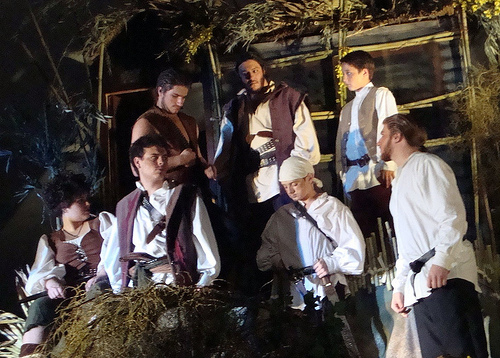

In [88]:
try_image3 = test_img[851]
Image.open(try_image3)

In [89]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: A group of people pose for a picture in front of a wall .
Beam Search, k=3: A group of people pose for a picture in front of a building .
Beam Search, k=5: A group of people pose for a picture in front of a building .
Beam Search, k=7: A group of people pose for a picture in front of a building .


Normal Max search: A man is riding a bike on a dirt road .
Beam Search, k=3: A group of people are riding bikes on a dirt road .
Beam Search, k=5: A group of people .
Beam Search, k=7: A group of people .


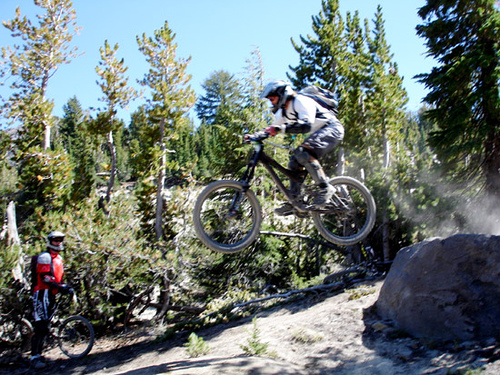

In [90]:
try_image4 = 'Flickr8k/Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

Normal Max search: A brown dog is jumping over a log in the woods .
Beam Search, k=3: A brown dog is playing with a ball in a yard .
Beam Search, k=5: A brown dog is playing with a ball in a yard .
Beam Search, k=7: A brown dog is playing with a ball in a yard .


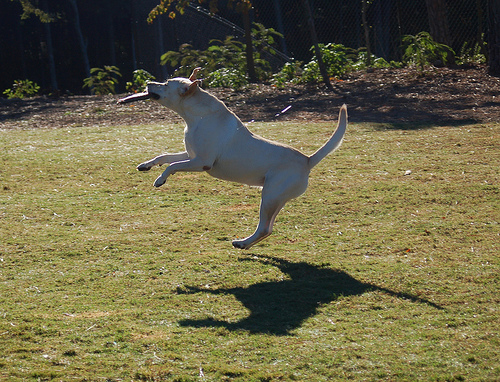

In [91]:
im = 'Flickr8k/Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A brown dog is running through the snow .
Beam Search, k=3: A brown and white dog is running through the snow .
Beam Search, k=5: A brown dog and a brown and white dog are running through the snow .
Beam Search, k=7: A brown dog with a red collar is running through the snow .


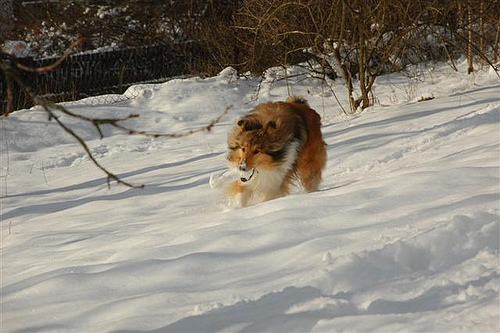

In [107]:
im = 'Flickr8k/Flicker8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man is surfing a wave on a surfboard .
Beam Search, k=3: A man is surfing a wave on a surfboard .
Beam Search, k=5: A man is surfing a wave in the ocean .
Beam Search, k=7: A man is surfing a wave in the ocean .


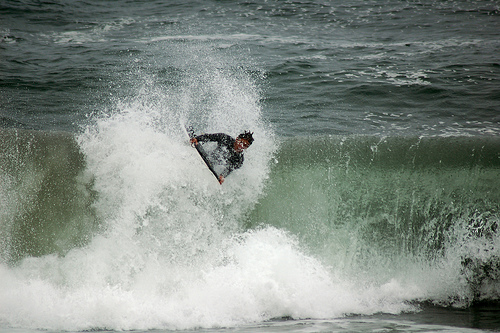

In [210]:
im = 'Flickr8k/Flicker8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A child in a red jacket is playing in a red jacket .
Beam Search, k=3: A child in a red coat is playing in a red jacket .
Beam Search, k=5: A child in a red coat is playing in a red jacket .
Beam Search, k=7: A little boy in a red jacket is .


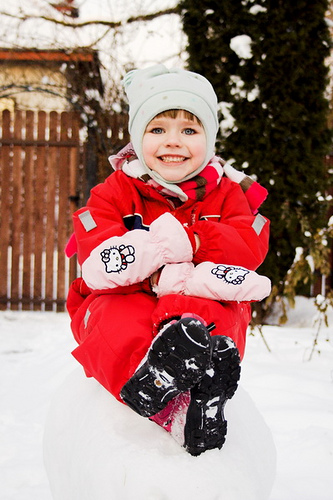

In [94]:
im = 'Flickr8k/Flicker8k_Dataset/3320032226_63390d74a6.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man is riding a bike on a dirt road .
Beam Search, k=3: A group of people are riding bikes on a dirt road .
Beam Search, k=5: A group of people are riding bicycles on a dirt road .
Beam Search, k=7: A group of people riding a bike .


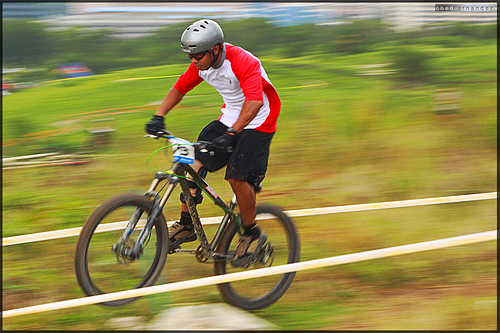

In [95]:
im = 'Flickr8k/Flicker8k_Dataset/3316725440_9ccd9b5417.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A young girl in a pink shirt is swing on a swing .
Beam Search, k=3: A young girl in a pink shirt is swing on a swing .
Beam Search, k=5: A little boy in a red shirt is swinging on a swing .
Beam Search, k=7: A swing in a swing .


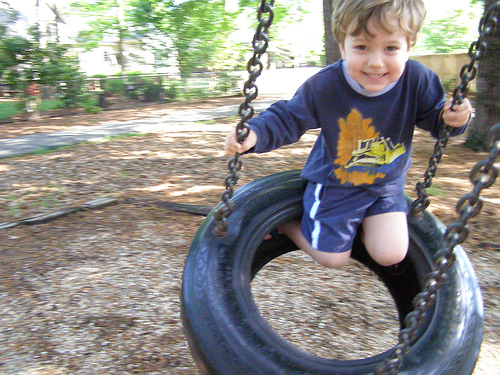

In [118]:
im = 'Flickr8k/Flicker8k_Dataset/136644343_0e2b423829.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man in a black shirt is standing in a crowd holding a drink .
Beam Search, k=3: A man in a red shirt and black hat holding a camera .
Beam Search, k=5: A man in a red shirt and black hat holding a camera .
Beam Search, k=7: A man and a woman wearing black shirts .


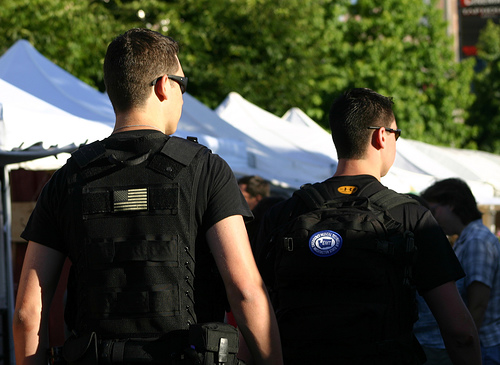

In [114]:
im = 'Flickr8k/Flicker8k_Dataset/200771289_31902164a7.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A woman in a pink shirt is standing next to a man in a red shirt and a woman in a white dress .
Beam Search, k=3: A group of people pose for a picture in front of a brick wall .
Beam Search, k=5: A group of people pose for a picture in front of a building .
Beam Search, k=7: A group of people pose for a picture in front of a building .


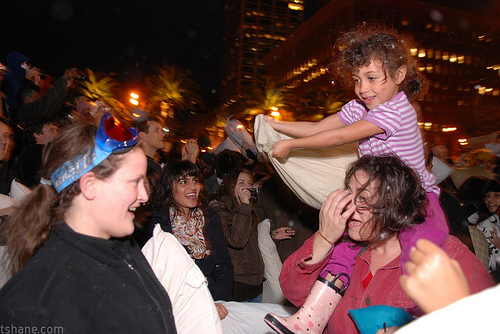

In [108]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Flickr8k/Flicker8k_Dataset\3192266178_f9bf5d3dba.jpg
Normal Max search: A man is playing with a black and white dog in a green shirt .
Beam Search, k=3: A man with a red shirt and black pants is playing soccer .
Beam Search, k=5: A man and a woman playing soccer .
Beam Search, k=7: A man and a dog are playing soccer .


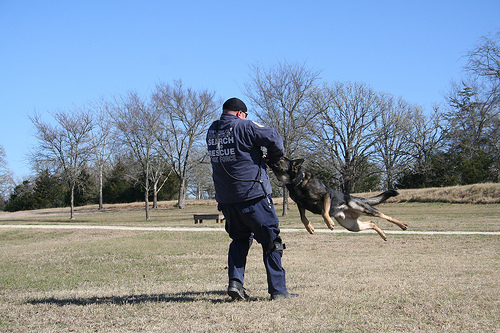

In [261]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Flickr8k/Flicker8k_Dataset\3025549604_38b86198f5.jpg
Normal Max search: A boy is playing in a red shirt .
Beam Search, k=3: A child is playing on a red a a a in a red shirt .
Beam Search, k=5: A little girl in a red coat is playing on a .
Beam Search, k=7: A boy in a red shirt is .


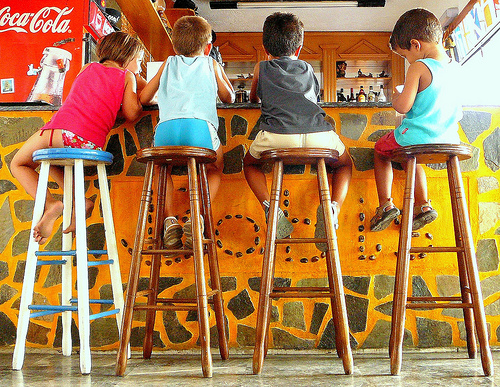

In [255]:
im = test_img[int(np.random.randint(0, 1000, size=1))]

print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [230]:
import pandas as pd
test_df = pd.read_csv('flickr8k_test_dataset.txt', delimiter='\t')
test_df_groupby = test_df.groupby('image_id')

In [231]:
test_caption_list = test_df_groupby['captions'].apply(list)

In [232]:
from nltk.translate.bleu_score import sentence_bleu

In [234]:
bleu_score = 0
test_image_length = 1000
test_image_path = 'Flickr8k/Flicker8k_Dataset/'
for idx in tqdm(range(test_image_length)):
    ref = list(map(lambda x: x.lstrip(' <start>').rstrip('<end> '), test_caption_list[idx]))
    cand = beam_search_predictions(test_image_path+test_caption_list.index[idx], beam_index=3)
    bleu_score += sentence_bleu(ref, cand)

print(bleu_score/test_image_length) 

  5%|███▉                                                                          | 50/1000 [05:36<1:46:31,  6.73s/it]C:\Users\OpSis\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:56:28<00:00,  6.99s/it]


0.5463299444144426


In [247]:
print("BLEU 4-Gram Score for Beam-Index=3: {}".format(bleu_score/test_image_length))

BLEU 4-Gram Score for Beam-Index=3: 0.5463299444144426


In [249]:
bleu_score_sampling_search= 0
test_image_length = 1000
test_image_path = 'Flickr8k/Flicker8k_Dataset/'
for idx in tqdm(range(test_image_length)):
    ref = list(map(lambda x: x.lstrip(' <start>').rstrip('<end> '), test_caption_list[idx]))
    cand = predict_captions(test_image_path+test_caption_list.index[idx])
    bleu_score_sampling_search += sentence_bleu(ref, cand)



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:03<00:00,  1.19it/s]


In [250]:
print("BLEU 4-Gram Score for Sampling or Normal Search: {}".format(bleu_score_sampling_search/test_image_length)) 

BLEU 4-Gram Score for Sampling or Normal Search: 0.5431630043343828
